# Cosmic Ray Artifact Detection using Deep Learning

## Scraping the data from the URL

In [1]:
from parallel_sync import wget
import os
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
import re
import requests
import rasterio
from matplotlib import pyplot as plt
import random

In [3]:
def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [4]:
def is_valid(url):
    """
    Checks whether `url` is a valid URL.
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

In [5]:
def get_all_images(url):
    """
    Returns all image URLs on a single `url`
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for img in tqdm(soup.find_all("a", href = re.compile("\.IMG$")), "Extracting images"):
        img_url = img.attrs.get("href")
        if not img_url:
            # if img does not contain src attribute, just skip
            continue
        # make the URL absolute by joining domain with the URL that is just extracted
        img_url = urljoin(url, img_url)
        try:
            pos = img_url.index("?")
            img_url = img_url[:pos]
        except ValueError:
            pass
        # finally, if the url is valid
        if is_valid(img_url):
            urls.append(img_url)
    return urls

In [7]:
def extract(url):
    # get all images
    imgs = get_all_images(url)
    return imgs

In [ ]:
def main3(imgs):
    wget.download(imgs)

In [11]:
doy = "2011_207"

In [10]:
imgs = extract("https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/"+doy+"/")

Extracting images: 100%|██████████| 126/126 [00:00<00:00, 12031.47it/s]


In [ ]:
main3(imgs)

In [29]:
def display(filename):
    fp = filename
    raster = rasterio.open(fp)
    array = raster.read(1)
    plt.figure(figsize=(12,12))
    plt.imshow(array)
    plt.show()

## Plotting the images

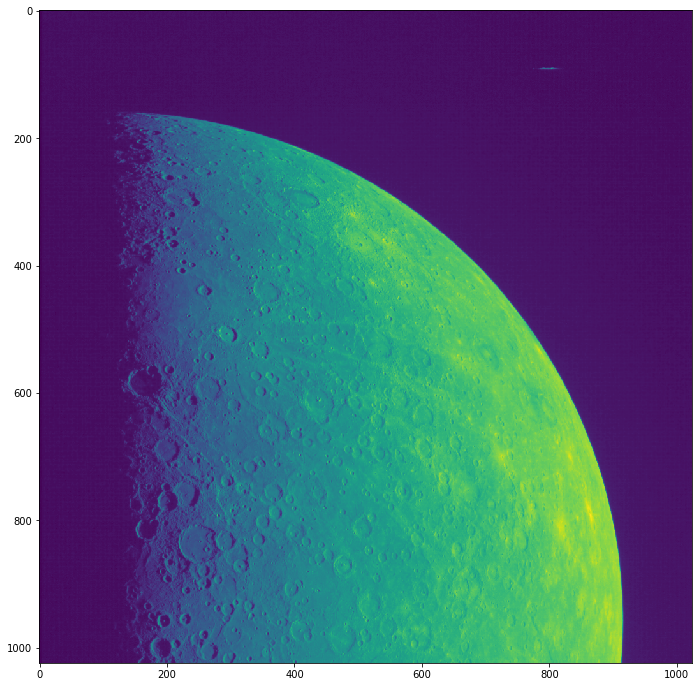

In [35]:
fp = r"data/2011_207/EW0220137668G.IMG"

raster = rasterio.open(fp)
array = raster.read(1)
plt.figure(figsize=(12,12))
plt.imshow(array)
plt.show()

#print(type(raster))

/home/rohit/anaconda3/envs/crismis/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning:

Dataset has no geotransform set. The identity matrix may be returned.



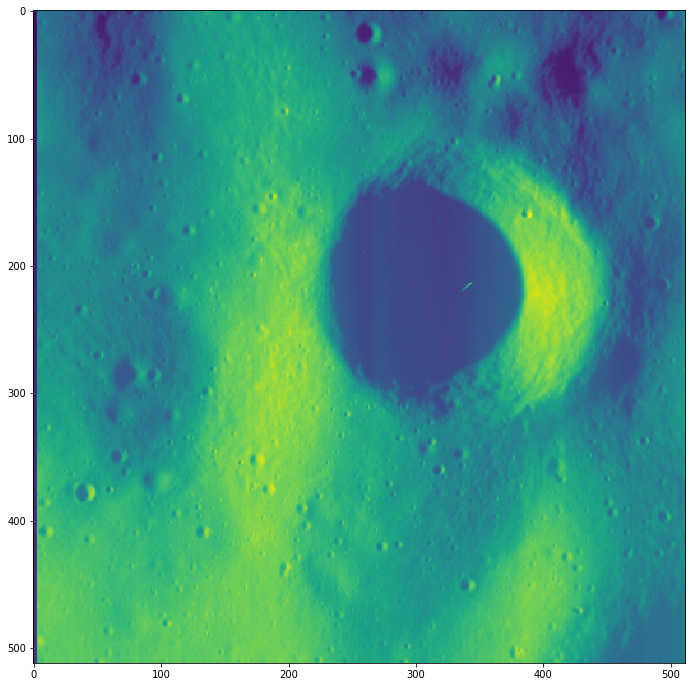

In [34]:
fp = r"backup/2014_215/EN1049375684M.IMG"

raster = rasterio.open(fp)
array = raster.read(1)
plt.figure(figsize=(12,12))
plt.imshow(array)
plt.show()

## Copying the files to a data folder

In [12]:
files = os.listdir('backup/'+doy)
mystring = 'backup/'+doy+'/'
files = [mystring+f for f in files]

In [34]:
from shutil import copyfile
for file in annotations:
    if file[1] == 'no':
        copyfile(file[0],'data/no/'+file[0].split('/')[-1])
    elif file[1] == 'yes':
        copyfile(file[0],'data/yes/'+file[0].split('/')[-1])
        

## Creating the dataset

In [2]:
import astroscrappy #it is a module that uses laplacian algorithm to detect cosmic ray artifacts
import numpy as np
import rasterio
from shutil import copyfile
import fnmatch

In [5]:
filepath = []
for file_name in os.listdir('data/'):
    if fnmatch.fnmatch(file_name, '*.IMG'):
        filepath.append('data/'+file_name)

In [6]:
for file in filepath:
    raster = rasterio.open(file)
    array = raster.read(1)
    img = np.array(array)
    res = astroscrappy.detect_cosmics(img,sigclip= 4, inmask = None, satlevel = np.inf, sepmed=False, cleantype='medmask',fsmode='median')
    flag = 0
    for row in res[0]:
        for val in row:
            if val == True:
                flag = 1
    if flag == 1:
        copyfile(file,'data/yes/'+file.split('/')[-1])
    else:
        copyfile(file,'data/no/'+file.split('/')[-1])
        

In [9]:
import random
import shutil

In [11]:
root_dir = 'data'
classes_dir = ['/no', '/yes']

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)
    os.makedirs(root_dir +'/test' + cls)


    # Creating partitions of the data after shuffling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                               int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

Total images:  1734
Training:  1560
Validation:  87
Testing:  87
Total images:  549
Training:  494
Validation:  27
Testing:  28


## Creating the Neural Network

In [8]:
import cv2
import itertools
import imutils
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from plotly import tools

import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Model,Sequential
from keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping
from keras import backend as K
init_notebook_mode(connected=True)
RANDOM_SEED=123

In [4]:
def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    raster = rasterio.open(dir_path+path+'/'+file)
                    array = raster.read(1)
                    img = np.array(array)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
TRAIN_DIR = 'data/' + 'train/'
TEST_DIR = 'data/' + 'test/'
VAL_DIR = 'data/' + 'val/'

X_train, y_train, labels = load_data(TRAIN_DIR)
X_test, y_test, _ = load_data(TEST_DIR)
X_val, y_val, _ = load_data(VAL_DIR)

  0%|          | 0/2 [00:00<?, ?it/s]/home/rohit/anaconda3/envs/crismis/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning:

Dataset has no geotransform set. The identity matrix may be returned.

  0%|          | 0/2 [00:00<?, ?it/s]

2054 images loaded from data/train/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

115 images loaded from data/test/ directory.


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

114 images loaded from data/val/ directory.


In [9]:
def preprocess_imgs(set_name):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        img = np.expand_dims(img,axis=2)
        set_new.append(img)
    
    return np.array(set_new)

In [10]:
X_train_prep = preprocess_imgs(set_name=X_train)
X_test_prep = preprocess_imgs(set_name=X_test)
X_val_prep = preprocess_imgs(set_name=X_val)

In [38]:
x_val = X_val_prep

In [13]:
x_train = X_train_prep
x_test = X_test_prep

In [47]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)
y_val = keras.utils.to_categorical(y_val, 2)

In [20]:
y_train = np.expand_dims(y_train,axis=1)

In [27]:
y_train = y_train.reshape(2054,2)
y_test = y_test.reshape(115,2)

In [44]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Cosmic Ray Artifacts: {}'.format(labels_dict[index]))
        plt.show()

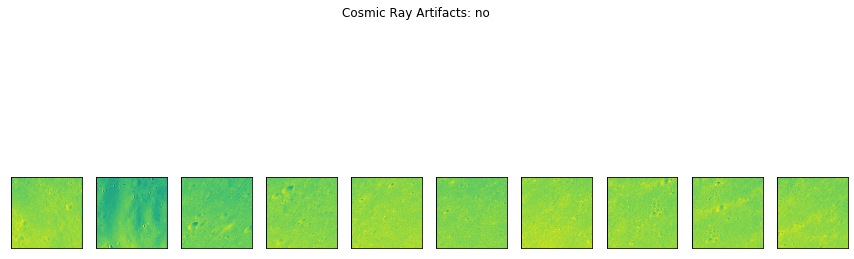

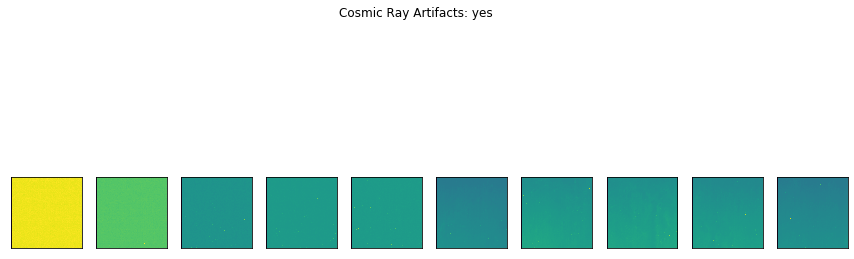

In [48]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA1YAAAEDCAYAAAA2gJUGAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjMsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+AADFEAAAgAElEQVR4nOzdeZBlWV4f9u9Z7vK2fJlZmVWV1V29Tc/0DMMs7BAhcBgQNgoUAiNkLCCEHHYY4x1CtowHCUuEQouNsLHGOEKSQeyCEJLBJoQJLEA22wADaGaYHnrv6tpye/tdzuI/zrknXzXT3VN1ezQgfT8RHZ2Zb7vv3O38zu93TgnvPYiIiIiIiOjByU/1BhAREREREf1Rx8CKiIiIiIioJwZWREREREREPTGwIiIiIiIi6omBFRERERERUU8MrIiIiIiIiHpiYEVE9K8oIcQjQoilEEJ9qrflk00I8b1CiG/f+v0/FkLcjt//0qdy24iI6F8PDKyIiD5JhBB/Vgjxgdi5vymE+BkhxB/7l/X53vsXvfdj7729n9cJIb5RCGHjds+FEL8thPiKT9Z2xs/8DiGEF0J87ie4ff98+2/e+2/y3v/V+HgG4LsAfFn8/ic9tssLIZ580NcTEdG/PhhYERF9EgghvgXAdwP4awCuAHgEwPsB/KlP5Xbdh1/23o8B7CJs948KIXY/GR8khBAAvgHAKYA/9wbP1Z/AW14BUAL4UP+tIyIi+sQwsCIiepMJIaYA/gqA/8R7/4+89yvvfeu9/ynv/V+IzymEEN8thHgl/vfdQogiPnYghPhpIcS5EOJUCPFLQggZH3teCPEXhBC/I4RYCSH+nhDiSsyGLYQQPyeE2IvPfSxmXHT8fV8I8b/HzzsTQvzjN/ou3nsH4AcAjAC8des7/rgQ4pYQYiaE+EUhxDvj3z8nluDpred+tRDig6/zMV8I4BqA/wLA1woh8q3XfqMQ4v8VQvxtIcQpgB8D8L0AviBm1M7j875PCPGdQoi3AfhofPm5EOLn4+P/kxDipZiB+w0hxBdufYYSQnybEOKZ2Ia/IYS4LoT4xfiU346f9e++3r55I3FffJMQ4mOx/f9ODCohhJBCiPcJIV4QQtwRQvyDeBwREdEfEQysiIjefF+AkDH5ydd5zn8H4PMBvBfAewB8LoD3xce+FcDLAA4Rsi/fBsBvvfarAfxxAG8D8CcB/Ex8zgHCdf0/f43P/AEAQwDvBHAZwN9+oy8S52f9eQAtgBe2HvoZhEDrMoDfBPBDAOC9/3UAJ3H7Ol8fP/u1/DkAP4UQNAHAq8sOPw/As/Gzvh7ANyFm1Lz392TRvPdPx+8HALve+y+OP/86QlvvA/hhAD8uhCjjY98C4N8D8CcA7AD49wGsvfdfFB9/T/ysH8Pr7BshxPuFEO9/ne/ZfbfPQdjnfwbAvxX//o3xv38TwBMAxgD+lzd4LyIi+kOEgRUR0ZvvEoBj7715ned8HYC/4r2/472/C+C/RyiHA0IQcwTg0Zjp+iXv/XZg9T3e+9ve+xsAfgnAr3rvf8t7XyMEc5/x6g8TQhwB+HIA3+S9P4vv+wuvs32fH7NBFYD/AcDXe+/vdA967/++934RP/M7ALxnK8Py/QgBEIQQ+wjBww9/vA8RQgwBfA2AH/betwB+An+wHPAV7/33eO+N937zOtv8mrz3P+i9P4nv8T8CKAA8FR/+DwC8z3v/UR/89uvMy3rNfeO9/2bv/Te/wab8de/9uff+RQD/D0KwB4Tj4bu8989675cA/luE7N0nUvpIRER/CDCwIiJ6850AOHiDTvE13JsBeiH+DQD+FoDfB/CzQohnhRB/8VWvvb318+bj/D7+OJ93HcCp9/7sE9h+APiVmA3aA/B/IJTrAUilc389ls7NATwfHzqI//9BAH9SCDFGyMr8kvf+5mt8zlcBMAD+r/j7DwH4ciHE4dZzXvoEt/k1CSG+VQjxkVi6eA5gurW91wE88wm+1Rvtmzdya+vnNS721cc7HjRCVoyIiP4IYGBFRPTm+2WETM9Xvs5zXgHw6Nbvj8S/IWaCvtV7/wRCqd+3CCG+pOc2vQRg/34XoIjZk28G8A1CiC4T9mcRFuH4UoQA5bH4dxFfcwOhDb4KIQv3RmWAYwAvCiFuAfhxABlCaV7ajFdv1v18hzif6r9BCPL2YsA467YXoW3e8om81ydp3wAf/3gwuDdoJiKiP8QYWBERvcm89zMAfwnA3xFCfKUQYiiEyIQQXy6E+JvxaT8C4H1CiEMhxEF8/g8CgBDiK4QQT8aFDeYAbPyvzzbdRJgX9X4hxF7cni96o9fF154A+LtxGwFgAqBGyMwNEVY+fLV/AOC/BvAuvMZcMyHEQwC+BGHe0XtxMd/sb+D1Vwe8DeDh7UUu3sAEIUi5C0ALIf4Swlyqzt8F8FeFEG8VwbvFxb99dRthzlO3zW/6vol+BMB/JYR4PGb6/hqAH3uDclIiIvpDhIEVEdEngff+uxAWRXgfQof+JQD/KYBuJb7vBPABAL8D4HcRFoD4zvjYWwH8HIAlQubn/d77f/YmbNY3IMwR+j0AdwD8l/fx2u8G8CeEEO9GCJpeAHADwIcB/MrHef5PImRgftJ7v3qd7fmg9/5nvfe3uv8A/M8A3i2E+PTXeN3PIyylfksIcfwJbPs/RQgqn47bXeHe8sLvAvAPAfwsQrD09wAM4mPfAeD74yqAfwavs29E+EeKv/cT2J6P5+8jZPZ+EcBzcRv/swd8LyIi+hQQ986HJiIienMIIZ4B8B9573/uU70tREREn2zMWBER0ZtOCPHVCHOhfv5TvS1ERET/MnAZVyIielMJIf4ZgE8D8A3xHxgmIiL6Vx5LAYmIiIiIiHpiKSAREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinhhYERERERER9cTAioiIiIiIqCcGVkRERERERD0xsCIiIiIiIuqJgRUREREREVFPDKyIiIiIiIh6YmBFRERERETUEwMrIiIiIiKinvT9PDnPRn7vrQWMlyikAQA4L9F4Be8BDwEtHBwElHBQwsM4CQcBAY9CGngIGC+RC4vaaWTSwnsBALAQEAAkPKRwkMLDeAUFB+sltLRwXsB4hUIa1C5svhYW1ksIABCA8wJaWAggvS6DRQsF5wWcl1DCofUKuTTwPmzvxmUQADJh4/ZIuLhtHQkPJVx43EtI4VA7jdPfOzn23h/e7w7I5cBnb9kFBCDg4b2AdSHeFSL8LoRPz1fSwVgFAPAegBdAfFxKD2clhPSQ0sG2CiqzEPErCHj4uC8+3v+9B9K3jT94D1gbtkdrF/ZzbBMPQEl/sS3YeswLKOVgnUjPsVam76KVg7EXcb2UHgIezov0HtUzNx+wTUs/ettOaK94PEp4OFxs23bbbu/j7icPQAoP6ySUDMcffGh/68L3yGQ47i5e6+MxEb6LjO+93cYutZ1AIQ2Ml2l/a2khhUfjNFw8Jrvt9QCU8LDx9Vo6mPg6Gb9LJi0cRHq+cRJauvS7ADB/+s4Dt+nOU+N7/ta1YdfO222xrbsedO3bOIU8nsuZtDDx3BVxH4nY/t13l8JDwt/zftvt27W38QpKuLQfbDzPuzbNhEXrVWpbITy0cGidQiZtev9Xb0937HgvkEsD6yUap1LbnvQ493ffPnzNx7s2Q9oWCYmLdnx1e3R/E+Li+2fCQguLxmto4WBje3XHpRIutbH1Ag4SWth0zEjhoeNntl7BxWu8RLh+dtf7Orbvq22fT2FbL75Dd168+mcAuPnh2YO1qR760ZNjDFWD1qu0TUNZo/I59uQaDSQql2HjcgiBtD2N0yhVm45pF1vV+Xu3bfu46s53u3UN6Y7V7pjpvr9+1TnSnZOpreJx7rf+ar2Aivur+9xOd8w6H9pfx23qrhXdNVmKcM+68aH5A5/7B+8ooYRDIQzOzBATVSEcBQK5COdEd2x054+J2+u8TN91e59sE8LDOJW+nxThar3dhko4SHgYhOPaeona6XuuDyoemwYq3Eu32sxubcf2Ptm+ZmrhMFEbLOwgnVeIrwnfz8LFfejx4McpEI7Va2+XAARar+7ZNh2vVXLr/rS93ds/+1dtVx77Rtv3G7nVh+iumR4CKh77FhIKLl3Tt7/r9r1Sw2FpCxTSpNd0+8t5iUyEPp5L7y3ieRS3E6E/4r2AhYCK7WvjdVbA4+RGjcVZe2/H6z7a9Mrbs9Bvidtn4/HSHY8itkHYjov7WNfeANJ5mo4JWWFuB7Ff69LVwHiFQsT7ePwcj9AvlsLBeBXvzQat05Dx9c7LcJ+K29jtD9N9btwHmbCp3+K2rt1yaz9113CP7l5wcb2VW1eT2x8563Wf6voroV1E7EuLdN0K7SJS2xkvIeFRqhbGq3v6m929aCibdH9auwIS4T2689kjXJczadO5aOJ+6p67fe8P+9jfc4/p2sHEa/X2tqU+Vnwft3UedG0ucO+1ubv3eQjc+vD5x23T+wqsynIXX/H9fxwD1aCQBlO9wdrmuNtMsDI5RrpB7RSMUyiUwTTbYNGWcBCY6AqX8wWO29A5M05hR2+wl61w1o7SybqyBXJp8EhxiqGscbudYqrXWNsCrQ8BxdrlKGUbfrZ5aqyFKSHhMdI1NjbD9fIUtcswVRtYCMzMEA4CrVNYuxyXswVarzBRFaZqjd/bHEEKj9pp7Ok1MmGxtAXmZgApXArm5FajX83neGZ9iO/7vO974X7asjPQE7zr/d+A1klk0mHVZNgpa5yuhmiNQpm39wRWrVVoW4220fAOyAqDttbICgMhgHqVQ5ctxMdGOPic26hajVHeptdbLzDJa8zqEqU2kMJjktW4vR6noE6rrWDXSdRGoWk0hmUDITxybdEYhdNbUxwczWCdwOFohWWbY74pAQCrRYmvfdcH8E/+4R9D9c4NdqcrGKtQx/cBQlBmnYBxEpOyRqkN5lWZPu9jX/OXH6xN8138Oz/wb2NlckyyCju6wgfPHkYmLXbzDRzCZzZOI5fmniDl1X/rLmJD3eC0HqFULRqnMdY1Rjp8DykcGqexsRkGqsUrqykAYJJX4RgZLHDaDNFYhVxZzJsSQ91gqBss2wKVzcKFQnicbIYYZw2UdDgol7i93onbpTDKmntulLk0uFSs8fxyH4flEo0LQUNlM6zbHEJ47BVrrNoChTaojcbPffF3P1ibqh187Q99KYxXqG0c0JAWSnjUVkPHTl7Xft3fC2WghcXKFBjpGrXTKKTBWNUpyNm4HAMZ2jJdB0yBK8Uc52aI/WyF03aEa8U5ztph3J42/a1yGTaxDad6kwKo59YH2M3Wqb1WtkBtNXazNc7bIQplMG9LPDI4Tef0xmZovUrbNzclLmUrABedwtpp7GVrnLXhZvM33vuPHrBNx/i6H/pi1C4DgHTdAoCr+Ry117hV76CQBpmwGOsarQuDSmuXYyibFPgBYUColC0ql2FpC2TSYqwq7KsVXm724SBQCIPWKwxVDQBY2wL7eoVTMwIADFWNpQ3X0YfzU1Q+Sx22rg1mdgAAKIRBFgfYlrbEWFXhOXHAqwvEur8vbZleV/v4nK2gdvv13/6u//PB2jSb4ht/5IswUC2GssHa5biSzVF5jdplONCL1EY3211YLzGUDU7aEW5WUxyVM+xla7ReoYr7pZQtZmYQOhZOYuNyAMB+tkr3pNppnDZD7MRj3HmBlc0x0XW6NxbSYG6Ke55TKIPWhffIpE3nwdwMkEkLCY+rxQzPrQ8wUG0aTCykgYPAw8UZfvH4SVweLGCcwuVygcZptPH+OlBtulf+5Xf99AOf+9/8Y58LAHiyvAUAeKXdw5kZ4ZH8BId6jheaw9RRtrEzs7YFMmlwqBd4udnHgV6g8uH86o75QrYohcHClsikQe0yrG2Oo3yGyodg/cyMcJSdo5QtMmFxqOa4a3ewsCVOzRhLW+ByPsfaFriSzTBRG9xud5EJg2eqyxiqJn2XTFgUssVzm8N7rid73XUCHkNV40a9hz29xkRVODZjtC5cE87MEEPVYG1zXM7n+Ivv/KcP1KZAOFb/1j++ho9U1yDhUXuNo+wcpyb0kbrOePfzC5sDXCvO4SDSsdkNaD2cn2LhwvlVuyxdE8e6Ts/trr3ddaL16p7Ac6wqTGSFYzPBrXqKS/kSe3qFtS0wVDVK0WLhSpTC4PnqEq4Ws/Rdun3Ybeu17DweJ7t4enUVxks8MjjFWFV4Ir8LAFi4Etf0GU7tGCtXpOvrX/vTv/WgTYqBnOA//NHPReUyOC9wkC3ReoVCtvjN+SOobIZ379xIbdZtR3eN68771issbYGhbHCQLbF2OayXOMgWKEWLidrgn8/fhsv5Agd6AQA41Av8yvIt8RgzOMgWODMjPF7cReUyvNzsp/7mzAzQeoWp3qR9kAmLmRmkaztwERDv6xXWLkflMsxNaGfjFfazFZa2wEG2xMwM0n6unU73LSk8lrbA93zmj/a6T3XXuu77WUisTAEZt31pCwBI/eTGaTwyCG180oxRyBa1y3CtOE9t/VR5E41XODY7uN3uYGWK9HgmDRQ8jttxeu+xqjE3A1zKl5iqTTrmaqfTcwYqXO82NsNetoaEx0RVyITFzWaa7jfdNu3oCmuXQ8Hh3cOXsHIFZnYIC4GzdgQLiUeKE8zMEFO9Rila3G6nqL3Gd777n3zcNn2gUkDjVTopu4Yc6QYLE77YSDfQwmEVf+9G0tY2h3EqReF3mwmO2wnW8UYFACNVY6o3kMJhKGusXY7fXTycRkW7RpyZQbgYxRtUHW8m2zee2mUYygaV12i9wr5eoRAmfdaddoKhqnG73cFvr67jcj7HVG3S9rVe4XI+x0jXKKTBxuYwXmEow01yoFrcaSdpROGBCIE2duqtFxjlLWabEtZJSOmxrvIw4qEushfWCvgwGAQXsz7Ohb/vXVqgKAxG7zlF1WpIEd63G6lWwmPd5hhmLXJpsW4zzJoSmQzvr6TDus7R2pCp6YKsttFYVzmkABqjIAWghgYuxnw3FxNUrU5BoNLh/coTj+Ijg7AdTiLPTfwcDyUdlPTQMQs0r0oo6VDoPziieb8yaaGlxWG+xEfmV2GcxG6+QWU15k2JymbIpUHjNIyTWJsczgvs5mto6bBsixAkKIu1ybFsizRCk0uDymqcNeFCtrHhJvbpk1cwa0qMshqjrIaWDrmyOG8GaGwYZVm2BXRs67XJkSuLoW7QWoWNyTDOGjQuPPfmOgRojVMY6BbLpsBQN5jXZQpuViaHcRKFCu26aouUUculxaot0DiF2mhkqke7inCObWwGLe3FuRgDFSVCRno/W4WLbuw0bmwWRvWUiaNKYXQpDFiU2Lgc14pzvLDeTwGX8Qr7+QpSeOxnK8xNiSv5HJmw6aIJhGtF5TKctiNsXI6xquNAi0v75bQdpZvTvA0X4aUtUDuN43qEK8UchTSp89llyYFwDekGkKZ6g9ppnLQj7GXrNKDT3Wz6aL3Ejt6k358a3koBy6VshYFqoaVLnTsAmKqwPV1HsAsmLQRuNTvIpMXlbI5SGLzc7GOiKrQu3NS7oKp1Gvt6FYOO8PO+CtfIfb2KGXuJQraYqvC8RQy6DvQydfymaoOxqqDg8Wh+jIfzE0x16KiOVYW1LbC2Rch2tCHbIRFGALvKh6naYCgbnLWjfm1qLWqX4bwdptHcymvcqPdQyBbHZoJTM05BFQDM7AC1y3BUzjDWNc7aYeqkdMfFQbbEaTPCWNfhRq0rlLLFM8sDLEyJ02aIsW6gpcXtaoKBajGKA5BH5QwjXccRaIe5CdeSgWpTYJlJi4muUMdMWu1UbJ8Wt+op2pidqWMQtrGhg3LSjvDQcIa3j27jchk6eAPZpM7DeTtEG+/XD0wgBcKdQ70IHXEVjtss3lcXtsShDh3KJ8tb2FcrvNLsYawq3Gx303aEY2qDpS1xs5nihWo/BVVjVYdAKx7Te3qF1muc2yH+1+f+DVQ+S4/XXuMon2FpS9Re49SO8OvLJ1B5jVK22IvHYSYsWqfweHEXvzF7FLc2E4xVdTFYa/P08zK+t4PAi/U+liZcL16o9rGn1ykY64LDPu6aSehzSIMDvQwDGRCYxCAniwH00pbYzdapc91lToAQXHXBGID0+HzrGD7IFhftEL+n9RJXsjkA4EAvAQDHZoLWK+xmaxxl5zgzo3Cee4WXm30sbYmXm700aB3aVeN2u4Nr+RmuZDO0TqMULRRCh3tHb1Db0Gf7heO3YSI3eLY5xP/23BfiA+snAIRO9qkZY+2KlBV5IFKkoGSqNxjKGo8Xd1CKFs5LXBvMcNyOMVEV3lrcQiYMlrbEw/lJalsg3CMapzHVofM+MyFb1QVVrdf47PFzGKsKlQ/t8AvzpzCO/dcyBhFrm+ODq0fSse+8SIFCEasfWq9w3I6xsCXWLseeXqfsWe00TtsRjttx2m4A6R4LAEPZ3LNfHyrO030y3Wdtj2NVSIzjYNBY1RjrGhYSG5vF5Mga49hHvlbMtirJXGgfl8XKrrANmTRh4E9YzN0Az9WXYRH221PDW3il3sVJO8JZO8LCliikwV62xvXyFEtbYEdv0DqF56tLuNtM4ntajFWNvWyNqdpAwaWfO8dmnOKEMEDZYqxrzE0JBYejfIaX2n3cbkO/ax0D1ivZHDfqPdRxcO7UhkHI7SqaP3AY3m8bdym0rpxmrGoc5guMdB1vJBedt4FqIGPJ1EG2xNwMMI/B1kRX2M9X4UYfAxUAqaTkzIxwasd49/AlvHP8ShpBWNoiHOxtmSLn2mkcZMs0Ot0dANZLLGwZD/ACpyZkxixCKWN3Ar6w3sflfIEb9R4yaVJpgYPAmRnhbeWte1LpbSxP7EYz9FZ5xn0TAqU2yKTDOGvSySJlSEeOBnFkucngvUBda8ALSOWR5QYmlvt5J5HnFqtNAWMUjJOo2wyj/CLL4bzAQIcT7h3T26itxjBrUSgDJR12yw02TRjpmRQNLg3WKJQN5XKVQnNniMYoZMrBeWBnEtq7y/YAoUQtUxa7O2v8wu0nsfmyBR770ufD5zuRsmK1USHQ0gaDvMW6yeA8Uumd6BGrwjmcNwMU0uLZ1QHGWY1L5SoFLGW86OQyBDVdVqrbx40NJaK5NCkgAoCDcolcWTTxwjHUDc6aAZZtgWm2wa+dPQbjFSqboVQmXdz0VslOqVrUJgwGTLLQSdvLN7gynGOahxtQaxWWTYFNmyFTNnWqh1nIcj0yOcO6DRepxilcKlfQwqGyWQxWHQa6RaYsMmXTPn91Wet98aG0d6IrGKfSYFHeILcAACAASURBVMNutk6lUIU0aTS/Gy0bqBbztoT1AlfyOTY2w362Qu00dnSFkapxp5ng8dFJygQ9Wp6kUdWJqkL2KptBCoeb1RQD1WJjs3TT6d5zqtd4qDjDnWYHz60PMMkqTHQVMlVbo2cmZn0eHZ6mfWS9RClbjFWNgWzSqN9Y1aFD3o6xo0P2syv/mpsyjR4+ECHiKK1LQeulbIU77Q6O20nKiBkn4+jbKo3KzewAY1VjqGpM1QZTvcZQ1ThuJyn4utPuQAoXRkjtABbherivVljaMrXpcKsjbiFTJ6wb6VVwmNkRhrIJHT5VoZAt1rYI2Rw7SDf3hR3gtpniTruDTFiomPk6yBaovcb1MuyDYdx2IHQEw2jtEHvZKv39gViHQra4WszSNr2wOcCiLTEzQ1Qug40lNkAIUDJhcbWYQUuHA73EU8NbeEt5N3VibLzn7ecrWC+xm61xkC2wsGU4hmSDsW4w0eH5T4yPsbEZChU6xRsXBhQlPAplsJ+v03GXSYtcGkh4LEwJLS32sxV2YvayG3g4KudwXmA/D9fc3WyNW/UUtbv4nJUJnUELeU854kkzTh3GB1WkwGmAXbnGJbXERFY4NWOc2ntLhE/NGF+3+2t4b/EKPry+FjrbMUDaVyuU8b1mdoA9vcJQNbiUrSDh07E7VHXIeAmLUrT4qsmH8ER+B3/+0f8Plc9QypA9GasKFiJlDUphUjD19OYqzkwIgo6yc3zl7m8AAN49uYHP3n0xBPvShExwl432YbAikxZrm+Oh4gxXixBwXy/PUPtwTeg+o5dYq3mow6DRvl5CwWOqNtjXS5yaccqwFcKkLFMZfy+ESedO7TVaF/7rjvtHBydpv9UuS1n4qdqEPoxweLnZS5+9va+7YG1PrzCRIeDvSkEfL+6m9ylFi6fKm3i8uJvOqSvZDJXPcC07Q+sVPrq4gpNqhKfnl/G+R34aOzJk0b/k6Gk8Vd7Es/VlAKHDvbDlPaWw90/gZjNNv3XXJAB4+/hWqDZRNYayxi0zxc12DwDw68snUn+wy25cyeeYmQHOzBBH+QwHOlQ4Lewg9dP2VWi3ymd4angrXRufLG7juB2nKorKhWO2C5a6LFIXHA9l6Ic8UpymzCKAdH9pvcKiLXGj3sXKhD4wgHQ/uFHvYqxqPFSENh/KUAptvMJpM+rRngCkxFhVuFrMkckwQDGUDa6Xp/dca7pztxsglcLhhc1BquQZ6RArdPebiarwfHWAoaqxr1Z4x+BGykB1GbGuHLKrZhirOt2b97J1qoLpsv7jrcDzQC8xVWvs6xWe3YRqvavFDBahbPNSFgYRQ+AW+ivrGGNULgxwWAjMbKgeONBLVDGWaL26JyH0B5rsftu4O6D24ohGKduUMu2CqIFqMFANzttB6LQijOxubAYlPE6bEcruhh1LLELj1RioFkVM+a9tgdvtFDM7QOVCWm8cR6kfHx7jVrODoWpSuk/GUfNh7Bgp4bB2OdY2T3Ntug5Et3OP2wn28zUWtsTKFJjI0JF7x+BGunitXYGJqjDSNXQsBep2eiHbXiMsXknkMnSANyam96XHtZ05ch3mf+XawjmJIjPIcwuIEFRJ6eGbEFApbWGtDJkrI+GcxLisURmd6nIPBkvM6hKZsvjI7ApK3ab2kMJjVpcY5C0ujdbYLTYwTuLaaBYuc8rDS4/53TFWdchcAUDdZqHjH7NjubZpTpXzAjvDCrcWE9RGQUqPTNkU53fBVWM0hnmLXFuM8ga3b+0izwwemJAxq6Iwb8sU+GnpUrZov1hBSwvjJHJlsV+s4LzAsi1SxiKXFibOwwNCh3yabVAbjUVbopAh6JHC46QeQYuwD7V0KNTFiFIhLaZ5hWle4aQaIVMWubKwXqBxCmfNIJbQWQyzBpmyqEwslbIKmxhElarF2uQ4bwa4PjlHqbp5jgJnzeCinC0eR6le3MkUoPVoVOg4kHGlmGNHVylzvbIFjAv/1/HmervegfUCu3qNnaxKF8SDfBlL+GZwXuC0GeGJwd17trdyGaZ6gz29QhUzCbfbKWZmiMeHxykLVUiDXb3GUSxJab3Cb84fxe+cPYRHBqfY0VWcixGybTfraejo2gy7WSj17bLdXRZ8aQsMVCgP6G6AN+q9FJR2WaswWldBidcetXpD/qIWv9s33WifcfKeEsRxLNGzkDhpR6F8Nt5EwusynLXhumohQ8mfU2GwKN6YrmRzfPrgJZzaESQ8Kp/hoewMa5ejEAZDGT5jZgdhxF+EUdfKX3TKx1ufmQkbOmVqlUYjX2720+OlbHGj3sUz1WXcqPdC5yKWDCl4nLUjTOJ2VV6nDFhX/vRARAjmu5LFs3aI3SyUyy7jDfFWPcXCljhvh9DSpfm2jxd38a7yJbwtv4VDPcdxO74nqzVVG9yuQ2nujXoPE1VhbkK2K5cGCxNGVxunU4nfQDaQ8JjHrEfrVJhDCYHTZggJj1V8DAAWbYkXN3t4ZbODQoWA65XYmQIABYdRHDHW0uJSvsS14jyW16l47HTliVnq9GwPfj2I7UznS+0lfKy+ioUr8eH1NZzbIRaujFUhS1zLznDXDvDB+hquFjOc2lHYr15h4UpYCExkFc+3MlWGLGPJWZchcbG0sJQtfnr5FO6aHaxdgYUd4K6ZYG0LnLWh09h6nYKsTBqctaO0rwphcLud4mcX78LT1VW8XO/FvoBJZYJdhzQTocNXiNA5fKnax1k7SiPjANJc1jcjW32oFzi3QxzqBe6aSQpwTk3IToQB5TCdYqrCPXmsqjB67kO2uAu8ukGPrv3GcUAlEzYEQTFLCAB7OlxbaqdRuQzP1YeoXYbPGD6POpZgXsvPUvDcxrlE+zGrBiANUJSywXP1YexsFvis8gV8fvkCnJdY2hL7RfisXFpUPsNU1rianeMzhi+k91q4MAA+VHWahvBA7EXmZqrWuNnu4rn6EGtXYKyqdC8/NhPcNTvpZUf5LLXH89UlrOKg0XkMqoYyBGP7eolDPUcpW+yqUKlxPTtFKdrU2c6ExUvtfno/APcMwIXALgS/x23IonSd9ON2fE95cee0GaUB2qNyFkpi8yWGssHSFimouVHvYW1zvFzt4rQZobY6VXA8MBcGyF7chOxtIQ0eL+5gactQaaBqHOgl3jt6IVaQyXuCK+dlSkR0AyWtU6h86Ed3JeKVy1B7jUv5EmNVp/l7tdfhOhHL/brs2MWggU6BWHcPPMrPUcgWv3D+NjxfXcKlfAkJj1v1FAfZIgXRJ+0o3VtPzSiUfEKm8wcImaliq9R1bspUOvha7u9qK0TqSGTCYu2KdCCdmzC6mkuTyld2sw0KZbCjN6m0wsYJd2ftML12O1DZ2CzV+He18GubY6IqjOPFfaKqUFYYL4QhwzXEQbaAFGGyInCRWSriSMhZO8TahpKvbq5VV06j4PCO0U0AwKV8id+vruLXzh5Lo0SFDDX7xivsZWsouFT+0oewIcNQKINh1iBXFrk2eOZWiLCtk5gWFQZ5i1Wdw1oJpTy0tqg3GUb7G8itDrOUHqbWMEam7M+0qFBqg7XJ02dta+OcuM5ucZE+fW4eO0pWQFgBbC1e0ZX9LZZh3zZGQYhQ4gcAxiq09mJxhlwbLNcFBIBCh0r8ruSwm0C6anJcuXqO1vQrXWmcRiEtjgah1CGXoaSvsQqXinBBHKhQDgmE54+zOs1dksKjiuV2KWNVLMMEXWVxNAwX4pDdCpmvVVtgoFs8PDxHbTXOmyFyadKo9O3NBKOswTirMc02WJtwMR3qBgPVwkFgXpcpANwfrEMZYNaGjrDNsGjKtI2V1dAyzO+qbBZKGtsco6zBTpzf1VqFSV5hnNX9OlfiYpS/u+CPYtleF0wBSAvLPD48xo6uwuIHwqZMlvMC7x69lNr1M3dewJ0mZDemOnQSlHD4vdVVPF8dpBG5V+owCnnWDlNGKRM2LVLwZHk7jEArgy+/+i9SzXpXIthdmwDcU064l61wu965Z1J9F2ytTIHTdhSySS5PF3DjFTYuTyWKD8xdnLfdqF43cARc3IzHKnSkx6rCQbZIpYHHZoy1LXDcTmKHMowmTtUmjaxnMnQ09tUKhWzxUnsJV/QMT5U3MZEbfKy+AgCpU1TE0rdSGJzaEQrZ4lDPMVUrHOrwXSuXhTIgaTBVK5zaULJReZ3Koqdqg6la42oxw0PFGQpp8JbyDk7NCK/Uu7jd7uAgW8JC4Ea9G0rC477uyiAfiLqotf/Y8jIeK0+wr1f4goPnYOL1fjuT3I1OP17cxVeMP4pStLAQOLdDKFyUW9VOY2YHuFae49nVQTjnXBbL4GuMVY2JrtLocFfV0QVAmXChQx4HGnNp0nzPka5TGX13rdnLL67BDgJa2jBfUbpUono5W6TA724zgYklLlpeTHjvynZ7la15YBKzE6d2hFM7wkRt8NzmEJfzkCl6qdoP2SjZ4q6Z4Her6/jVxVtStuNafobfX19Oo70fXl9Lo+5AKL8bqgYKHq3TmMgw8m/jfKKuvxGmBxRY2jLt55BFCJnYw5i5qp3GlWIe5kpLs1X+qnCYL1IZ4tIUYc51zI4BIWDoAi8gBFIPF2dY2zy9h4THUZxH9MCESNm3UrR4Ir8DBYeFLdP51PVvAOCZ6hBjXaeO6IFepjLg8P8wOAKEYDLNaYxZZQmPk3aE2ms8kd/BI/kJ3lLexcP5acgq6wUql2NPr+LctxY32914LalwLT8DgFCiKCyuZyH7fKvdDXO87ACP5ndxx47ReImVzzFWFQ7zJa6NZjgsl5i7EnfdMAU1T1dXY5vqWBLXc2qF9xjKBm8rb+LYTFJnfu1yHLchOHb+IsN53I7xtvJmynI9UpzgoeI8ZauAi8XMWq+xsAP8xPFn49t/60/h2373q1CKFqs45/96dhoH9bN0PE/1BkfZOXZ0la7rry7NneoNjvIZ1i5Pj3UDeRub4Uo+xyQLnfwdHe7roRJLpwHG31tcwdyUaVv385DNGeka+/ka17bmw903IXGj3g1z5HSNk3aEZ+orKISJc87Ccdft0y6QG+twbHYDQXNTYqIq3G6nMXDyuJLNMVYVLuklXm4uoRAmZowNDrIlHsrPULksDSZ0WSYLiZkdwDiJh4rzVOHSzSs+bifYkRt8zs4LGOs6BYBXi1k6L2ofqmZar9K0IiAMXq1dngZtQinuxb3pNAZv24Hvq91fT8v7dFPqLmaLOIoaJvyHztHa5am8Ko+jJ0CYnN3E1Ys6mbRpZZTuwrVd75xJg8v5PEbmJa7oWaw5D5mEmRmECcgq1OcPVMiEDVUTail9uJl2GbUuFXvWDsOKZE5hHqPwLtB7KA8p/71ijaGs0whr7TRGqk5zAyYynCwr89opwTdkLZ7+wKOorY6rjllk0uHo0gxlZjAdVFi2ORoTFq2oNxmu7c2wenaKwSgsJtG2GkIA09EG4sMTHF09g2k13nt4AwCwbEKH/+Z8B6UON2ctHEplYsfXYdkUKJSFkg65Mhjqi8mTaYU25SHKrvPZzfcKWTKx9bwuWNo0GeYfuRRWf4vze8qyhY6fM8hbGKvQbAVRXRZL95ln5S9WgbkR5yktTZiflCsLKVxaYGGkGxgX0tnGKezlG+zlG0yyGuMsZChzafHI6AxPDW/BeInDMowqntTDkA2EwHE1xiirkUuDW5sJ5m0JLcLxtbEZXlrt4cpggTyWoG1shsZpDHWTFnroAp/WKjRxztUoazDQLQptUKrw/0dGZ7i5nqZOWBcwWCexU4Qg6qQKo1VXhnNo6XBrtYN53aNsLR7zmbDpHOpW3wSQMnRX8jBn6U4zgfMiBQe11Xh6eTkMcrgy1v0vcRYXTQg3iJAh2dMrPDY4ScHW3JQpg7S0RfreXco+ExYvN/t4fnMJA9nguJ1gZgbpwnceS+p2dBix3I2LE0z1BmftCLvZOgZ1Fx36k3YUS7/EPX8fqxq7eo3jeoRL2QonbY8yCyGwozdwPmSnVFxtaCgbjPVFOdxRPsPDsVOztkU6Tg70Mi3ks7YFDvQylQt2o3ndKP6pHeEt+R1cUkvM7AgndoyZHWFtCyh4HOXnqSRpqjaovMa+WuGXZ2/BT9z5bOyqNS6rRZh/Ig0K2WJpSxybULbYTQQfqwpn7QjXsjOMZI0reobaZdjX4fs5hEUdrmRzWAi0cSGYg2xx0YHpk7HyFyvA7edrPFMd4sV6P2UvunKohSlhYknLVG1w10zw8+vH8HRzBb+6ehIvN/sYqDbN4etGJ0+aMS6Xi1T299TwFqZqE+bzNSMUsazvWpznEOZwKgxUe095XrP1HRunsZ+v40BfKA0FwlypkQ4B21RvkMey0NppXMnm+Mzh89jYMN8oBVRepABrN1Z4XCvPcSm/KPW6b5nGvlqm/fNUcRMLO8Djg9ApV/D4zPELqUyqO7/3sjVOzTh0lITFk8M7ab5QVxIKbHdcwyh251p2joms0MY50kNZY+HKNL/qKJ/F+3x4zc12N46G61AKGrNRdVyMoMs4PrM6xHEsswOAoWpi6WGeOtPdAht72RpLEypWuuvJUT7DSTvCsbnIYj2otFCFMHhrdoxn68uhNCpmrq7qGYo4wHw5niNdew5lWFBiux27AaJugYuj/DxlrPf1EleLkO14trmMUzvCzA5CybWs8PmDZ7FwYY7ctewcvx8HXY6yc3xaeQOlCAuhlLLFoV4gEwbXsxM8Vx/iY5srmNkB/sXmOj4tP8NiK8tdu1Cq/ejgBK3X+M3NYzi3Q9w1kxA4yotrVbeq6wMT4V5ybHZiGWC818RFaxZtCHiOzQRnJpyvLzeXMNWbmOUOpaPd/enR8gRDGQbzQ/B0gofLczx19Q6+5i2/Fa5hXuPzy7CGQSHbtNBFd28K87iKNIjTVWcd5TM8Vh5jZgZY2BJjVeO0GaUyvtYr7OdrLG2Yk3kpltB399+wkEMoR39kdBbWMXA5zs0wBWbGqzRn64HFa+rShPtKV0lRe52qG15u9vFifSllrJa2SNkthbAQ2HtGL6bS9IfzE4xje6xtgd9eP4KH85M0pxBAWgQHQCxxr3CyNQe3jCXfMztIf5PwOG7DPMGPVkdp4ZmpuijdLYRJ1QOZsBfzD7emMYU5WqFkPgwkhgyxioNiXZn+a7nvIexuPlUX/JSyvWcOTxccreLB0C360D1npBq8Y3QzlUy0cSUzCxnqmfM5HirOcGaGuN3u4DMHz4dynrj61bHZiTfnIqUbAWBmBhiqJl7QV6mhuouNEg7GKdypJ+HmFxfTcBDYzTZptODF5hLWLseBXuI9k5fSRLbjdnyxEmIcvR7KOtXNPjiBJz/rRbRxCfVCm1ACEt9TCo9Nk4VgRDmMJhXWbYbxixJSOrStgmkVrBU4OR/DPrXCyXwE10q8uNyDihmk28sx5nfHePa5K3h5Nr1npcEuy9Tto8pmqKwOJWTyYvxI7zYQ0qPIwsXcOAnvY5bMSLStRqEsysyk+VOTt58iUxZShM8ZFQ2MDcFT9726VQZbG5YHf2gy61VlDVx09LuMzjAGUF1nx/mwrLTxYeGKj50dolAhu7QyOWqrU+enUAbOC3xg/lhaCAQATqtRWj2wC0TXJk+r/AFxjkM9wukmXLCneYXzNszL6oK7EGSpkLnKWqzbDLmyqQOdS5OCwqPBDM8v93E0nCGXYTGHbqU+JR128zXOqiFmVYmHR+fYzTa4vZ5ACI+HJz1GWKXEuRniw/MjzGPJE4AUbHU/z02ZskndoMb18hRaWlwuwwpNd5qLka0u2x06Cg329AqlaOOcoSZNZs+ExdyEm8/lfI5XNtOwMpoXeOfwBp5bH+ComIU5XabEaRMWtOjKALv6824e2OV8cVFyGBej6DJSXXnAPHa+5yYsFlI7nRZleHJ0t+d5D0CEa9S1OOK2faG+Ve9gR1eYmxLTmG3qMjpAKGU+jp2ymR1gqOqUURqrOs1P6+ZcXM9OcagWWLmwitNxOwkrJMU5HK1XOLHjVHr0OYPn8Cvzt+Dl1S60cFi7Ai+2+2k/LW2JR/IT3G53YpAkcT07RRvb8JV2L0wENtN0g3wsv4uxqvAF02dSZmxpiziZWKcFEnplrBBuihubYbQVnDovUilN1zntOqzPVIe4omeY2RGero4wi8sqAxcrzWrp4vHR4sXVHp5ZHuC8HeLYjENpqMvx+OAYc1PgxfVeyAxs1f5radN8xC7Aal04b2sbVtJcmRw7ukahwj2gjvMyPjQ7woFe4iBbpoHDtcvxf8/eCQuZjttxvAZ1WbDTuNruzAxSwPBAvMddc5HVfba5nB56pdlD5TXumglerC/FjozGK81ees5Q1XihPkhZia5D0/UhuoqQrq2A0GkKk/kvjvldtcadJiyS0GWLtgdgAeB3NtdTSWmXlZDwKIVBJgz281VY+VGv4uearfcIx8edZidmsUJfZi9b48V6Pw12LGx5z4p4fdoVCIMAO7LCb9bXcS0/w1U9CyvmZecpC1DKFleyGR4v7qaVQEPbhXNmHefrdIutdKW/a1uk4OvYTFLmMuyHsArhNX2Gymf4YH0dAHA9O8GhCpmEx4u7eCK/g2frK2lbWq+wq1b4aH2EV0zYz5eycI3qeguVz8Lghlrh0cEx3jq4jYfzUzzbHKb2rnwoVZ2ZIWZ2kDJKvYhuQbU2LeIBhLmjlcvSPMlu32bC4tSM0iIS3XWp+57d79YL/OnxLVQ+w+V8js/afRGfN3omDST81PLT8ZHqGs7ie3VlmWNV4dSO0yrTAHAeq6sWtoxL1IescinDPKRzM0z30LAv63vut935vj0Xq9M4nRaQ6gYBu4WJHli8zV0tZsikiatobyDhw+BazDKuTMhGd4OFtctw0o5w0oZ+0iwu+vDW4hZ+bfEW3Gx2cWpG9wQ3Q9nEMvY4WNLsphLYszYMZg7Vxeq5Ki6ClAmbFl0CkBa76xZ8uujHh2OsW8Cqy5IC4XrcldKP4xzPszZULlzKwrSE43YM50M/cjsQe7X7LgUEkFbO60aMuzk8e1nYiQou1nb6NEoJABub4+HBGW634SKthU31jM6L1OHqft/YDM80V9B6hbN2hKGqcSWb4R3Dm5joKtV9T/Ual+OB+lB+hg8vr4XVROJIQbda2BODu/i08Sv3LL+ay7DIQBdUdAtnHJsxJrLC7WYHw1iK0/07GkPZ4CgPN2IpHEZb73ffBHB3NQr/PpWX+NBLRxjoFqVuMc4aVCYEON4LGCOxPB5hsSkx+LI7aZd83mPPo/jAGOUgbIc1Crv7y7QPrJPYHVT4vE97Bo89dgeXx8uUaRlndcpcZSpky86rQVoIAQCaVkOWFjqzmO6sUWYmzbFyMWNVFAZZZrBqclgnYWMWKwRtHqO8wShvMcwuMlYecQ5RE06SbmGLF2e7GBY92lSGf09lbXJcKlYwTqbl1YFwkcykxcKUeGU1xawusapyDFSL82aAyupUBtjNYzqux1i0BYoYzBxX47DSXVySvfv31cLHh/K37rVaWDw8OU+Z2ot/b8SGoMqqtJy7hMcwazGIwWu3+t/a5JDweH5xKfy7EE7hreM7WLQFNiZMYN/NQ3nhqs1xMFxhoiv8/uIQWjocDedobJ9RqxAAXor18pmwadRZxoxbN8jRlVtlwuJaMcNL1X4IEtoSl/M5xqoOk4Lj6NOjZVi44kOrh/A7y4fxa4vHAQB34ryG7uLcLTpx1o7wrp1XcOP/Z+1NeiRJsjSxT2VRVVNb3dzcPcJjz6jM6spauqa7B909mAXs4WVIXogB5sALwQv/CX8GL8QcBzwMCAwJDAYgmj1kT6+1dVXuGauHb+ZubmZquoiI8vDkPTPPKlZPhlOAQlVlZNiipiry3vu2zQTP8zP8cnOMaUrTPG6+AqgBdnFwc2QXuGiHoLwfKuouo9sSf4e20zhvBuL4uW/XmNgSa5dh6TIcpksyC9jRZvD07r2WUmJ/zja8jPzwdPK7xTssAxUdU7OWqTnbmJPhBlEfXrVT4dwf2ytCMmIxXKgar9wUNnFRrL6dOtaR2hc6hYt2iP9h/HN4JHiYX+HpYI7/8d7/iXM3QtWl8fclA4i/K4/xUf5O9nMuvh+mc7IsjnopDcol/KI5wpEhKsbCFbhq++KIt/A9sWFnqsZ7rSS5pSXkAd7QVmiCwXVbQEezkH1LFsaPszleN/vyd4a6kkJr1/np4+It3lQTLJoeCtMIClQHi+8VJ6TndSkeFtdi382Fj0bAw3QeaXxb9IqbqF0ECyAr9386/hVeb/bw48lroXKxxuDT9SHOm4For7jYZl2WCzo2axnWLvuteoC/d4UgDQ7fq9yUfzcn+jwhD16Q0itHtPsiUn6YWscuiGTh3eC+vcaeWcsUn/VEXLB6JIJivWqnOExvCEWM9FP+vRiV+n7vNemiXIG2M5iaFerO4KQZY+4G4vBZxoZ+oGtkiRMt4thsbhVM7F45NhuKF4gICxe9d1odWdNPdIk3sUGxice5G2Gq1/HZdcgjPeqRvaRhkN7gg+wMx/Zq+xNFhGrpe6L3qTqD4/RKLO55mDAzhHydtUPMfR+v2n3JCp3qFf7Xqz/ASFU4MEs8iE0Xa4ts4uV9ji0NhHQS8Fl5KJq+f7P8AVJ4tNGlMU8c2s5Irh6bibGOjn9DgNCEOw+sAFy52+6iV64v9uuM+tjEy367S+uamSXu2yuMdYmhqlCoGhduhC9bokcemCWO7AJv2j1xBGSL+9ITg4B9AniQqBOieL7cTDG1a3xdzURDx3T2t/VENN0q6TCzNEx5lp3d+m5tp4UJMjYb6PhdQtQ028RjHYdwD7KrW/Xue60EkVFBNF0elBW6xuP0Uhg/mWqF0TaKzt4A8CSf43l+Jhq0JjZfTM8dGzLDGe3qd+Nw5H5KAxSmPzOlcxBNmxa+h8uo1a07g7nry4Bu14J9bEpxsL2MzDZ2OgyR+stMtuu2h4Un2/uebkWbqxGiX3POhwAAIABJREFU6RY1er/NEOhbUwEXbvumNvE4sjcyJWEb0jJQflCIoWuTOOU9SJeCUAGQxmsX+rSKNjmVkEPQRTuUKWgbDH5aPsIyiua4aOAH6H56jbN2hKe9S9xPr1F3Bi4+vFZ5nLYj0W8x95an3nwjKhCSZROPL6pD/HjwEiufR61WK2YdNnEiwn3Yu/rmlfpW11QlW2797z5+jZ/+7Cny6NTHSNLVmzGs9RgdrJAkHU5Px3COgplLZ+EKwDkNbQK08Wi9xsd773C6GMprvFpOJAyUkRaiRwa0XuPrk320QeF4sMCizlG2KWqvUeQ1wspi0Kt3jCmApjFipOGcxn6/RNUarKosIlY+mm84tFHv1Xot1utdt3UJLCuiOHUAqsbicnEHilXXoY732WXdF81S7Qwu6z4mdgOTeCzbjGg5zuA7BxdCpwEIWeJwa2CLWtWR2veof0UmE9FOfNtMtUiVQ64dVi5D4zUGljaQ02qIy7oveoomTmgJnaLXWLdUvHK4r1VeLOErb5AZKsI+6F/gs9UhFk0PPdPiQXGNlctwWfUxyTeY5St8viSd3tPBHE3Q0vi910oSzNIVjrIb7Ee6GTvtsM5kt6GyiZfiEiAE+35OTRaAaDqzxn+8/AD/9s0P8e9efow/f/cYP7l4gKumkEILoLDTJhh5D4CarQe9a8rH2aGRjUwl2Vd8zWfZCn9XHgvStp2sVWJaQUYE9OcPsmtB26/bAtN0jXv5jVCFLlvSCd3JwhaQifWNy6UwOm3HojnlyAggcrtdH3txGglAUKOVz2kPjVoaqzw+qe7HQ7umQiZkeNXs48KNUAcr1JM2kMnDwvcwd338l8OfYx4C1iHDs+wM/3D0Fa4D7etM/85Ui6le0xSvs3ien8lrBiQoQyYC+l30icwLeuJixjlNVYzFkOIvuQNiFQIuamqW500fS0c0OY0g9L2BrjAydMDqJMh5tvA9odaNTXmraRnrjUQtfHd8hoN0hYGu8NnqEIZ1bGaN54MLDE2Fq7bYBvfGPeXn64fy2/42fn5PNdGxbR/Pi3OsfIalz+nziuGTx8jUsj8ANKXvqQYTW8JE++FlzINjjeP7rqOIEJH4nAYLV65P91kwYlFOOVIV9gRxps/OCAGAWw5e/3FBOizOvBpEV7WF7yFPXGyAjFC3NDrM3YAGAUiwZ9bSYH2/95q0Sr1zPM/PSKoQnQML3YjjHzeoTAG8bPtS3LJo/TC9iZP+1Q71NTaXd6GqfmMR1VHjbTvB23aCF/UMhapFe8S11ZFdYO4HOG3HKFSNe2YRfw+SJDA6x00o/05TvcKrakpat460a1VHGqDn+TmGiuh379wYL+Nw4Y8GX+AvNh/gw/QdbkKOZejdsr/nvTZPCFX0MaOKdSx50uJ/u/kxvmwO5DMuPQVMs+sh27Ir0MDuqi2EwnjXZRMv16P0qXxGlXSipZqatVil30+vpcknevMQuWrxNL2I6BydY/92+bv4v9cf4twNceGGeN1MZSgFAPN4HxHokONlPcUv1/cBAM+yc+gk4FlxIb8pZwcyC+AovZHGiBtYAPjr9dPoAEvOgbsu2jx8ZKp722lcuQImUvb/+ubJ3YcAiZK9H4DQ4zQ6lCHDyFSCOHHzAUCGVzzU5Ibs8/oe9mKjFpDgoh3ib8on+LI+RIhon46I7EU7lExGm3hoBKFp+uiTAABfV/uYmZUMmMjUhQak4x20sI60Yh40DWJzCFDtMNA19i0N4zUCrtueoGSkl93qx/IddPOb61vtEF1CP+rX5T6+OzgVNxM2kuCHZJrStIUogArWbKQYEy6r62HPlAhIMDMrvG7Ieeuq7Yuz3zDqA+oYeMlrd9JR+kwuJjkNFZjGzZa57izwJS0C5c8c2RtxYmGOeulTZMbFho4m1yfNBPftNaqObqSqM/E7GCxcgTLJ7kiziN/Ja0zzEvOqjz/48eeoYtGWG4eQ10juUzPUODKmsL0WrqWb6qevHsI/q6EbA6U9ejn94D+5PMaT/bnot3REFo0KWDYZvj95h89uDjDONrjXv0HxoEHlLN6tR3j7ch+z4wW0Csitw+zhNXxIIm2PLMGt9ULvW9cpqpiVRIiVwtnlCIf7N9BJh8I2WNQ5Ln9yiOmPztE4jdV5H3v3blBW9Dtwo6V1gHN3MFqIBWuqPVToxLRimFY4zFc4TJd4W08AAON0g4f9ayxbQiXYJdBEpzYXFIwJ4rh13RSYpCVCR7pCF9HV0CX0fiDTC74/VULvX5gGy5IyroamxlXoYWhr1N6I/sskHtNeecsMYpxWZOjSZli3WaRVdviz8w/kITeJp4Ytaun4PVnjeLKJdBL9/70R/OeusdnIZv4ghvO2nca+JeE6I0AMs+86BQKQQMW/WT3G6SZSbuoUrdfwjUWSdPhnTz+VDZqzsWod0ShbSwbGOgaDsrPYJk6YTETTm2DwuE9Dj7UjYwtGAPkzfly8xYUb4kW1j0f5lWzAKulw2oxwlN1Ilgk3UplysN026uG9l1J414zwg/4bfFEdYpbSPsiL76EQQ2wBKuoG0cBn6XOctmNBP7aF3zbvSqPDgbnBq3ZK2ilvUEXdAQt+AUjhdO5HYsiTJh7LoPGm3RN3J/57L5t9PEiv6HPbpYSIIrBpEL0GU+ykQUy88N75sOTPEJDg0N5gES2y328lErvBZh42uncuXY6hqQQR27Ol3K9sVHHjehgZMmZoY6zA2mWoO4Nfbe5jZGqY+Horn2OalnBB45fr+5TXEwt+ZkIAkMaHbbybqE/k34ozrBQ60f+9rSa4VANMbIkmGqmMzAbXbSGCdb4/+HPWweJethCa2Lzt415Obnu79/23XqHDi2YmdM1BzCHjgOiVzzEzK1y4gVBu2DVvz6xx1oywZ9e4ihRbbrbzpMU/HL2ggNaotyt0jbNmRGdwtPvm5zuLdD5GjFjzA1Ad8KKZoY5C97kboNA1rlwfpU8lOLyIGjs2iL9yRC+6cgUO05v43pXob5aB3Mh+U8Gf/ZbC6j9rKUUU22Zf9FC5JgfDZ9k5fKck/2igjUz8y5Bh3aVC8ds19RiqGLLdaejE4UVzIHsz0d4GseZaYu4GmJoVzt0Qx/YaedKiDBmqzuLA3ODL5hDnboRhZChd+wJz38fn5SG+UxCKIjTwxKGKNVGhSJLB162NDerbZg/H6VVE5YY4a4d4ml/gMoawsjvnnVZH58YX1aE0gjyoGeoK580Aj7M5xrqEjUgaQI3P0ufiljh3A/xt/QS/03uLZegJZQ0ghJqbn93Pe5TeSMQP0QBraYJO27FQXwe6xjqeYURHLwH0bgXscpwRAOyZUlCTQjW4dgUmpsT3izf4s5sPMTGlDAJz0wrNlZkJmWrxdTV7/2uaJLfufx5MXEZqHg3TqIZjG/OF72FiyZzmtB1Hil2CV9UUe7aUYdrj9BILX0Rtb4l+NMHgJoyo6Rnu6RtBpRQ6/G7vBdrO4I3ekxB7bvy2Gi0lIfHA9nzkzwxEt1dTCruN/w6xX3rCSLloh7dqkjboWz3JN9e3pALSYXWYL3EZGyBuoGpvJKOKF3fVfHEElYqQO0AP5kkzljwRYNv18sXNVCuTAACClg10JZtErlp8mFGOwNyRawdfUHaFqWKWA/8ZT0nXLsOTHnWtvFHvxZsVAL6qD7CKRh2lz4gXHHUNdWdksvm+a9NYcZNLEnJ/GxgKmG09FZ7lOkfjDJpm+yC3a4sQlLgCGrs1MSiyBs9Gc7y4JISANVWFbdBEc4QvV/vYy6kIuWnyWxz348eXCB0FBjfOiOMf0/xsDA6uNnSNjQrkWhibqsy2eHBwTflcaY3KWeTGoT1q0HqF1mvkexXKKoV3GkkCeK/QNJqQuLs42HWEcpChShD9E5stnDVDrFyKVHmh43FgsFEBjddYuxRp3OCo4SKb5EkspK6aniBAuW7JzTHe7xwEDJBerTANXi6nQq28rAukihCzJlJ2SpdKk5ZrQrw+HJ5LntY0W4u7H7v9uaCkUFs2OdJYSIYuwaLpYWQrHOQrQczutDpIurtKupj7NiEL34hIc9o97wtrnxHtMvGSO/XH/c9QdZFOZxr0TYMia9BLW6TW4dHeNfpRpM6bN0/+2WWQm7aJIc3FwvWw9hluWmoY+HcZmkriEVhvE5BE/YqJUy+Fr8qZoOr8PTbeivsgi1dV0uFeDEDcNcJ5/2tKqPwX1SFy1UpTxbbIbytq/ueuj7N2hDaQJfnYlBhHBzamQQAx46Ojjd8qJzRB1kacNBN5jYXvRQdVcpiamvh6boA/LT/C5/U9NJ3GJ+W9iHiluHCUh3TSTKSp4oaPKV+7Au2ZXeIi0gMBEiOrSKeeWUJ8uMhmd9YypHfWWJFjYw+1p9+dTR96inSWfF1fbPYx0LXYky8c5ZWwfTrfM5lyuGwGYkQDUKO+cD1y62Mdxg4StWxzueevY5A4fxaJBtEUXTDcmfi2nZb/DQAn1Vg+A2dWAeQWxtoszpTrmxpv6wm+KA/kegLAvCnEVey9lkoETdgzazxJLxCQCBrKqBHbEzPCx6Gze3YdjSDWt/KWXtb78NHMgl2/rlxfqEsDXYk8oPRppPoMpHmg4UJP0C6m+gDAd/OTaNFMv+3MLAXF4DBhbtBqHpYGg9/pnUTEY0Wa7eS2cQ1ANEemhN1phY7c/4LFR/k7aHS4iA3hbpQCIyBzN4gNkkMVUrxq97EM25wjrpeqzgqCzAjW62ZKw2dN6FbVkVNjG1EsNnl458ZkyBUyXEcjh2tfYKJLac54AMXIHQ/BmY7Ji9GBgESauKle4UU9w6tqSiYrnSbXNrPBymXYiyY37706qg9ZR8/h73UweFNPxNW66izmUVP6RXUI3yVCmQSoWT1Mb9B2Bqft+JbBysN0ji83MzFE2P0znRDl96IdYBoz2mZ2Sbp9uyL9aT0mOnpIceUKvKn35H25PmaqIocJ8/uopMPEkFbzF+UDTO1a3AcZsKiDJSQSAWNd4qIdYmbvYF7TdeLWByDmOyl8t3gnjc6ragqjCOGZ2aUgS1xvc9PzNL+UZ7QOdG09ErnfbyI6yoAJs2DGpkTVkWaq0NR8nbkhhnoj0opdRHrhe9AIQnkvGfWKw7yZWeEwsu3YXwHY9h51sNhPVztB6z0Z0PHrfNi7TdHcXd+6eiUXPMr6KUOKy2YgPEWbUKZPoRs5rHhypZIu0lW0TAY4B8oqLz70badjSOSWFzpUlcB1D7Ir5KrFPyi+jheMrNhVEnDtKQDy5WaKQkWLRdVEW+CNFGgL14ufiYJXR2YT+eDbImFsShymNwhI8MeDz+PndBJs6aM4zyYe/3zyd9/2Mm6XNagri5fzPbwuJzjorVA7IyhHYekzpVmLpo4aIaeBLoEdkCugsR4m86J1ahqNdZ3ik/kh7k1upNkpLF1/lXQYpjF4ODoaptqjb+n1doNk+X/vap6Y4pfZFtPxmjYw69DPqEjOLLn9AcCmtYLoVM5guFdKiDEv1mIBgDG0qSZ3yVxKEiwaepBZA6WSTowjNp6bQY++aeQa8L9PVEkPnXSkP4uQ9TRbR/MLfevfT9XWaKJvGgyjOyCvVZth1qONTSVdDBnWt3K1XFDYOEuIjMtizk0fTTDiLMZmFUwb7dsGRgWMbIV+bJ4UOgkXHtoKyzZH4zVGthJr+fdaKpHnhgcmH/TOcdEOsHCFhHfzd8yUg4l0PpV0uJ8t8N/v/5lQwWziMUk3KEyDcVbhaLDEs705/tXxX2IdttbHOjYv86aPp/kFAOA7xRkZdsTJP/PN+4a0W0Sl6oTqy68xMSU1z/Gft7FxYIrh23oihhsrn+FetpCDmYuqd/VYGjemOr//NVWycTPtI1ctHqSUqfNR/x3mri+5OmwssXAFfrU5xmk7wsDUcmgBkGHTNly1wVj/ug5sd4gyNWtUnYm6ANorL9oB0sTju8U7ssCPCEXdEaqw8jlmdompWUeBvMPD9FKMMPg9v0lrOWtHmNklMtWKnS3RvxzOmyE0Okx/w+f9z15JgqGhzEGmmvP9ysGQ/P/7MRg24+wv5cSJzwWNx9lcirxMtTDx+RMaTjXE2GzgoTCKofWhS2SPndgSVnlUsQG6qEkTlanta7Bb2FBVMMpj7TK82MykqXtenIvjbh22jVRPb/UMrDe4qAdYuRT38wUGUeCdKQok/m0OVn/vCp0MFEufidMf0+pZF5XHLKXv5W/xj4rPABAixBohQqy2TRH/OedZ2cRjz6ylASCNBYULkzazkuBc1hExggUAU7PCMNqoMxXWKo89U4qD30TTdJqRMIUOj9NLPEzn+OvFI5Qhk2d6ZpbwsYF8W0+iXptojlVncX5XV8AuRFvpJU7aiTRBB2YpaNz38rcUs2BWuGz7oo86d0NyX+Tg5pDHa0LNqUInGhbWY04N0afYiZB+h400bNyk7i7WgLWdJkQr/jkbFjD6y00dD6YZKWJ0c6grXLghPqnvo9A19mwpDoUDTZlmPU3uhHeirAOC6ANb7ZRKOqKlpTfRfMxiqmmw9ji7xNwPxHBhqCgq4mfLh3jdTEnaoiuMTYmP8hO8bqb4oEdnEetXH6ZzoRcuQy6a3YGuhDrHpme7e8iutpINJ/hc22VCMUPjvLkdxs2LBzI/LF5hrEssQ46FL7DwBQU23yVuIYEMIWwcDM3sUn7joa7Q0y3WjvwMTpqJnGu5akULWMbnh+8V/m0e2TlFh4QMb5o90Ujxb/kvRj+VemDPrjHWG7xqp1j4Pk4jogtAGrYypFhFsOOkGaP0mRjSzcwKY1MKA4P3JZYLcVTTcWTjZAmdSzYOBNm0Q6G7de5+c33rxip0CXqxAVnHArCnG+lmraJD1KiYZp/4Wx29jQcEu3lctX0xwGC74auW4Ps8cZF+R9qDQjdYuIJ+nE7JBWM6UoDCk4xS7x+ll3gXp13fzU7w1WYmdpSHcSLIQWbc2GVRN6XRiVBPocNPysfQ6PDp+h6epBe4cv3oHFbh0N7cLYCtaTEZlTgYrVB5g1fLCeabAv90/zP87ZsHSKNNefvFdhPnHCkV9U71xpLOqTHSoHBrxOGwjJbs0ta4IVjUlAfQeI2uS9AztDlaHVDYFpvGwsU/48yph+OtK5JOOmTao4iGC+tNRpRBTxlMyyZDGxTqNgrvvULbGHifIIQESgeEQDRAY8j98G6IVcBpORTjAl6XNRkgvFztEUIUNFynMElL5NEtsDBNdBDU0VmswSTdYGxJJLpoe1g2uegtANJKDW2Ned3HZV3QJFl7aiwsRQy8vNnDxtloh6xQeRs/w5a3y1NldvZjd0JyJfM730Fhkm8zYK6bHpYtBT/3LbmK9SxZy1beyEFV3ZEOxO56XCwv3NZydNeKnQcYW+qEwb+c/CWqzmCo6HOPot5llq1w1FviQXGNP9h7IZbJF+0Q+3aNqaXG/Wlxia+rGW5cjl+t7mMSLWRpStihr2uZRnJTd92SuxIFMRsxsnmQXeP3+1/jpzcPhFd93RaSXcLc8IUr8FHv3S0TiFVE4XgCeLeCNUheX6FosjkzKyw8HahMp6siFZr/vO4M9iK9Z9dcYRitzsd6I4XFMvRQdakUvblq8a4eYy9+Px1Fx0eGipxl6OFNs4eZXeFtuydiYQ6u5EKazSm48SPDIYWR2ogWdV+vMHd90RIwosDBwzO7go6vVweDJ70LGoztGEl869VtUUSm5rmgsAn0vI/NRmhzALn+0bWmCSs/i/vpCm/qCep4lnEkCIeK/6D/Gh8OzuBj+OUmpGJEAWwHUrU3uNejCS4PHDwUJpaafD7zTtqJvP5NRMiB7fRdI2CabhtODhym5q6MCGSHj/pn2Hg6D7nx0gh3ZlUAEEewqrNyf7H+iO/Dod5gGXL8h/X3UHVG0KyAROyLASrED9MbcQjkhpwLd25oOIR2GM0U2s5Ikf622RMqF7Bt4qUWiY3aymeCVr1upqLj5meJUZ9/PP1cKLE8RWca4sPsSkw3OLj4TtlgAIAEC1fgoh2iClY+09LnMiRm+/OF7+GH/ddYBnJK5M/M12qqSe/Ipl0k0aCBx0BXyJMWVWdxzyyk4Tp3Q5y7ITWO0d0RgIT2zt0AGh2WvodfVsf4sjkQwx/O9xzoigrZiDryns+0y5XPY6gwnWOMcjFdlfeCsdlIg+m6u4VZ8/Cc9wFuKtioovQpMtXiq3rrbskNEjVGZEH/rLgguUvUaQGIEpBe1AEW+A8X30UZMqHA8tnFyD2bonDD+aKcYmZXGBsa+vfjecoDPGZ80HsRS2aXcqgjU2IVXbFZXzyLzfhX9SFO2kkM7y3FRGMXBX+fxUwHgAZxbTDEouhIo8sZsgNTb00p9AZVsPhp+YiGAc0whrb3xWmv7ciNdqzJ7OJxeokscaI5ntkl/mLzDAvfi14HnTAv+H7lvaPaifXYXTcuF0ORsV4jdAqhU2R0wfrUZMsE4EgOAPE609+9cTkWvid7H5/Tv2l96zuYbc6B204qPd2StipshWG7eouzeoiNT+PFWuFlPZXNltxalkLLYNetqiNL85NmIvxS5p2SU80aY7PBvlmhDhZ/Uz7B3A3wqCCImwwwKoG0Oc+KCxIOWftNokm2DuV/fmyv8KPBa7xt99AGjeu2F3+gRKDI91oqwSCrUdgGtTe437/BQX+Fh+kl/FcDuIg2mQ9WUDogz1t0HdHmuLHKei3axkBpyrQyJuDmfICebaEjdMnN2F5W7li507XUKiBVHrU3aIPCZ798AABC/RvkNVLjxLgCiG5JCWnA2BzDR7RnWNQwmvRXvtuGSgMg6qKOFqgReaMcLMD7BFVloWLz9t4rSfAoWou7TlOTo0KkV3rs5SX20g1u2lhUJR2GMbSXXf/Y8a8OmkKtOyU6iMw47GdEFS0iQvXZ9QEuyr5c28bT1HpsN1AJuSIeFUuh+zGVj23g+bMOTY3TciQUzfNqgOumF23cza3rHLoEtdtawt/v3aDyFlZ7jGP46EG+EhMOdil8v9Xdeu753pHnp7v9/LA1NMBNFxkikFaRiti+rjEyFT4evI2NTC8W97kcNmxiwf+9b8kumYtUbtBuXB5/Jwrz27draUYHusbTHgU/8nf4vD7Cf3f05xjGbIz7+UK+C9P9ctWKk9XGW1xH7c9BuhKd2V2pgDO7xLuYscSNSqEaQpF2CjerPDU4boAsDpx4QsfWvnzQML1v7vp4U++RlXGk8S18T64ZozUL38OpG8tB8TgiT7x2aUmMnnGhwEXx7/W+xtt2j/KxXIFr38fblqiNtE+XMvUsA7kWip4NHTWK8XBjCtl7LUWFiQtEMXpXDSVDirVXJ9UIRnm6R1UjewNfb5t4XDYDGBXk77hAwfD8uj9fP8TKZUINFIpfLOp7usV1W8gzwIhYplpp8l3Q8FC4bAZxGEno2kd9ynvaT1fYxODvOlBOlgsaLmjczykv7lFxBR2b8ye9Syw9BYwzMrbrIvneK/5VDgIFCB1im2OAGiyPhJAU3xNRP+eesZMwAGnEuWlheg4jomFnuKmjmVSuWrxt9iRXUqHDNDYhQ1UJPfBtOxFmySC+z/P8DFVnceGG8pkfZFe36IvnbihmL7y+qg+EWsX3BZuysAnCnVbX3dI6js0mmsgMSNvVaZy7IV7UMxkmv4tB6STkZ8pTh7nvC+2u0ISgDDU52pFDoI2vN5JQcf5N86QV1JTXaTuWQtpHCmieOKHt8ee5cn3RRp00E2m0AEIH2SACgNRTpSfN4rt6JJbrwNbI47fZWP+9K9ne53x+8Nn0upmK8UHbkQvrPbPAy3o/1pe10Bl/UT4QwwtmN9TB4qSdYGw2+CAlGtifzD4hqUp8Ll7W+9J0AlvDH0bt/9n0U5SxDt6N1OE9tgypXM+1z7BypA+cN32kykkgPWuw2LjEJl6uM+uXXjdTQXV5oPmeF/XXUCEAwuThfZPD7a/avoAUPMxsO43j7DoO8hye5heY2aU8b9wAflEdYuF7Ehdw0Q4j0EIZWtw8tZ3GkVngsw01x0zprTqi+I9MJfcRZwueNBP8anMs+bu8OGyYWRz8W7D1OjexPHRb+N6tZvk3rW/pCohoUJFiYmKyc6T6ABCKFT9YAESLMDRE11s6+lJMu2PbVXYIuZctxP//KobwUeAvTa842fq0nWCsCRZ8ai7xnewUpU9x0ozxD4oX+PnmIX5YvEaeNPj3Vx/jOL/GYeS6FqqWzcdGjvzMrGST81GMN9Zbi9WhJgH7ypNz2MA0Ihht7gJdJ6T54B81dAq5bvGvT/4Yj3//DU5X1Jx2HRBCgnKdI0m22VE60vLov8W3AbP7C8lbagPpo7qIVBkVJJtl4+ih2DhLmiPt8ex3TqR4B6h5SrVHaraF+fmmj366DRFuvEblyBHwXz39K9z86RGsCuToFtEuAEiNi+gU7YFdlyDPW3in4FuN4yltHGl2N52FQkd0u2844nBYp+sUBrGZYrcwnXRYu1SKpaGtkaltvtDGp5I3tXQZUu1RmAazdAWrPXq2ReWtNDGlS6GTDvd7C/QtobqhS4gyBDIRKV2KZZMj1y3ptzpFzn9eUxCprVBEumKuSW/VtzUK02CUVmIWMrA1errBg2KBabaGURSC3ASDPBaW5i4HVgc8z8/wyepIJstM/aN8p43oIDPlbrlIcXGXqxYWHkNd4chSOCIjKJTtsZKGjdEoDqQEyDL1yC4o7T3SqepghPrHGVUDXeO0GUEnnTg28kRLJeRsWgWLv1w/Q9tpHKQrQdm+X7xB6TNsoo7zwg3xyeoInyyPKCss6cQ9sNANDtM7TAIVoTz3MnIgYwrERTsksXQsEJmCxMUnu/jRvrSlVgC4xaVntIOnyXnMCuIJ81BXot0C6NAcqg36scCogkUeDzOraALN7IAqWLJq7wwu2iE+be7Fe8GK3oKRiqqj3LgPs1P8L1/9IX66ekhfPwlSiB2ZheRwMcL1XitQNlo/NkrPBxdVtdKUAAAgAElEQVTyPBeqQRUsnhWXaILBi80+epruryoiW7lqI4WuhQsKp/UILtA9fNEOYJSXiTUftJuQSqzINxuZ3SyrgAQ3jtFIQqeYCmQTH239c2kcqtic3LieUFWIvlzLsOSz5QFO2xF+tjjGVVsIMnWcXeNetsCD7ApvqsktZPNbrw5414xQdUbMFLiByROib7XBCNq0ne5rQSmqqLexCVnrs8kEo0xXjug4rOXg4cDCk7bh2hPduAyZxK5wMcWolY65eFO9xlCRAcWBWWLuyU2QabJXri8NH/0WndBSueFjY4g9U0Khw5PsQtwwGQW7s9GCSiRraRBrHmCbyUWURyfOaWwSxBoUzvYEgIUrIh13Tk6MIaehdDuJWp2h/DYcPkwo15ZZ0Eaar0Yne1EV4w9Kn8lQZ0tL3lK2fUeRJqvo/geQNqsNBv/X/Du3hihcjP/x6Av8p+tn+N9PPsbLzRRzTyygrrvbEIDPa6Zqt3GYyZ+rDGSq1nYa+5oollO9wkXUonKDt/UDKGlwFawM2r5sDsVM5E29bfhZh1wFK4YXvL8A2xylELXH3PwRpb6HJqJtY7OB7xJ81D/DSTOGicMHZh2wBuur+gDLkItDIX/mi3ZAztjByvd6/0X3GKO02U7jCNC5zuyKsd7QgFI5PEkvSHfaGTxM55LdNTVr5AnV8aXPUAeLLzfkY3A/XeBxdokyRjkBRP9jxO3ILiS/8cKN8GGPHGnnkf7aRk00N2xW0RCF92NutngYyZ+f16N8jpNmjBuXY+UyXLc9sNU71yKMbq1+CwvgWzVWSdehpxscpEvcxOkyd/QqoYNi1/WIi0hGofbtGs9656gDUQSu2iK6xtBBzVPSk2aMk2YizRd1jbRZs9Cs6gxOHVmPvnR0Y/+4/xLfL97gy/oQLzb7WPgCr5t9/OPJ52gD2VD+Tu8EJ+0Epc9E0LmKG7iPnTkXhOzuAgA/KZ/gyC7IFtMu8KP+K1w4gjb/dPHdb3MZv3lVUUWK2DitkEZUofG0GdSthXPkTJemHkqFW4hO8Ar1xsI7jfGohDEB1nj4QEjRYpPDJAE9Q+gVZyYFJGi8ERvxJmhkxmEvI10A5yhVjlAsANQoqSAW6XVspnxQZEzh6d/796ffQ/ZHl5Sh1SWCfKXGY5TXcJVFF3OujPUo1zlCULCZw+W6oMbvLhqr2F0aFaQZATg4s8HphmzPD7Ml2SvHANg2aEzSDVzQWLbcNGwpNT3d0LS5je6ByuFZcYnTeoijgh58nlxXMUPsrBrgZDNGqpwgTlZ57Odr+YzDlHjl101B9vAJNbi/uL6PylssmxyFaZBph2Wb46ou8G49wmXVR65bHBU3uKz6+Hq9j6XLUDpyxzspx/h6OcXX11NcVn2hF73vNf2iOsTTgrSOOgkSAq6STmy4r12BT1ZH+Lrcx2l093pXjfDvlj/EZ/U9nPsRvqoPsI5ahoGusGdLMY8IncKbeg91MDhvBlRkJuTYtnAFDszylisTQMVQTzWUOxVfp6fIZfFJfimI0y+W92ETj8P0RgTNZ80Q51EnmimHz6sjAEBf10IfmqQb/HjyGtOUXp8ncGfN8G6OoCHgwg1w1RbC7d79XoUi8fzT/EL2v7Ep8Tw/i3kvYat/inRCYKt/4DXWG6JUByuOqwAktoLfi5Grdchw0Q5EfE6aqY00YDcuF8MSRgD48w10hQND9Ohn2Rm+l7+FRof/avALNJ3Gf/v4J/jx8CUuPVlm50mDh+kVTt0Yl35wyzr/vVZCe7gLVAAtXR6RIGIgrF2Gy4Y0QkcZNXIrRwWiUUEOy54mitIomiyFSCdlNkYdDU2MCmLtD9DB3Tc1eqrB0JKtO2dpibkNOqIOKnK8FFZEdo2e2ob8zhtqNkZmI2j52mV4mF7hh/3XUlS7oLCfldiEFH1T43l+JjqSN/UeZulakLf3WkrhXnqDNlCBNNVruU+5KDlOr6Sh5rVnyKY4RGffXUoT31ccAs5/JrlGqsIq6rraQFlAhW7IZCHqq8qQ4aP8HYZ6g1y1OHdDKfCWIcdH+Tss4wBiuXN/sq6H3oMMHgpNcQVDVeFXq3vx759Ik3Mew3Xnnpq1j4u3eJadv/81BYCug04CssSROURsWPh5qjuDpc/xLDvHD3qv5bk4Tq9gFaHW/PkepnN4JOKAzNeTNT6CMCtyOvxe7y1yRQYcbIjBMojXzd72MwSLd/VYhuWXbV+y5g6jzmblKJx4365lP5iZJTQ6XLZ9/N74FT4vj0T3NdAV/uXkLyhI11b40fQtfnf4SvSjd1vb4QZrlni/5kKda7hMtfjz8jl+NHiNr+pDqISCt7+qDzDQNbk0qhZvakLeuRYkR8Go+TFrPM4ucdLu4cguJMaCfwM2leCmTkcfgm82JvwZJ6aMBhcTYRZwQDDXpHzmVMEKGMDfh881rp35XF6GO5xTgOhiOVyen2teS59LE/VB7xyP7By/3DzAkaU99tPqXqzp6dpcuBEepZfyuk/jOQ0An5T35N9jmjzFiDi8bqYygODmlZ9tZpnM7JIiIByhXHWw24GiyyjTqtN4E52hhamgtufYyJDud2I3onvjARkPVfj3+U3rWzVWXUI3bRnSGPDVyKSXO2h2MQOoSBraSiZ5ZUhJA2A2uHJ93EtvZAOwijIrWCC/5URuhH7CUydeTE145yZ40RzgtB2LnajrFDySmDuV4/vFG6iEMjB27Td5+U7RxhZI/MnrIr4eACx8QYYXHTkalZ4EcT19twC2JDpEBSSookNdF80eyNgBcE7BewUkHXQ0eAheQ+kApalBqaJdtQ9KaHiZddTA7BglsDteGt3n2NhhYGoUpkVhGqTKo2qNOP1xA2ZVwGLdw+nbCWx8vTYotEHBRorfl6czjHJ6MHxQcF6jcfSfdZOiGFUoBjWyvCU9VQco7WFMECOLcBeNVaQDpIo0D0xFJHt0ot/tZ2uJAyBBeHOL272XblB7gyy6BvZNjY0nTdQ0W2MvJdrgVVsg+wYSdFn15TpX3mLjCCmpvEWuCTVYtZm4FfLUmn8XgAwvMk3OeTbq7Fhv1TMtkoRoR3vpBvO6L9qOoamxn1E4cKYpsLlIqfk6zO+CrqhbTks28ZjaNfZsibEp8YPea7yrx7hpc5QuxchWeNY7x2k9wixbC3Xu3A2F6z5UlRzCfPCdNUPcuBzzpi+/21kzksnutS/wpp5InhRP+nmxY6BKOnzQO781PR8aQqnPmpHY7bPGqu00TiMlb3cSq5KA4+wa45hgv/KZ0DB5833/xZlwdN+x7qDuDJ5lVBxXncHX1Uwc9GxCrnW5arFwhRSJHPCbqRZHlrQrD9MrQfo9KKCV6Tg8OeZ/znvzVK+lyWPkYDv9o+/6ILsWrSsjalJoJw2+rA9lMnvuRrCJxy8ayih5mF7Gf4+coi7ciAI42yFs4qPw+Q7X1AehzhEaucTS5diEFBftQAyTJra8Ze/M/81DlN0in3TElE/HWi2m9A11dYsOmCoafmw1WUFMJ1y0RQcoAFiocYZeo+6MvD9AhWGqqDBgap9V1CS8jQ6Sx70bQrS6RJoypjYBwJcrsln+bdbAf/819VJIMa2e6XdL30PV0STfIxEzKQAR1c6Fcrob/Lx7jg90DYUO9+21/HNqCmp8UR5gz1LxygYMTOvzSPCinuF1M8W5GwqVlL+7TRx+r/cVhqrCcXoVNVpadH7zaOdOeVkp/lH/M+Sqxb/Y/xmepBdi8lDoOmZtpWiDIbQu8XjdTN//mgKA207PlxGFnpkV7pkFLlr6bFyse5A1+58M/g5VsDiIxhoc2Mqaq+fpGaxypNuKeVVsRkPXxOO72QmqYPG2ncB3CnM3wEWkQjLTYJcKzAW77xTR5KP5x2fl4S0TL0aweSD1dbWPR/kcC9/Dd4pTXEZK11BVKAM1Y9/rn+A7xalQvXQS7pxlxecUnwWsDd6l6J27YYwJWEqjPlQV3Q/RbZVR90w5zMwSY13iF8v7YubB59bCF4QihgynzUgQMgBC+2Mb993PeOUKQbPaTuPD3ilmdiVBv/x78efnho2avgUepnPcj/lyAJ0jVbDyrHBDuPK55J691+oguiRucNiIRqET6rZGQBUsoYB+EB0ob/C9/C0K1Yj1Pg8PPquPcNEOUYaU3GLjfjzQNUqf4cgu8Cf9X2KoNuIeSu/T3aLsFlEqcD+l7/h1NUPdmUgHdLco9aydPm1HMgTizKo26EhhJDbAzK5wZG9EF7uKKNpe3Lt3P8M317euXgeacj08lHTOe6bEYdRIcYDZYbpETzciJHedxtLRBrELe/O06qwZiY368/w8+srnQiGYmhXGutxaK8abngMvqzjd4de8ny1kSluoWnQdbLPKRUURk9e5i6XvWElmh008Di1lgSw8NX1MVdmLk8o7JYXHPYRNE5ii18R8H+c0vE+EOhy8hnekU0oz2vwYwTKGNuok6WB1iPlRVMizxXqIkD3rbVTMa1JxQ+vpFoVpsahz9NMYZLfoo2y39M5e1iAbEQXUB4Wq3eay+KCQ9xos6+2/r1VAh63lOxtgjIsNemmLok83KFvJc4N2l4s6tBVc0JRHlQSM7ZYbTJlR22yqZZujpxuhTg4t8XPZTIJdeq6aHkZpBZ0QcrtrWvJ6ORHTj8zQxs5hwUNbSfPkOo0somisrdoNzE41PSu5bsX4AiBkq/IGTdCE/ikPqz3elGPU3uAgX+Fp/xI93WBiN+IeOCvWeDy8QhMM5s3dpoFFPJyoqCeB78ws8UF6jks/EJv542KB7/ffIHQKz4oL9GKWx0/WjyJK0aKv6hgYGWSaeuNyHKZLali0g4+OfzcuxzxSdU7aSaS3kTPpaT1Cpp2E/XKjM7MrQRXaTuNdNcKz4gK/2twXQ4s6GGy8FdrfNF3jtBlh7TNcuwJfVIeog8XCkeDWJh6P8jmeZefYs6UMld57KYUscTjOriWwfGaXWLkMVZfiw+wUACRMEQA+St8RX91eiTNT22l8kJ2JMPdNPRENCQescogrD5WKWMwyCsX5WAtfiKsTW9VetX15LdbSrHZel+mHbaeRxgKLaJQjzF0fVWfwZ6uP8Lbdw+tmX9AGgBEEehbeNHuir3nvlZAVMDcwVbCYRhMUjSBDP76HXSCnwF27c167SFSmyPWKKbWMVC19jp5usW/XeJBdRf3TAk1Es+pgxHSC3QD30xX+/PIpTusRdBJtic2WZsloOC9uBrkQWPgevigPIrUww9qlmGWr2PQpXLcFHqb0+z8srsXl8C7X9MAsCbXsNIZ6I03p1Kxw5fr4cf4SV66P++lCkNArVwjixANUdopjNIQHpz/ovfq16193Bs+KC3EM5IKMF6FYtRSXlLdEiAwVvwaXfoCJLoWqRQG5BlVnpYH/bHOIga5vUfpfNDNcxOKb853qYPAku8B3s5Nb5hHvvbSG7xRO21FsqugePHcjPMiuyHxCkenEi3qGqjP42+oxPs7fRJpui6lZyfXR6PDOjYW+lidEs/ZI8DS/EM3bf1o/F4OYZdjWWECMTYjn2paWqaQ4ZW1S2+mIMmV4Eh3yqrDNELtwQzzNL2+hZUYRIvSy2cd/XH+In60fSrHMtOcscUju8vwDt0wgmFHBq1ANDVg6hT2zpqYo5Hi52RMa6Mws8TS/FN0U33NfVIe4l9/gRUPDiqGu8Nc3j+XazF0fUzYVSjq6/5MOU7PGSTO5pdmdx0w331F+F50lVvJTC70NAd6eaTGENyEb9bbTIpUpQyYMqzJkIlmZt32MdYmfbx6+/wVNtnp8Pgf43CPWWhBa48P0Cq/aaaShtzh1Y/xN+YSctvVGmA58v3EYcBnSaOQywEDXmNkl9s0K/6l6hq/qQxkQMCX7XT2WOp6R26XPiWkRtgHF3Mh5UN17GeuIs5oGf6zbZkfAujNSl1XBCs1+rDeSS5Zzv/Bbzv5vnWPVdhomTvEZnlxFpxyeinFoME8LGBXgRWnKufB4eeKZq1YS0M/iBJP1AbsWoXwA7U42WaO18D08zS9wmN6Is0/VWVzHEDK64LQBHNtr/N3qmDpwR+6E7KwFbC2JT5qJvM+beg/nzVB0Ckuf361gTRSGaU329S5Fqp0YHzDyZEwQ7ZRSAUg6BK/gnEKSAFm+DQtOY1G/aSwK29xyqmKHQS7SVUSyCtNgL91glq5xXg3wL/Z/hsX/c4hpNFDougRttGsHqMMv8gbrhpqnNmqoNg3RFklXR4YKWgVsGhuDbek7cJO1aSx8SMR6PYu6qn7aiIvh+67QKfQNNT/TdB01OGRMQZoJjSxSVwMSnNVDTOwGG2+lCeFJNEA5BoWhDDCAkI6DlHIp3pQkKB6l1S2DiFy7Hbv0rfvfNFtL4QVgB+FNouaKniN5L1vhtBxGOhF9XqtJlLtxlG3T0y02MfyaJ8YPi2uM0gqVN7hp8lsmIt96JXRNeZpZ6Aa+U/g4f4NH9hIaAQNd4+PRCY6z66hRLPEsO8e9bIGvy/248c6xjkGW/Ez6TuEi2sgufS75V0zlYArxXjR0YH76Rd1H39R4kl/KocMH0sL1ZEobugSPele4auk57elWfju22OYJ58SU6OsaE1Oi0A1ZHdsVDtMbHKZL0X2Wnqxz79RYYZcSFSkS7RD3sgUWvodXzb44ITHV78wPMdAVPkyp6Rqqjfzn1I2x9Dk+6J3jgb0SYw6rtpbUdWdIIxEMZnYpezCzBJifPohmGKXP8DS/EESKm55BjKQY6kooIh4J0fnMKjZ6pRyc3++9BkdW8PuRnoOegQ9653GgpX+r29LfuzRNPJcuFzRTJ0EO9Jld4UF2Ld+BDlyNNphb1C7WWgGEKNWBgu8vmj7eVSMpFjnHbeF7uGiHUmTy4MQFjc+WB/R8RJreV+U+hrbCk94lOT66DOcR0XVBYWBqzOwK++mK3ADtGveyBfqmxtAQyjuxJVYuxcjUuJ8v4IISrahRHl9X+4Lkrl12t/s0iQ2qWeHYXss9kKs20qYq/G31mJ7PqNM5acY4TG/iIJPO8T1DOValp7yisd5I4TL3Aznj+cx+nF5KMzb3fdG+kOYnxfP8jNx7Y8PFn5GpikO1Iae8QBlQbdSIMeXuSXqBttPEnFEOXzaHeN1MMXcDQTx3ne4+Lt7eslif3TXHKiFGjY5WznM3kOEwG2Us4/PPaPUy5PjrzdNobkH6soGu8EF6hqlZ4cv6UFzT2s7I/cj6N6aPZYnbhgnHe2Oq1/i6msnAPCAhBMqu5HkgpG5P3Aw5eJnZRXXcP97V462ZTqdE01moRoY7QETDojPgRTtE3Zm74VUJNU9cR5aBjE+uXEHUVEW0OnKEs1BJQB0snhcXWPgCX25mKEOGsS7x0/UjzNs+nmVneGQv8Tw/w+/2X4lV99Ln+L3RS9H28Z7AdEw2XeLflOvWoa6kAdteB/qtH2RX4mrICBtTCln3B5B5W9VRHUuI/0AQR25actViYkosfCHN8vusTsdGIw7MbOIxMDVeVVMZouWqxdSs8Si9JJM5dNjXNHB7np9hqtf4pDxCvdOsABA2BT/HnMWYJy3OWPMWkbGF791iiLCRC6NZ3H+MTCW64LbTMcaDfmfO3urrBk96F3L+siETN8lqh2bLz2KmHO6n12Ajk9/GrHgvvlWmqJBjdKrt9K1OMYvUEuC2Tz/TnIgDqcFJ9Hu2JO1UDIxbRv5uplpBj2yE4xRP+OI/J5TL3TqMF54c+4aqEki76iwO7Q0uG7oBNTqctmP8F5NfIo/QNmu3KEerxuPs8tcEqiyYn9mV3FB3LVib6BAHAE20xK6i25tzkZajumhOseN6kzl0HeCchja3AfTUeJRtio2z8PG1TZwuqKRDYdpIPaNNnUNUB7bGT8tHqB43mFcF2paapq5LcFn2UXuNYV5Dqw610+inDfox44oaJnp/HVG3YVqjyBpYHeBDQkHD2H6P1pOxhtadvM/15o7TQJXgKLsRXQFbo6skUIZRbESs8jjOruGCwlVV4LqlLI1lmxGNUFEBM7EbaZDIRj3gTTXBjcvxp++eow0aH07O4YLCeTWQ+3w374ppf5Sh5MVQovFa9Bd11GD1TIvSpdjPSgwM5VoxGqYV6eXWbYqbOsd+vsYHgwv88voIny0O8Lqc4FW1h3nTxyrmc7lO46i3hLlLLABoanVkF1i4Qqh5E1Uhj8/Bw3SOHxWvxKUIIHrAwhW4ny9EbAsAXzYHMoF/3UwxtZQRNm/76OsaxzFDKlMOJ3EDZRvbttPYhBTDGIxKTdQQh+kN9sw65tp1YmvL+xWw1TBtDTE2OEyX4ggI3LZQr4PFp2vSXZHeq4u5O1k0QbkDEhDIlGdml1J4cBQFuTrtiZta6BR+J3uL0Ck8tpf4RX0MADh1Y7SdwZt2L9Ks6Z6/jEXa/g7aNYiUakbty5DeQq2YFkjBqkaysPgQ4UIzT8jml4XMfJ12kaa37R7mvh+vZ4uF72OoKGOI7aXzWDCfujEWriCzIOVu0cS+9Yq6lZWjwd4/Hn0qzm5Pc8or4iJ8bEpoENXTKoev6oNoBrJlYxgVcFEP0Dc1juwNHcjFHFWwuG6JDvnIzuXeYQokDwT6psZxj3QGz7PT2KCVeNy/ksZ/EyiMnJGrLHE4tDdCvVpFSh0AXNQDbLzFeTPAKKJym5DKRHZX45SplkKyo+7r/VeCMmTRzvmAqDmdgu+UNBdz34/FTR6HobWYrTDaVO5QbGmKTEYSHgleN9OYhUnmUXnSUvMQiBrLtOFlyGVo23bk5DaMduKcl/NXq6ewiYtOeEaKpYXvSfNHodf0eXbzmMZ6QyYNscbY6p4ICeP4lzsbV8SVxWJuN7unioUlf2ebOOQJDX/f1WN5Pm1sUEqf4eebR/i0YgMZclZcxn8vT1pBqMfRjIObV264ZmaFuScdLhkw0BCKmwGFDoN4Dw11BZ0EFKrB22oi9L6ABDNDe9lxdi36LHFyjvtIiOZgPd2iDdTscii7Tfzd7NZjQPCz7DzSpGtiMEWaGOc6MUIF0L04NiXu2yt8r3+Ch+kl/mr1FMfZNb7TO0PbGfxd/QBVZ7HwBUKnCGHxBTUK8fMy+4oZLtwYsQ6K62NCzEgPNzak19JJiEOogJebKR5kV5LvxWdTGTJctv2Iug3joCvgZTPD2GzkfZc+l7p8ZldiuvG+KwkdmarFfZ/PgR/032BmVjErkKQ7b9o95Ak9O+uQYaqJKVB1Fr8/fBGf7e35Wvrs1rnRdhrfy9/itCWfBUK16RqxRu9+uhAH1Tbo6BxI5ld7UbPKVu+kq69J156u5DffT1fROG9Lc79syPZ9sLNXcsPH352jRjLV/v+IWMXvzyIxFuEt21x4rQBNyDhDyCReNEgcWkhdK6XUswC3iHQh3uj4S0l4V+Tv849wbK9F+NZ2RoK7ZGqitm6FIWZeaQTqUoPGONIDTt1YOmgW37IGoAwZyuh0eD/dhqw96V3ibT2RoudOBWtCTn0PigUar7GXlUgjGpEkHZTqxAEwBHL/Q0fZT85pJAmi4x/QOg3nNVJDuVVsNJHEoNsqTmArR918qqL5iCbtETd3P7s+xqNHl1jVKawlw4ybMhcU6aBH1JZNmeFi1RczC34vo7d0jUm2wTir0LMtIVuIjU50GEySDtZ4pHb7/3Prfs2++9usTpGA/aIZ3LovN96KQyVAVJ+2o+DdvZwaqL6uxQ2wjm5gZzXZ9PL1sdGa/pPFEXLjsJ+vsfEWl1VfTClYX8WUwCaY2Nh2uKwLoXuyax83VIxUPupfRSOYSNEwDXLdipOjUQGHxRJDS9P5VHnMeisMbY3QKZxWQ1xHJHVgavguuVveGmgTPG3HcmjsmTV+Vj/A/7H6Ph7ZS/RVjT/MidKzcAVe1vv4pLoPYMt7J4rYdupbddSg7dkSb6rJLZSQwn0DPh68FfrBwvXISj3xuJ8vMLMrFLrBk+wiDkyI1no/pYA/yiy5fT8RZbDFYcytWjiyIGdt1rYQTLFwPdzPFxSCGl9jbDbYjzERd1s0mCpDSvkpsSD1SPDAXuFxdomxLvEovcQP43U9MDe4CVt6zT8pPo2DpT7Rh6JpwU/WjwgdiNoigCh9u0OpPBa9bHvLdEHO1prZJb6Tv5NPOzVrLHwPhaqFfsQDLZ7sH5gbPIph7pyhw8X062b/loaGETFgq3flwOH3Xoqo5vdzMij5+ebhLaqiQoCN7mltMNj7hqnD0ucYmw3GZmtlz4gQAPzO4AS5Invq4+wabTD4m/KJTEvHmlDvQjV4Xe9F8wxCyk/dGKctTWEz5STsvqcaomG6Hs4bmtp/Ut5D2+nYvNFB74LCLFvhxvVwkK4wsZRTk8YBBADSjsXpLLB1vPpmtsu3WlqhUDU+Tt/hWXaOL5tDlCHD3Pflt11FkfzMrKTZZuc9blK4uB/qXR1VJYgsG0rw56aGoPm1YQgAHKY3UuC/qIma9cBcowwZftR/BXYKZISJtYhcWM3M8tcCcedugCoiQIx6FaqWUOIDs8TX1T6Wvocn6YW4691lMcXpvr1Goem9hqqSYhwAPtscoeoM7ttripuw19Ftk0X3TkKAebK+G8XA+ilu3njSftJMBJWamhXaYDCxpTQafN22dtpkgc2BxVOzwkf97f5w314TDTDuN5lqsZ+u4KP2kw2IhHYY9z5GsAYxsPtO0ooYZP9VfYA6GMzbvtSpLB8BgN8bvSR9lCtEJ3bhRjgwS/ybsz/ARd3HfXstYbsAhVkT4sUxIq0MGHUSUOiGdEVxoPfNRQMyYmLwny9cgYXr4Xv5W/wgfwWbePze6CWmeoVjeyV70UlDRm3/zeRv8YvVMU6qMSaagq99tx0EMcI1d6SB4liAO+VYJVQ78LWbmjWepBfQCNG5s4iDtRB1vw6TGPIu92hCzpRtoKiWY3tFHgl6G3Mx1BWmZo11IDv+OpC8h63/beLRBoMLRyZHLMVxQYnVex5dK3dXoUhiw/lu7Ox+QtgAACAASURBVGzJmq86nntPehdY+UyenTbWCUXUYDPNHiDmGuu0f9P61lRAnkS1gXKlxmaDo2gXzJPhg3QJo7aOgfxj23jAMIQHENz8IL0SFxO+AN/J3+GkGcvFI7vPkRzkp+2Y9BlxogQAf9j/AplqcdGS3mOiqfgZa9ok+qqOh32NT6t7cdJFlrG7D00ZbV13c0148sA/dqqcTIzulLvQdTCJx6v1BG3QOClHWDYZXKSBKdXBe4W2TGFMQPBKzCsI6QkwxiNNHaFa8WV9zL/KtEPXkWA9jdoA1nJlOwcyN4euI/1OG2mI7NzXz4meV1jS/mgVYKyHcwplsy2GtQ4RnaJb67ruYZpFXm2rEUI04QBrwTxM/I9S1FKTg+D7C9gTH3Dd9sgNUbckXveWUKqEnMIy5WIRl6JvGgzjlILzkJZxOMB/d5JuxG2PbMzp9znuL3CYLaUpJjon3fsDS0YSyybHwNTIoxnFwNbi+shGCK7TUftFIb866fByvSdoVhOMBArv6r98RB338jKajjicbEYSRqzQYZathOb43qvbBi8ySlSGFJ9XR7CJx6/qY1Sdxf989cdSAD3Pz+SvX7sCz7JzZBHZYorEL9YPkKkWf3n1BMs2w3k1wI3b5sv5KJrlLAneJxg5XkZaEDV8Ci/rfbyrx7hoh7hs+0JV5mkhFQ0bKTzHhnLGctXiUT7HeUObNh98u00ZTQCXt6bVnCvyXksleFPvbdEhRQGsbTA4cyPkSYt9s8K/fvdH+J++/q/RdgbrkGHpe1j6HvKkwV9VT7HwbJaiZPD0NL8kByS9gVU+io3r30iz4ywcpgjtFlOfxyk4c9UL1cCDKKGUM9jEaWaDf1J8itfNPm52TAq+rmZyvdhNjBdTrkufCYrACMR7r0AH+G5uEh+sNvF42czQdoa0dhHNYMRiqCs5VAe6wk20TS6i46RQTtz2bGAqDGuYztrt0OA4u5Znlws7nVDG1JG9wVCR1pgLSqb92cSLDfx+uhL6VE+3mDd91DFLiwKw4+cIt40vGKHiIsO/HzmFVpJg7vtYxgDaNuZLMoIEEOLBn2UX/WFtIlHzKgmL5cXNC1PvOGiVzly6bplqcdqO8VV9IHXENBZuNvHiSPh1O9txSotmPhH1YZYKO//x4t+cLdRpqOpw2o7RdhoP7BUmqpQBw6N8jmXI8bbdw0jd4T4FgJ1ir+ps1H9ta45ctZjoEo/yOVY+x1c16eq+qg9iaHgu9KzdTLFhHNIU8Xnnf3f3mnNcA5tkvKhncWhC+ys/74yk1J3Bm5pChCe6xAfZqfz2NqKtci/EQQaH44qrW7J1heTGbeMtykARJwvXg+8UuruQAUMnRTZAw9PQkamKSgJuHBXqMkCP59Gn6yPMzA0+r46QKo/vD08EoWJdMOtgVz7H25pCeNnF1EfjiF1dFmemMrqqkg5jsxHq4JUrYvD7Cte+iAObDY7sQmhpP+q9lDPrg/QMy9DDNF3j+4O3eN1MbxkzAJAhDA96mMbJRhbvuzjr7KerR/j5+lhMa9iNkO6pQuzg04Qiivb1CkO9Ea1drloM1SaeY4SofpCdYWaoYZemNZpI3PoMkXZ9GJ0GybhF4V5kt3DdwSYqPExio4kPsjNB8uoYWL07EOPzaDeniph029phZKp4jmW/lQXwrRsr/qBlSOnBdT0J+ONFWVFbx0AuiEqf0mReN3JAZ4nDWTsSZIhTnOdugMfZXPRQu2nOY72RAmGsiTc71iV+VdN0/Gl+gTKkYrU692QReh7F1Ed2gR8Vr6LbToJC1XienaKIjRdPdGgqX2IVMyMepDRB4B+w6ogvWvu76SwWTQ9pzCOqPdmXN44exH7ewFoHlVITozQ75xGdzjl1ix5oVEDYGfhwLhIACaN90Lu+heIMTYWebvHZ6hCn5RAbZ1HWKVLjMcxrWOPROC3NUhmzr4zxUCrmYUUd1SD/f1l7sx9Jsiy977O7mJnvS3hE5L5UVld1dU/vJHtGhATMkEMJ0ose9A9IEF/1qj9CT/oL9CRBgMQHQgCFISQRHArkzFCz9vRaVVm5Rmbsvprbcu81PZx7jns0Z1qqDBrQyOrMWNzNzezec873/b5KMq/4d8zrDmqvkaYOdWXgnELtDNo2gUoIVtFLG8qCShvJ3PrgIyHUPF+XZ2U/AicoPdskAWfVAD/f3MVpNYiTqV2yOQCM7BYmTqZ+MHyNq5qmTKMoCxzYCgc5jZ1PtqN4rik3i4umaVrAJIRTB6iJwFMk12rKvIoYZxcUTcVajb6tcFb2ketGJIT82Q5Tkrltml2ndeN2oJDXm4nIDNm7lSmHeUMhwx9+TqlLDEDu6YXr3iDjvKxmGOiSsMdJwLtmLAvPJ12CLjyJna48afA0O8fj/BIL18Wj3hUGtsJH/Quh7bFBnmEMOglx5L+Srt9AlxgZGvvv5+NxMKFNCK/OTZ6R2UrOyPtqBCY4LVwHA1XiYX5N8qRW4X5G0qKJ3URjNtHrWFYxjwvjbY5n+Zno7h/aKyFw5UmNb2dv8dBc4ceTr/CPH/4hliEXKtvCd6Urf2znIqHmzZJHIlSkvi5xN6XFmtHrnCmyH/TLz3CryJw7UFsJHmaaHxDpT63BVG/wF6tHKFuDI7PCez+ERyJer6bVuJsuhG4oOT0J5bFwvkhX03OXfFrqxlrytY+EkOohRmfkqsFpM5TXUEbQ0f3sGmzyB8gX0bREAqQpZlcaZrlqBBleBmrQMJ4eoAX3cedCPFVGBUFl93WFB3Ey1VXkS+wZmkpeub5s8md2FX2SVpoBLOE5i00CHYE73xm8jVKcN7iTLTAyW2xchqv4Nf2Yc2VUwGUsqPv6FlJA7/Gd/A3+bPvkhreMaWp8zMwKA72lpquu6LpIl7ug3xgQLtO0xOFtNYlAGtqcTc1aiH0rn+OunePQ7IJEC59J5uSvyjskL4vXC1OA+WAZD0CBxix1XYVccp72p05H6RJ50uDH3S9kurMLNY++sj2fy+fVnQ8/pwCQKAEC8ZRqoEqMdYFDTa+F5Xo28bibzsVrCUCiYvi6/f3ez3HRDIT4+bokNDVL8bjjzxt9ys+i6fNZM5DrnFVD3NlXaDExG8KrB4NzN8DPyvuoghU65P91/U2htbHkb2RIRXRsSYbHzyeA/DFVSz5jbvgxHEDdZroaD5rEr/E0O8f9jPZth2aFT7vvZV3hhv8q5Ph2/wS9WAj9cPjqhtQ5U6ReepxeiAz0Xjb/d0h/uWpuqDH4YGAFT02fZueyR+Yi1CYORchw7oYRI97Hk/QCw0gqpCmlwrkbyP62jHAmnpbdTXfB9jO7lvvzZXkg6+KHHj1V4XF6jv9o9Av87ugXKEKGA73Gr8o7yBMmeBeSRZgnVBhuQoZ5bPz1YxbYl9UxytZiZldY+A6eV0dYxIDrptV4VR9Isc734f79xwo0bnTy/fG2GhPFMXHR00tr38gUKHyG59WRFNQA1Snn9QAzy88GL2u9VQ5vqzFebmci1yTyYyrX17z5273AX1sKyIz8iSnkAalAIcCjmCfBVeGB3YBzU/jN7FfU3AkpfEohwVHCs/a5jK+5gr1nr/GT9X0AlHPVBI13DY3impYq18JnODJLvChnZPiMhrQmUG7Wu3pEU4qQiZn10Kzwi+09ynzyPZlY8SaAg0hHeouzZijv4352LePB200CWpiEEMGcM7WuUvxnj38KHYsk8lB5aN2iqU2EVpD8L3iCRayuacOVRHAEy/Gs8tg0KfIYinuns8Lb7Vg6/uOUUr1DmxAhKyi4VqGTNjI1S42XSVjpDBZ1J/6eFnlKQZreK6H+AQTKsMpjUVFGlI249zSjyVqxoQ2p0R5J0qKJOVdADCQ2t9hcAUL400nAg+4cvk2waDpC9EuVQ0fX6JsaHd3IZIugCQRn0QlNe55vZ0gVpc6/2kwEbFF6Q8HI3qJvK/QNUfy4ONp6i7EtcFnucOh9U2GaFviof4FZvsZhvsa87ES5oEaqHK6q3o4UiBYDS/fMOC2QKof73Tky4+BaHSEYu3PVNTVKb1F5g1WTY5xu8XY7xlXVw1F+O+nKWT2UAgWIDZYY8MeJ8QBNTs7qgZiWdRLwP3z+Ozg0K7xtJvi366fkV4jBmBQITsZ812rpPhWeOpmfdt9j7XP4VuEoXVE2j12hr0s8385wVg8EJHHddKVzf9n0YkOHiqyuriOcob6xoQao+Px8e4zX5UTkHdeuh2rPa0TvbRf8ei+b364IUApv6ikuG3runDQT6ZY1sRNdtga/3/sZVtE3uvA9nDYjoenlSYPT6FGoWpJZ8JSfwz6neoML199h16MsgyMt9jXvrCdfuG6Uxiyj72SIkd6IRJpkPBl+e/glRnqLZcjxqjlAnjgcGwp5twl5Oh+nF2iid4wnQtycY/k2T6zypL6df6Vt0YsTIO6Qs4xvEfHGL7cz0cqz36tptXSdZ3aNB+mVNCZYU89Ki30kNF8/a095WdzF9K2KRX8hm6AipJiaDZ7l51g4ynB8U0/xg+5L2fBObIHLun/jLdVRsrh2GaZpQZvSQMhxltBNUyIfcjFGkB56bVxwffiR4G0zwdSs8Y30PfmXWL4Tw4FXnoqVczdAP153eST7AlTY7GdJcUF5lC5ljedg26t4rU7Nmtb2VtGzJ8oIp2aNk2aMu3YuX18Gi9OIQed7chUls0Wc8vLUkOQ/5LFin9ahWeHQrPB7vV9h7rv4R4Of4Dv5G5y7AX5Z3cXrZip7Bo0WA3UzmPtDj7Eu8HF2imfp2Y2ijbr7lNtllZMohnWcRB3bJUUduEwKgH+6/D55eWIDoW8qwZhnidvL+7GS8cOfB3txgB2xjXxEpEx4XU5jWLO7QXTkYkInLS5cPwItCvxkdV8ki0wABSCTKYDy47gB0L+VB3DvUIkUThdNPxbF5AE6j3tKLoh4n8rX6CbsvHs8QeV/m5klNiGVphtPrgQBHj1nLHsc6UKKJ57iNK3GHbPAeYQf8XFsFzgyK5y5Aca6QNlafJSS2uPM098tfBd/uX2EV9UBLpqBxI0AuxymK0eyxzI2gH6xvXsj8+lDj1ZRw+K9G2MVC6GRJsneJ/l7eCiM9QYDvUVXVbF5ZWVfztfnWNNU+Fmk3Q7VFj/qfYWqNXhXj8S7xkeWONyPmW38+vlaYoI4WwRs3J8BdP1+Ud7ZxSRFvyA3afnndVVNQKJIGdw/viiOsPYZPuqcI7QKV66Hy6YX8xy1gLX+tuNrT6yogEnl4mXjHd9kHMR1lC4FN0mbEyKWFSHFxBQYmS1d2PFF7gyAOwwvayY1Wvx8ex8/HLySrjRv7jgHBQA+zt/j8+oY/8Hgc0zNGjohQMVZM5AOJHeuODitpyrMXRenzUgWdyFImSWO7YLM0PHr9/GxErqpP1y2BlAxFKJPiadCf/Dmm9CKCpXyXU++TqkWaeoRQgJrPbQhVGdnUIkHav/P0lkMbIXSW7igcFH1IrUvyAY0Uw7bOD3p2hqlM9jWFpXbbXCs9thGyd+yzGFVwKhTYphXETpBk6fcOPn9bZsgN05ChpOEvGJp6sQbxlMtqwKsCuilNdqWIBcffLQ0efq4cybePZ1QAZsqh4uqf6OQYoS/SQLGdguVBPSjrI67EtSJ9jeofwAVkMOIU68DFVQm8fL7li7HZ2N6kKTKYZxuhTr4qHONRZ3jTm8p58GoEEEbrRAAF1FKCFC+1XnZR9fUGKdkRGa5oAtafHPTfIO73QXmdQfzuoOhLW9Hr1RKgnX3KUjsV+KHJz/ID6J/beE6+J3e5/hvPv0X0EnA22qCtc9kEdp/kPJhE49fbY7xxeYQE1vg+fYQvlU4tguoJOC0GkYMepdCKeMzhqXIfC1zgJ8kpqsGn3VOZGF9mF/JhpObI0NTyuaMGz7HdhEXW2oqcfd84TpSxHzQEWiiwHl+NvFSeFz5Hn5a3cPr5gB/Wj4GAHRVhSvXw0CXWPgOVqETm0S7juAN6UL8k+lRAE0Jsiip4CLr0CxlM3U3nYsu3yYe524oz76yJcnSKm6smlaLVAYAjuLPWXjS91+4vvwMLrT4uiGlQS2d4Txu/E7dSDbaH3RE0hp7bllWx+sVZ1j5VolXCoAQy/g6oWnrGltP0rL31UhgOLxWuaBuTANcUCIt4w0aH0zoK4PFm3oi/z4yBf68eCwF9crn8ntcoKbdviKirysYtfM7NMFIkczrcVdRk/J+BAjsZ8180NEGrEKOoSpx6fsi0btyRPLjjKsmynetclLI83V35foCmTiMwAvGn7PXD4D4LsbRsH7PXt+QnNnEyaTv0Kww1gUep+eCVP+qOozNAbqGeCrF5yaLnzlv7nkCvPJUoP1FdQ8nboJL38fn1R00rcHj9EJ+vgTpJuFGIfRBRwJM9RpP7AW+rI8wj/Q2D4VzN8RfFo8JCx8nSAxK0KBA9mvXIwBEqwXwxdfjyBRy7jm7DoBMAA7sRjb+fPC9sI6ZaQJUSALWEf2+D/pa+VwaL/dzIm1+1jmBTTweda5x5fqShccSzX4EDvVNhY6m/z/QpYAc9iEeH3SE9kazrIqbfM75G6gSL8oZnmbn+GVxTHmBPkURUrxrJnG/0OAvVg/i85gGCI/sVdxrUlOOJ6y/XrAwEGcVdnlgHOTOcnT2Dj7KLiVH60U9kynwj/IXeN0c4CflQ7ypDzD3XYx0Id61fdDS0hENbx9ywSqKSZy0fNJ9L9EZH3IkocVAbTFUW/zvF7+FB+kl0sTjwKyjckLj3A0RWrpu08TfuDeO7RwHeo3TZoyJ3cR1K8Wl72Pue2iCxsRucGiW0ggAdl5Ajj5itcGV68kzNiARMAnzGpYuF6kfN6wYmDI0RP3mdZY8gwQaYu/x1lusmhwfd8+QqQZXroelyzGxBd7XQ1EyMNX5bzo+SHjd1bUsXJIyHSlTVhGp5Kweyk27r5XkIMS+LqHiCJNHbT56KfjIVSNd1q6uZDGZmI0slGXsPA3VFm/qAwktBCD4ViamjPQWJ834RljamRviOF0SljMGDudJg/v2CgdmLeZXysLaBZPtV9e3kgJGjF7bJoTPjsWL1QGV02i8Ru/BCmgThJDIVIhCgzW0Dqgq+v1t/Dn7BUvX1ig9gRO4KMiUI7lMmxCdMX5t2yYomlTgGd10R6Lbn4JpFdAEhToS/XpZjSx1GGX0YFYJhdhmxmHbWMm5arxG8Ap1bZB3amyrFKeXI9ROo2vJwzWwFXLToJPebtH6pEsevefbGeZNB6ly2LhUCqDAYYeCOldYuQxXNW1S72XzG7THnqkJ2a53+VNMhOP8r4Nsg1Q5jNJSJmZbbzGv6Xoc2y3eFGOhBp7XfaTa3wgIphBjKpDYx6USknZclHQ9p5qCuPeDj3XSomdqKu5MhYOsoOJOeQzTMnrsbtcA4OiDwqcCjtkn6HEgKAA8SK9EsvdvNt/AN7L3sfPvhBr6i+1dnNVDXDT9iDYnzPnMrpBph49754JIP7YLlC0tjmNb4G01lnBaYOe5ylWDo3QlRCSeQiwcGdV5Q8K4YPIf7H4GACkI6e8aLCIWnhHz19G7NTJbnNXDDz+hLWKGhpNNPyOAiT5GvgBG675uDvbkePTZ0zO0EgnURTMAE9hIWz9GaJVIAFVsEvHPqYLF8+oIK5/jYXoZC2SSAnK+zf4UILRK5IW8cbhyPZy7IV7XB/Axcwkg2TZ3t1cxmoLPadMaHOg1Ds0y/n8tBuuz5nbndO0yCoCMr1+093FSsb92sPSS5VNcDJWxIJnYQgpXLq51NHLf35tYXjddTGyB66aLk2pMhmiXYRHlouP4b1VrpIPd1yXlDMUOOJ8DznejHCyLB51rKLR4kl/Kea2CuUGT489oajZi9J6aNV4VE/zJ2aMbvqavfSQJBqrEezfCKhC8hHOg+BwzOAGA5KXlSRPlbDuCHb/PJmLZy5YQ6TpOo2z0TN8z1xjrQsiBj7LL+BkYPE4Ji8++JAB4aIngyzS484hq1mjjpII3tfQ6jtKlyFUZXc5FGwD5foD2EedusAcCaeME7JZFQJJgFTr4i/KRdOIJPEC/7156LVMTnqoe2yWmZo0qTvL4e2yUZvPzbu1zmYryYROiND5IrySvKiChzWy8B7JY/FTBYhYL0jJY3MmWyOL+6E/mT/G+Ir/7yndw4friCeJCY9/vUviMGjmRJMlfu/YZ1i6T5wIHnofb+AHjwTYUhvnwfbrwXdzPrvGmnuJhfo2TZoL72TUVTLF4uWev8ePRV/Lsn5kVzvwAKgmYRakb/zz2GH2SE01wqtfSOBjpQu4Bm3j8dv9LbEJK4c4tqRUGeotzN0BXVdFDm+LL5ohCsOOznP11NvGiwgBovbqXLdCN8Jv9Zg6/f56+8TPsg462xS+qe8hVg989+KV4fc/cTsHFocAeCnWrpWExVFsMVYll6OBhekk2HteFRgvKmaTA3X3YChfwEiYc15tcNXE92a1LfM3yfU3qD5rwTmMDoAgpjuwSx9Gb9Sw/I3J4vDd43WF54crleNi9hkaLi2aArq4IbhV2sQ4ev1mp9rWvYDYCl62RBYrGY5S4zRMolgzxZoe9DEfpSm58fiNrn4u2l0x+lBPgkWDhuoJkZA1w02qZHIkkA0q0vFe+F0MKYzBjBFZwN/e9Gwk6kXMXnmbnOI7SApItdPC2meLQrOIY3kghxeQuXoxvNbFqKS+LizOjPTLrUDsNqz1lSDUaiJvovFNDKQJWjHo78kzbJkhAUyDnNawKN3KqjKKHqIpeI5asWEXBbgEJXKvQBIV1lcFqL1AKH5T4ttj/5bxG46m48kFh2itu4MVZWsivx3kCVwAE5NAqoCxSDAcF/ttP/wBf/etHGEUvUqo9+vY2muAWz7eH4Aw1nsgx8GGS7s7bvCGPoIuFFkDSm5fbA/FmhVYJUa/y5K8qXIrjfIVplOedl30pkEgCuMXbYoSObuT3qqTFQbbB1qdwQeOy6kGhxTgtIh2Qp04OZbweUuWQRujLLF/HSZYTCePAlsiUx8huUUUSZx00rmMx19ENljWFmO5HH3z9U0rd/4Xr4rvd13QvtVqmOTyJICR5EALU2mfwrcK/WH0LX1THO8+l2tG+GIbBD8y31YRCc3WNbUgxsQU8lBRCAE2WQqukscOFzsxQUfWt7on8zO7e1yx890aXsYrSzf0YBX6N3PEE6IG9/3080bpdjhV5nXhRWcdzx+eFu6x8DNQWH2VnUrj8epHFhDHeYHsk+Fb3BMd2LnIYKrIKAf9wB/9uOseZG0IlAZ/m7wBQrg1T7PKkjjkiu7waXrS68dnKmF+NIAW233uuA1QI5gltWIAdHIO7611V41GkCn7QoXYbSd8q+bk+PgeadpdZ8iC9om+Jz/HrphuL8K7o+xVazBuajLqgBGpSBeqcsj+Op0hGBRyka5ksrSONNleNEAhZdjhQ5G3lbjLLi+i8KWnyPMtOqbHi+pjGLKh9GQqvr0DEY0dJbBksvjt6i//84V/dwLB/7SNE+q/vUK5SfBbmiZNJ2FjvrAGP0ssbXiYGSNyz13sTPvosDs0KL6uZFN5NS7TK1w0F2P6qvEtIZTeQxufLmjaZjGQHaPLE/iy2ANjE46SZyP3B8r2poc3vvfSaJIF7zVyerL5rxlj4DgaasrAOzQon0XpAXqHbNakAAG0rYboApIjxSDCOwK0dSnqFLHGxCA3iHdnfTPN1QGGmu+Kd/333uZHdgWVr9HlQccae9jJY8RA+zc6xcB38Vuc13jVjfNS7QEfTc6CrKB7gfTXCSG8jDj+78XO5uBmZIkYhZFHxs/NUspSOICO3kK3GuAWAimd+Lzw1uopNNQ4zBiAk2W9m76CSFn9VPJK9ITd9TiJGfBVoskwSzvcoW4sX5UwKcf7cPkrP8M3sHca6wNSsMdYFNiFFT9X4oqJJ2WedE6x8RwYPvk2kWGcJPb/+0Cbo6gjRaek51I/FMT/XJqbAMoK5gNiQjevH7XLsErm3D/QaHgoH8b4/NOQFfN1MEVqFI7PEWBeo41pLBdgAeVLjzJHShCItEtyz1zFagK47Ksx2z++BLgXIxORQDuqdmo1kZ619TtREXeFOtsCT/EI8nlyoATsoxa/KO9Ko4TV0EC0J5/UAR9kKM7uStYszcvlzYiXBvzcpYKt2I+V1XEQBetCEaMbdPylVMBIg19UUwsmaeh7b0Yug/25ajaOUxoE89gQgRVcRUszMCg/tFU4qkmqo6KXa/70DVUb9tMHMLEXysQ/B0KDuA3sKfq/zEt/PTjDVpOt+3UzxtiaSilU3c7Ly6MMCaMG+FW7dNTe+P7dUlGpFXimW/xkTkKYuAis0nNMoakuEvTYhOmAM4U2NI5pf/LkSDMyJ6vFC6+gGy4YCjk1M/96HRnTTBrUzQuhjiZ6OhVFqaLJlNKHbfVA0qYokwiqGEDdR1pckLRDfT1UbdPsVkqTFf/er/xjP/v5LkSy46PO6zcGbZS6I6lhkzeuOFB1N0DL18W2CUZQBpsph5TIYFeBbKjg/673DoiZ0sm8TAoG0Cm+KMcZ2i2mcVq0b8kH8cnGM+92FBA6bhEy6viWTZM/USPe8UeO0QEASfVa76WLhUqxdJp4vApBoNEFj7VJ5cJ6VpHPnUOKBrTBL14Jz30Yp6G0O7tj/srwrG5J9MzpnzJEkgDYL/NDnKRDT/Z5vD8EmfZbuTWwhREDO8DiO2VQyHQ4G20AQnDJYzKN+mifep80Id+1cXjM/fwAqeHmR2nqL55sZli6XMOCObvB8S5kga0/BsoVP8bYa4yhdkVRlD8ZTBSNhsx90JLuig4spWrQ3UEnAoVnipJlIgTXWBXLVYKgI3vOuHoshehWniTw1eFNPpIu38h30IsWtbI1MwADqKD5Oz7HwHSx8B4dmiTq+HgB4kBLAY+F7mOqNFFR88KZVo5XpCXffOQeIkbUzu8KP8he4il7WczeUzSB3lc+aoby2DzoCNZP2lvCyrgAAIABJREFUJ3gsQxroEmuXxfBq2gTuBz0e2A1mdnUj6LOKIasL38E3OqexSVfK5iXbo9JeVH3pivLPyJTDnWyBmVndyJOZmg1WIcexXUqIKRd9WUJF/TTd4HHnAm/qAwkS5tc1MoUUD/fTa3y78wa5anDZ9EhubwsKw41/dxuPBZId2punKeQ7dAIkILkSFZ2UeeVwaFaYanqfRSD/lG+VTHvuxfu0qyv5n43F01gX4on57f4X4inkYxA/P55YnbhJxKVb2ZyWweLT7GQnm4yfExVxHSksQlTFsBTrQK9x3XSFUjdQtLmd6g2auFljMuKtjjZOnff84DoJ+Eb2Pr7OTsRKFyKtunJ9zH0XTSB4DBeC3N2f2RWscvjj66dQaPGuHsv75P3PuaNp7ij65C+bHi6agYAvFq57g6RZthYjs8VYFwQPi1YOaqoZnDUDvCnGgqWuWoOX25m8TQaxsFSUnyEd3QiwAtgRNm8BWweUit7O3URk/1kwjWqnkSkibZaujTxp8NZN8DQ7x9RsRMKXJw08FKZ6F9mQJw0e2kvMfRdn9VCK/Dc1NQOe2As8r4/w0+q+vCy+/+a+u9fsSWATh4HaQietPN9Pm50cmiEjvP4x1InBQ3Q+oyKo1bifzQUxn8dCksFLH3q0CfAgvcS/Wn6C181U/r5pNTYhw7P0DMdRBXbmhnhZH+JNfSDv4dSNkMbPnafEGi1eN9OY2ViBg6I5f4qbVgBN/vqxyOL7lKEiK8mV2vk52f9XROgcAIk0YVpgEVKRvB6ZJQ7NUprCHHBceMK+kwdrKFLWvqn+nZiOXz++9k7LJl5uZj66uqJQ0LiJ+nUDGhsGn2bn4g8AqGDi0C/f7vTqNP6jh8UgIhgX0XwKQIKCZ4YMnKtA3a5zRwnLNvH4Xucl6cB9X7TR3BFhnDqHB17sFYRlm+Kr6hCvyynebCfwbYJ7di4PGvpeMiEz0epWh7Gog0YTaFpkVdgZ5B1NefIoiwtxAmRMBD40kZhiAkJIdrCJWEglSYvKEWBBJS3qGMq8dB3RbfOxbCgLiXOoUhMLJdtIwdV4jdoZ+JCg8UqmYrlxWFQ5bCQbcsFQOrrhh90SqaFiC20C7xUGXSqqtlUKrQKKJkXNr1/52yHso+xt6XIsmo54qaqgMU63cQJUCwmQJ0BXdRd3siV0bADUXovX6p+ffQult1g3GTJFUrxZuo7Y4w76ppYiZ2BKPOpfy3vYeisTwr6pRSbI0AkXtEyqON8q006mjUxzpOJIywSMJ1CuVSi9warJRPK3ajJ8tTnAqsmkoVHeBrICiCyPwRE8rZqYjZDU9uUgM7sSA79NPDY+g2s1zuu+UPvogZhhaKjx8VnvHbYhxVk9FFRsnjS4bkjn3LQaHUVNmsumh06kj/LxOLvAm3qKhe+Kl3DhuqiCkeJo7TPMmy5cq3CYUqggS9vuZQv4VuFJfiHPOPZdXUcZxrFdxC5oe7tssNgJfGgvsfY5rlwv5mXRdfS8OhKfCsuvymDJ9+Qy3E3nuGgGYmjfXwweZZdxGrVFT1Xio9r3VKgkYKwLvI7QianeiIz6ohmI75S/tgi7TnTZGvEZMFJbYTfdZVkjKxJY+vGimcl/c0FJhc5GMrRuBQQBSeV8qzA1G2kmsOzvTrYQjO5Alfitzhv5ngCSvPH356oRjPixXaJpKXh1H2IBQBD1DzrXkpOy3zisgsW7Zky+nD1vho7Kj/2pAxe47MlaOEIYXzXkp2FJTxXN16uYr/ZFJOTdyWiDw/K8l9sDHNzGBwgAbYi4aQZP5bLufZq/k44yQFOhYztHV1WUExWLLCYykneKvFIsb2O5lMYuQ467xZ/kNBUY6wJNa0RRwkCKue/iytP6vU/4e1nNoJOAn1X3BT/ORDcpEn0PA1VSblvSYO67eGIv8Hl1Bwd2g292aHLLjQL6XiMebZ6Wffh5hRSL389f4avqEP9y/inO3RAeCoM4fe7rkiiGEZ/+pp7GKXEm15lVDnftHJ9m7/C+GuEfHvxc4hvYI76fIdXXpUxkHuZX4kusWiPKoEGclvAk7f9cfRsrn2OqN/jp8q742Z7l5/je+I1MeZ5m5/i4eyr7iyf5BUamwOfFEQAKZ7UJA6JISTMxG6wdvZ9bgVaismJqNlLA3LXXMoXmqfpA0b7yrp1TFhRImveuGeNVNaV9bpy0XrsePklPpWn/LD3D6+YAR1Hy93o7wR9cfht/NH+Kb9gLXPoezuohvpG+xyakOHdDLOJ1uvBdDNQWq0Ae2Qs3xJXv4009xfPos+M1ZWZWmOo1UQGjj4gnewCkSOH/cQGZ7kWE8LN0vxn2dQ92RHzafY9js5CJItlhMnxZH4F9lxcNSSb3awSNFifNBCoJoirbf8Yz/v7K98Qv2tVE+lZJEB8v5x72dUmKt1/zZ/O9ULYGb+sJFU9xTQHIq8WEXI0WB3YTPagBr5spipCSND/xOG2GWDpqVvZ1hbHd4n01xPuK1t61y37jHvVrUwFZaiOBftGQWgRK376bLsSMCEBurqbVUSdKKESAZB9dXcn0h4l8vPCwVtwmHnftXLonK5/je73XKNsd+pBpPTyu+9/mP0DZ2oicNDGToCMP7jI+pNc+i4nZSSQZERZezMZtGkPQOpiaNWwEbXAx9pvSl/9/n9S9Y1OnNO2JUx4GQbB8DiDTnGs0unkFax26eSUZViZmKNFr07vvSQLSOClxMRDPJF5kcKua3m8ep1ONVxjmhPbmgo2nWT4oWB0BGfF3jXPKy9FRctgxDfKIXCf5oJFMrCRpb+DYOW9rmhWonEF6SxgI0GLjMqyaHNO0gI9Icz4nmXZYuVxogGclddzqKKGhAsfjTmcVczAU8ijF69sKrlUoXEpjd+1EQrhyGaHSK3q4XNVduKAxihlS7LeioOKAwqUwEVAxsCV00mJgSEJUeYN1RKrvb9KyOJGqgpbsLZME5NpJQduN0zDyadH06mH3Goe3oQKGVjxprBknZDE1KyZ2I3KDkSl2eShsqNcVehJ0SpPCpcuxiQUWL/5vqwmO06WgzpuWZEAqaQVGwYUOgyuGphSq6CZk+Dg/hYoTwoXrYmQKDE2JB+mVeIh6psIn/bNoZO/KA503v4wx5s7fzKyi/KLEwncpH+9vCIH8WkdCXcYAFTc69OBfBipurHLIE4e/Wj/EQJOH9NwNUbYGH3XORVaxinSqlc+xdDkepZdxs0qfwTJ08KI+BADZxAL03HwbJS4Ep6BJ1ip0JEuFMegHeo03cYJ/0QxkGsYUQkKyX2EUg1V54eQNMnWR6fMZ6YLoe2YpWVir0IGPE+v9zJ2vfWiFk2qMqaEYDsY56yQIGpq7nQDweXUsVDsAgvlmed6F6+PILtFVu0ygjqbp1yx6XS6bXpSGlNJUCDwBid4VnqhyLIBI36NXimiE1IhwQcnm8+P8FCufo6N2tMR505X1lySJ/XjeMjFf+1ahCQaPO+xNugUMKPqAc9XgXnqNWfRE8aSKI0t8JMBduT5Nk/RWiigGVMx9l9ZlRXsGvjbI7E/X1KGhuBWWVeUJEd04b403+gNNmUDs3WGYFICbRUEMwGVSIf/dOhZHHAD80F7h3A+i5JKelauQyzV85foSom33OuQffl4hrzVPHH7U/Qr/cEIEUI0gEzt+3QDtkfjZetqQz4nXB35+kS+Q9iecCwrsvCRcILM35XrPf8P7o+umK/c0N7hnZo3vdV/iV+UdPOtf4EF6hbnvYqC3mJl19NyX+Pn23o094lgXODQrkljFyS2w895zATSxRZSY3062xljsd/UYfV2iF2EuozgRYl8dy0YnZhOnHAUmZldQ09rl8N3OK3zZHMG3CXmFW4vvZ29QR8VFaBPkusF/def/psZm4vHb/S9QthbvmslOqpnQFGwVaEhwvTeV2f+Tm2tlS6HF7G3m88QHPePqG3J6bp7xRH0fNvWhR7snr25ag2fpGS6ZX6CJsr3fdCPVAUF19kPEn6VnWMTnRaYaee7yZ8LNGZoAOix890bxNNJb3E3neFtP4CMsZ78pNTUbCb7nWCb2Wk0jkTBPnEzxrKKJ+8v6EBotnuVncRpNJFmeglnlcGyXuJctyGsYzy03mv+m42tTAZmUQrkUqdykM7OUhxAQp1h2jcKnmBhOMa+JJOT7cbOyFBlRQCIPa668B6qM3iyS+PCIjjGOAIQyxDfylevLA3qXnWGiOXF7Q7rCG8KJKfDGRVqOIX38cbbENN0gT+g1s8yBX6tCK13Nzi0zAgDyJDEJr3aa/FLx732cVLUgYAVAXqvGkw+raiySpEVmvEyWVJQC5nuhkXXQ2LgUJiFN8crlcTJDkr11kyLTDpn2yC11PRj53ngN53bhvj4oKlj8Lt+K5WsKrRRH7M/yEbzRxumXTlqkxmM22MBoj62jCYBrFepb5oIBlO1klMfapbibL1G4NPqSSPJloo9vHb+ubyoBR2SRsAcAr7YTbFyKvq0iwpgkDEf5GplyGBgqiOY1ATKymH3F/imjPFZNjjpQoRRA7/3ddoSuqVG4FNO0wKrJMUvXVOgGhTpoQuQHjWWTx/y3nYSTPFpdmYSN0y0y7TAwFZxMvGiytvUWZ9XglnlrLbbeityDH3h50sgGqAoGd1NqgLyrxzceioXPsPEZOqpGph3GkbzZUfR5FD6V8OGRKfCuHlOuUcwXqoK5oR9n4ATnW9HErIMn6Tne1FOZKvBGgQ3TAMkDh6aUjcZ+V4+/fhGnupzDlUdpCKNuR2aLTDUSKvihh008ztwQQ7XFk/wivrddwGqmGvyXs38FABKg+NBexYWXFpap2cjmvW9osjXQWwx1iZf1LE7xXZRSKDFGA4iLVybPWZ6WvaoPMItgifv2GnWr8e3OG7yrSfLDoa4AZFK28F2cOuo+8nvgxtOhWUpjjLrxpfhpipDiQK9xbBbkHdG/WWbxG4/Q4nGHzmMRsvh83nWmeXMMRBx34jCzKzxIL8VrxQSpTFFgMhEYc5Hl6CTgUXqBNzUFoBq1I/BNzQYn1Vg2v2uX4Sz6ZPYLd/Yps0SRTd1lsOQpjJ/DWBc4qcaY2ELAFveyOZpg8Koi6RFf2yOzxS82xziwJHfiTXfVmtvJgJNEOtJz3xUFCE9s6HnAjcgdsYzvN74eVyHHVcyrOXcDMe43rZbpQK4aPK8P8VF6Bo8EA7XFuRtKt9kmTmTGPkqOdZy8/unmScwCGsjv/fUNJU9gbeIxM2uRKvLXf17dwaP0EquQS0jwfqDw+3qIp9k51jFj61ZHi/j5b/FH24/ofbYaU0OBsey5o8JuF3h8L73GRTPA1tsYAE7/Nvdd/MnmmSDam2DkWiboUCYFWhMMmmDwojwgkFhUDpEUsIM72YKIk25wA3d97ob4JH+PH3Rf4mF6ia+qQylQju1CQnMB4J6d419fP8PcdyOoge75jctuFPrs+cpkg32baACCoHyWn2DtM1y7Hl430xtZUvwMzVWDr6ojKSzF6wQl+8qxLpAmXs5/ETJ8K71E0yrMPXkvZ9kGHd3gjzfPbjRBT5rJjeuPfz7FeFh5PfwsZpkkS7sBksFxwbJwXfHM8fStCKnA2TZ+hyLn88sNnf18t69/StsoRSek+pkfyNS3bNMbjSomSzaRrQDs1tVXDcGN9hUL7LfaJ0fydcAFFh/ie0ucAKS6MatyoEsh5so9HiFZI73Ble/J1I+bXvyM5pxGzikMSHBgN5hYmqJy05LelxalzX4g+68fX89jlVDVedqMqKMZp0E8MWJNq9rrsExix583R3yCSII3JMlINAl7JDc2MleuL8Ub39zcAbtvrxBa6iSxqZTHn01r8J+MfiI3Oy/0oaVKeWQKLHxHjN6Pswv8afmYPuBW4XF2gSf5Bf7+4HNc+b50yPZH/11dCZmJJy+3Oazi8SrlRhlN/2tjccMgChMletxDYE8Vfy9PnHqRstc1DU24ohdMRbT7xmVUXERfDxVA5IsaRrpfxzQYpVshDQKA1oRZTw0VXjyV4mlWrhtMsgI9U6Nna+TGoYkTL+e0/JyrTRdGR7+SbdC1NdZNhl6EVpTudtlg9L4MdNLiqu7hINtg7VJsY36EVR6rOJXsxAwpFzSmdoOrmnKnTEITn95e1lWmHZrocQKAlcux9TYWZzQNZJ9U6Y0UOYs6j1MlB98mgk/vmlqmaPOmi7OyLxLAo3yNo5wWqTudFSpvhESzdhkOsgJvijE6mn6GSYIUlD4Wr0YF2lzdulgl8MxAlXhTk1F11zkdYeG6GJoSd8wOZhFaJWjzXDU0rQuphKAOTSnyPKYCftY5wdtqcnPq0SoB38zsCktH9+Hj7AJ50kiOVV9X+Ly6g4umLxhi8kkRjvar6hAXTR+FJ08LS2Oq2JFl2Q2DDgAGQhSR3ETvl+IeyEv2Sef9rc7qKPqWLn1f5M7cnNIIEsb78+19XDQkdV6GDkZ6I4WXSij/DwBmZo2LZoA08Vj6PE4KnCxYGlQccjgjf/9AbXFsKYCUKUpNa7DwHVy6Poa6xJv6AEVIybfUWpECAlRUz8xSyIMkvTL4ce8LlJEiJcVWq6UhR+HuWzyvjkSBsJ9787UPrWSTzlknRIei5hrLowDgcXpBBaja4sisZMqh0EoTb+E7uGgGeLmdySbls/wERcjwWecEI72Va2dmVviTxZP4HlKapICM5k/ySyl+WXLF+W8rTwGt60hPk5Bo1eBn2/s4SNeyYctigP1l05PONE9mbOLxzR5JsLhjy/S437QJ+P88kgSDKI8cqFIkavcsTZUZKsFFCHuQuWhkUi9nXtnEU+ivqqhQsBSgfGiWKIPFd/I3eBg9G2kSwQZMH44SrUNDReZH6TnumWuUrcXddAEb41l4A8dTykOzkvtqoErxX6xCjnt2jmO7wMrn+HH3C+SqiddGiammIvWhJSDHnUgTZOT4rY4kEd8dX5Os1ilb2rNMzIYohCGXxvNJPcHIFLiTLaSA4lgam0TsvyrFmsHBw1OzRtkavGvGkiHa0TSd/yg7kw3+zK7xcjsT2VYTDD7rnMjE9mfFPZStxdz38FnnBH9ePMYfXn9CmZHpFf7t/Ak+zd7hpBnju8O3NPkHA1ByHKRr3E3nokpgZP9+U/2Dj7bFzCzhkeAbnVMJmP6s8xbs3+MGz2kzgk4CZoYaKwxioA0/SahPmgneNhOCoCRtpEYnmIddOPhxusTD/Bq/1XmDn9V38KqZxmcnNSFuAohKzMwK+1lXoU0wMyuZTA0UNf34teRJI2HtvJe+G0PhAcj9P42SdvZTkZ8xv4He/9Djib1Amnikicfc90QaPIwY9v1iuAk6NosKgU40raZMtD1QDHvZmADIFHAuLvn7fATW8Z/0fippPBzbhRRXTUvwFo8EU73Bo+wSq9C5MamexcglDjNmXxcXZFni8LKcogmGVDHx2cuN4vf1EJy1+bcdX6uwSgC8aqb4YfdFLHA8ju2cCEa+JwsSV9M28fIA43Gl4MqjTpm7niyLeFeP5esljyRpBXXON8X7ZhzpPssbVS3Tht42k4hIj1KBKFPgh8dIkwGcwr9IuvDP1t+mLIlItfq8Ot75ZvYqcR6t8+brVrS1ZA+Hqglr7ve6i6lxkm9VlKmw89n3xFOu3DpYTRj0O70laq+loOqZmkKI43vZRJqZaxUqT3CD0BIxkHHig7RC0aT4/PIQPiiUpUWaOgkxJvQ4yfpy00CrgElGhlDeyLugUHm9m6IpAlfwsalSKYaHaSlUwYBEJIwfeFLxuEsBnyYJqOKUqQ4GHV0L7pyzn/jzG9gSzzczVNHvtPUpBqbC084FhqYU+ISLPhImLI7sFpnymNcd+DbBwFKuS99WqIPGqsnE9wYA87qLgS1l+gVAoBaTdIuR3aKjGzzOL7FoOpjGopD8YTSBMonHaTnAwFY42Y7iBDKTc1g4KmB2pMNbbgJA2Slv6p15lbI/KJyW8epz38XCEcWK/Bc7GcLdfAEfJ28c6Ltvqp/ZFX6+vYdn+Zk8tJYux2XTEw/WwnUxb7r4fu8VNiHD59tjAMD9bE5hlQ0lqZ/X/ZhZ0b0h6bOJF0mfToIEBvPEG4Dkcx1bgg6wxnvtc3kOMBThi/L4VmeV8dVV9NwcRJN0FWiyc2iW+Oer72CgS3wc/Sbkw+nF6VkXoVUYKjKVX7i+0O6GuqTno2qEWnXle5IdxUGpVbCUSxJ/d1fVODRLeCh8IzvFj/KXBLRQDs/yMxzbJQaKNtdHcRI1sRssfE8WxqnZIE8c/mz75MbzmT1lTyIyGwBBOKLs4rYTQIQgRDf+TPdliVX01P754hH+++f/AP/zyd8lE7obiAQwj57ehe/E62CJx50LkZ28bqZYBUIgX8SsnmM7x5Xr49P+Kb7bf42uqmmiYLZYuA5elAfymk6bocgC+frnLqhkjwWLI7sUOTzHgbBv4H42x9SsZYPMUwL2L1+53m6qHCdltzm46920Gk8sTQRpsxlonU0CDs1KJr5dXZHsL74/6q5nN35eEyd2B3otzVnahAc0IP8GZd2Q5GagSslWOncDmViduMmNYn2/QcEyqOf1Ia5dL26wKPNpoEpRsDA44PP6Ds7dQGiV3Ew99zQ1o4m9if6423lWoXbwmn1JFE/1OOPII9mBaEIuXkC+rq1ye4HKJE8T2WKcDvH7WLguVHyWk0+WyHl/vX2AmV0hIMEPui/wuHOB02ZEvvKQ4lflHfGhdnSDle/gUC9x7gb4anMAoygP76Se4D+cfIGTZkLB5E0fb6sJqpb2TQy4Wfsc76uRXNssBbutvxJKYRU6OHdDaNAk80CvZQgwNWv8KH9BAJBW41F6QYV9lEgfmiUe2iuMVSFTqy/LIwEyfdNuULdUsBPxb4ORKfBJ/g4eSfy5RJ5mXDsXQGufY+G7WPguDs0KRciE8AdAni88HQdibmzI8K6Z7FGpd9l7vE/ezwRklgEAXLsuBqq8nWw1SbCJTa/lr/0clYSdJ1DR+7ifXeNxeo5elAeHOC3MEycTqrI1N/IQH6SXtCajFXDF23oiMncAIvXlPTl7YHmd5IKan4FkT9rK1490EVVzPWmSzuwKR2aJUzeKcTHU3HqcXwkgKCDB0uXRIpAJZIthQn/T8bX1AblqcOn7SBOPO3YeHzJBOiSMtnyQXspCxUZbHfNZuALcDy3jjdSvZ4mQhCXBRxklUTOmlxaoccRf0kNnf/RPF2ncMMcxOF+YnOPCnS3+8DVa6KSVXBe+0W3ipVDk18gVcq6a200D2hbbxqLZK6ZMlOIBVGRpFVBXBr1OBR+U+KiIHhh2wAntkRuHZR1JN3FT3QSNoS1FasdFFmdYpXo34eDpG//s3Dr6tCLO3cRiatvsFhWVtOjbKv53wMZTEZDrBjb+DBsLC+cUtA7QKsjfhTa5AVZQaFE0t1i0VIKzaoC+qSUI+SxmQK0idW5ed5ApnogQ5S/EIpQCRVtUQaNnKlxH+AGh2wltPjQlSRqCjoAMkvnxz6R8BY+uqTGwJDPMNEEyxmmBt8WYvF5NLvlanHcVWgWdtPjL5QNcVj1kigKHt97Kz8+1w3dHb2GSgHudhUyyQvSTpVEGaJIgE7R9WMnXPpKbZtiPY3o6T6Q8FM7qody7166Hz6tjXLgBejGNnSMY+OCJ0sJ18SC9Ep/ThRvg0/ydPFCHhkAZC9fFZdPDJz3ynbwoZ1BJi291TwTX/CC9Qhks7mULemimuwlX4VP5/QvXxV07x8yuBL3LmVRlsPhic4gvymMCOMQNMAMQeJPZ1ZWEiX/IscfckGlZV1X4NHsHm3gM40JFAa/LG9k6LCMDgG/lb6QzSiHBGd42E1y6PjbR5H9olpTJoWoc6LX4YwFQjpiqsAmEBucwR40Qn8EBp80Y/2n/rwXbvoibv7fRQ8Abv33JNHV3nUjH+rrEzCwRoPCiPrwhCyRdfIG76eJ2mUugTftF00cWu/gAbpDhfrf/c/JJpRW+OTpFV1W4cEO5Fha+gx90X6IMFs/yc7yqpvL+nmbnUmT7vU70levjXnpNkpfqAKfNEEYFIVZRNtBOhsavZb/ryQUdo6kXvoNjs5DMn9NmSES2eI7fNWORK3KDMlcNrpuuBJnK5vs2G9a2xUN7KWjwF80sQilIgsjFFZ+PMliZFPFmkeWj7MlmFcjLaoZL38ehXkpX/sRN8E8WPxIZMEuy+FyV0Vs40Fu8i7mUq1hMcRj2VG/k9TFA466dy3rP/gwGUTyvDzHVa4GK8OvloGJqwFSyZxjo7e0DgkN7I2z9ob3EuRsITRGAbLKZwMjm/T9fPxIJNp9ngDbdh+la7u2JLQSu8qaeoqtqKW4umoGEeLNXNlMN/rKIgeQx+JkbUk2r8ao+wNZT9lgaN8ufDd7jvz7+QwkC/zQ7wbtmHH8eES5t4oX6l0VS6MP8SgAMNvG4cP3bTwFBk36WVPbic+15fYRcNRirQr7ms/ytNJ2GqkQqUuUE536IMz/A62ZKofBx0vWLpoeB0rj01ADi7CoK/j6ATZzg81nux4Uz+0wBCKRiv4Ca7O2HF44KsHf1GFeOfErsoaKimvbaI10QkEPXUZ56DZs43LXXeJBe4RudUyxiwPCHHkloce6GEaHew1DtvJNz38OF68eG1VCupwO9xrkbovC7AHsGv/B0dWQKzMwS9+w1Fr4nMBWezB3ZJe2p4vXLirZ9IiKfQz6vU72JpMEax3aORfycKMaEGlNvygke2kuRN35eHRPQJE77+FnJioeR3kqGYEc3eF8N5dr+246vDa9Y+Q7O3YDkJQmhIW2yk1d8nL+HRotTN4rjQBqlsUSQv5YfmgCN3oqQUpc/LrI+BlEyqvVn2/tSsfIDlD1V+2ZHLrxWIRd08Cx2VQHq7szMSsyp7LXiLsDLaoaABA/Sqzgdo+7W/qb04+xU0I9l2OUjfdCRkIdqXWbiZ8qNwyCthMzng0KaOfRSniztplr72nkf/Vhw1A5SAAAgAElEQVQAScwA2pR1NMmwTBKkqA1x8lIHjeuyi9w4dC1BD8bplmSHSZDJUQhKsOlWBfSzCk1QaOPvTJVHE7SEC19UPZTeyvdr1cI5BWMClNr9XJYR1p42//x+biWvbFuM7FbkenUwmMRpj4+o7TrQzWiUhwsahaOiexMR5ow3r+NkhQoyolUSfIIkT/tYePJoqRuFNnuuuCC6qrs4zlYCkuiZGkZ5DEyFgS0xtkTCWbsUA1viQXcep2xkwrfx5xnl8Wo7uXGuRna7C4GOf1ZBY2ArZFGG+OHnlK4Zlig9rw9lg5mrJnpvaiw8eUl4k5Upom3pJNzwSLFcgWV5Py3uS4L8x9kp/rJ4JKGrd9M5viyPsPaZhP/+rLiH+9k1XWtxIeOijKVDbyva9B+lhNAemS26usJF00cVSBLDuNyzeohPOu/xrh7jxfYAPXPTN9m0Gn8+f4hfFXdk0lb47Ia04eseSUuL75cl0bLWPsfcd/HejWWhKEKGp9kZLtwQeUKkPZZOPN8e4kF6iV9U9/BFdeeGIXigttJRPzRLfFHewUCXMpUCELP+CjzJL3DuhphHv9VJM5Hp3TJ08HlziEOzxB9tn0rzKotSSgA3Fm1eHMvW4CouagvfxVfVEapgcepGeF0f4LQZIbQKC98Ricer+kAKoNsclN9D2VpvqzEuXB+XDREX//Hkj7FpU3y7f4J/cPQL/LD3AqeO/HhnDRVXM7PG/zH/Np7lZ3T92BVOG6JBXexLQqNvl9epk5rOGxnlt6K4YAlhFsFH+7lTmWqwcZncM3xtva9GyBOHN/VB7EZH3PMe7IJ9WQ9SIkDydIghADell7fwAWtab7uqwnc7rwAgfmYGjB0vQiaTFsp8zGRKwptLHTc3U7PG7/V+hYf2UpDdq9DBuR8SMc138En+Hle+J7APfs93zEImzV+Ud/BJ/h6fV3dEQcN+KDrHRgqwgd6SfJDphXG95/v30+wdVqETaYM57tlrDGIBy8UZq2/ypMFJBLnc6kh2Mq657+KPi2cAaI9F/i4j7+ddQ1Pd73VfAgB+Z/glgSNUSbTDYPCr8o4QLC9cH1a5Gxl5XVXLHouoa1uBS9yLsQrArnE8jpCZ/ckvNxb+l/d/B//jxe9goLf4e70vsQo5/m7+Ej/ufoEGRIq9cn0MNDUg96MGOMyYQ6H37webeLELfNg5pbyhELH+L+qZQMxs4nCk1/hpdR9P0gv8yYbOd64avIoY8aY1eGbPZfrC6HkPBY2Az6s7+F9XT/Gz6j6e10c4aSYkNVMNju0CRchwN07A6LPMUfid54kmSme4dqQ44OuQJzf7ygguxgicQsG3TIi8cEOi07bUdOH7+1U9w5Xv410zkaKcGkeDDz+nAC59H2/qA4z0BnVsCLFU/FF6iccpBXM/Solw+4vqHjLV4Gl2hpldyXrGkjyeEpZtistI9eSJcxksju1cvIFWOZEMMj4/Uw0+3x7hbTURH+ZQlzhtRhLi/NPtA6HhPrSXKNsUhc9wL5+jCBk2IcMX5Z0b8LyRKSJpN5PpFkCFWZYQxGJst/+ecestcN9e49CsRDM90gV00uKL8jgSNyL6VG9gEycVIxuti5DFjk8pmmdeVBjRSyNCIxsIXmw5c4LGitTdK1uDkd7EnIk1VBJkQ/GyPiRIQuJx1gzoAg9GTip/2ANVRulNIgSwVcjxV+sHpBmPqPZr10NXV3jdTKVQu7UmOKEcqKq0KBuD2hnaBGuP2mlktkHdUJYUY9NDC9SVQWo8rPZRQkjTNq1CLG52H+2+JKyjG1jlYZKA0u2yjUwSvw8JHnav8dc/eYzMuB1V0O425RerHnxQ6Nsaw6xEZpwEDbOPSzK0FHnFysZAqRbeKwFwcFGmVUDbJlg1mQQZs1fsQ89pHQxUElAHg1m6FrS6CxrrJsPAVqgDFTwmEvT4a6oY2NzRjaDRO7rBJ70z/JuTJ3i9mcTsJXXjvPJ5HNhSUOpV9E+NbSGfQxUMBqbEs+45LqsuvlzM8GI9RR0MurpGHQz6cWO/9RbzpoMqovLndUf8Y5nyMUw7QRELQi7S9os7kxBlUN9mwQIE2OAj5GBmVrKp5ofdwnWkiz1QpWy+AcoJ6usKU7tBFmVlmXJC12G58F8VD7F0uZj42R9ZBSNQiYc5Ef7uRDz6yBS4brpyXzKu3bdKXhPDJriLyjlYl00P97Pr6B1LMDAl7mYLnNcE2Tmth7hqevjG4Aw9XaGr2WtV4eP89MNPaEvd7yf5hRQ5C79Drm9CRtjqGErJUiqSR2T4tPseF264C1P3uwU+TTwe2ksM9BavmwPM7AqHZilkvipS6GziYi5WVzbJAHV0e/G/L10fPy/vSRbW2ufIk1r8sIyx5hwQLv54WjXShUjVmMrEmyn2MnkktwsG3jvYBJ2r5gYI4gfdl3jp6H0+SC+h0eJVPZNnP0DNgy/LQ4wtLbA+mv9z1Qi2nBH47MkCdpCOKlgsXAdFSMUI3bQa86YbA1Vr6cpWkTA3tgXlO5pCCqi+qXARaX8BiWycApIbjb6P81P82eYJ+e9iwcGTMJasAzuJ4AcdIYhs76SZyHSIaYCnzVhgC9xZXvlcNpc8WeF/b1qDv6ju4Xl9hFWgmJRzN8BJM8bz+oiiBWK3n/cTvNHfzxP6YfdF/DcnACuOZ6BN/VaKMt8q/LK8K9/LvkOWU500E/ldu0Bxg3PHZDMnZEGWlO3j3T/oaOln8f2z3vNE8sSMi6tP8vewicfr+oDkgdHvduX6ZOqP06Cn2bkUmXzsx+Cw/Ipz55pgcFJPCJ0e2C+vpYnN1LmF6+KHnRc4dwOcVXSeeqaKodEd9JIa/3T5ffxPV7+D1/UBbZ5jsZYpylHkaziP575sjXhaAfIN70+8P+yc0h8PIoCEJqkJvpW/BQD80fYjDPQWy5DjB92XJGOLwbxnjiIm/sn876BsbWzaa9lce6hY1AyIFJw0VIDHIuzcDegaSXYyUd4fcqYUEAt1v7NBAJCiip+JfC2vfUZevyhR5q9jiuuLchZlxLt96MLt7kWWlN+qsYKdv6hsU3ySnuJlPYuQD7peXzcH0Z9La9S+ZYCo4alM/T2SGAasZNLeVZU04qrWyDS0iAVOFXYhzw/SSzxLz/Akv8Tf6z+X3/Gd9D0pW+LPuZ9eC0CkpyopZB+ll7j0/RtSXp6yCTFXkUT1vCbJ/6vqQO6xY7uMkKG/PcbiawYEI5pCiWz0k/IhnqTneFnN8L3uK3RVhYfppTy0uJM+NetontxIUcRHV9WRaFTsKIBIqLsXFxXWhzPliIzz1V7uxa5om+o1YSyDER2nh8I3O+9glRfN+kUzkOLjXTMG51yxF+vQrPD7k7+OCOLdhoNDzFhOwJv32xzH3TVco7GtUvQyyi2qHBVOzhPwwQWFxkdZoDPIOzUqp2E1SQHZIwXQFIsX3kw7HGdUwfO0ZestCpciNw02EemdJC1y3SDXDV4XE3z3Oy9Qey1eLms9rPGoncGkX6COr0uBvq8JWiYqAE1R0ohyrx0VhEq1QgbcVinWRYYmUgaTpMUo3WLTpPG93k4ScJiusGg6mKXrOClh9PgunI8lkTXTk+KUqG9qLJscP7u+g1/Oj+Faje/2XuPl9gCfzs7wyfAMrtWxQPURZU8yPy7OWEoIIHqwHB52rpEqJ5lKP1vdpWLKNigai/OyT4VAncMkJP+rIgBj3WQy3UrVbvo0tlu82BzgXmcBF6WKrlXRK0e/n4EWtzpUQpO0KN1Y+RyvqgMsfJfiCBxJmBh7TtKOgRhKuWg6tovoF6KC5EF6FYln651kJBjMm50/g2WETGx8W40x1RsxrTYtZdPdyRbIYmOED5ZfhTaJGRut/P1V9PO4VuP59lD8WDxNG5oSZ/UAJvFSDGaxewZQt/vn23sffk4TMtgufCfSjKzIPsrWoKcqvHdEV7xwfTHb8kSGzw1TTxkKtPBd1K1Gmni8qQ9QBYux3mATMsx9D2VrRUJRtimWsXA7NMs9BLbDSUNd+Z6q8Cw7xTJ0kCf1jQKQpyLcLNstwEaUBUUs5ADaQHCqPbBbsBmvu09r+qCjJXkVf0aci2NUwPPqCH+2fYozN8RPtw9w5Xo3Mk6altD+R3ZF09Moy+P1h5sHfFy4fvTjWSl4yFy9lcKuaTU2LkPPVDf8Jfx1XGwBEBQ8y0t99KvSBreSyQH7ZLqqwlfVIWZ2LQbsY7uUiWKIigqWst3m2PdLsfST13Feizl2BdhNhABIiHgZLO5H4AVPUPfl9nlCvidWqQxUSYCaeC5fN1P8y803ZS3+s+IJzt0gyrkGUogRUGtXVEoRHwOIeWPvW4XH6TnJqyJNjAvCImQiaaQNrxFlDF/rfH988NHusogAUu5wgDdP1ri4OmnGKDxNAZmuCOwIcDahHDn2i4/0VvLDuGDqqhpPs3OhK2ZRPfQ4u5DPrGlp2sTXNn+O/8Xo/5G8u6NsjWf9c3y/9wo2cbgXqaEn1Rhn5UDO0yoCwia2oClSvB65oGoC5RKxZJW+LrlRcHzQSY2/e6DKOEnt470byQRzFbH9m5CK9+rQUH7lu3qE+9k1BUiDsvCmEVTC0j4GK3DxxZ6uH3ZeYKjI//e2muzFKKzlPrxrr7EKHaikxVG6xMLtIBj7KH3+TPk5z8AUvre5+bZqcgFdcDE90GVUZewK9tseXVVHD1TAT6v7ODaLiKjfyOe9jsAij0Qy13gKzFAjPng9oHzEVGSqeUKI/rMYK/I0OxPJH+/Xy2DxtplQNElUzADAP1t/O/rX6BnIzaRjO8dfbh/LeXxTT6UO2fen8sGwj8Jn4q1lkuuF6wv47jcdXxu3/ro+wHs3wvtmhPuWaDy/1XmNpafcigNFH/4mZMiTOuoas11mUSxceGxvEy+4UNZHA3RxdFWNrqpxFNPsdcTh2sTjyveF/ANAOrpMluK/ayKRqmmN4NZ5MsWjRvY29CKliB/Qp1EnzDfoLJqFidbVSgbXPmLzQ47SG/SHW+QpZT+FVmHrLFxEmbfR3wTsJIBGBYw7ZcyA8rDstYqIdYVWJhdL1xHQgkoo+PYwX+O0oPGwaxXyCK3Yl+AxGp2pg3VDWVS12xWSafw+gKY2G5cSDjwCHhqv4WKBliQtQtgnDLY33lOI/q/QJjc8Z1/7SBJCYlvCkPL0qqOpc5ZqL+j1NGIzR3aLB905HubXOCv7ch76aUUQCU9o82lKkycubKpgYGPRxtLDoSkFaMEF3fPNDKfVAHUw+CjerLNsjVQ5KuZsLfLAR71r6mZHeaJRHn1b4bLqSpgwABxnS3y5nuFuZ4GLqi8hyDyt4oytWba+MX370IMXFZuQ3JMnN6x3BiATLYBkfipS+c7q2FGPm3rKv1GE8/0bpr/TdIOZXYmEKLQJerrC1luSS7UWc98lap8pIqWTcqteVQcCDVBJiyoYjAxTlRJcxanV2BQYmwImFmeZcpjZtXjBMuUkO+uq6cn3vi6n2Hp7+2l1CFGm4iIhbSuLSB4Lm6bVgpp+3UzFIyKRFHFzGlolG6W+LjHUJT6v7sAjwUgXeFMf4CB22BlvzguVBnlkvqjuoGxNLLqMdDyXUeoCQLqBXVWJPIj9qfubOCYW8sSSMcFcmOiYecOTHt5IALtF90MP3yqRnLBOniR+S8kkvJ9eY2SKGxJvLkD+X9bepEmSJDsT+0xVbfHdw8Njz60qq6qrC+husIEBMBvI5hzIA+c8MheeKcIjfwL/xlx44YnCCykCEVI4M0KQggGG00Cj0dWFWrKyMjMyY/Hw3c1tUzUenr7n5tXoBioCKlKSlZmREe5m5qrvvW8L/b3n9ywUJn89OBBXBmy+MJ6UPfmMzMq2/DujaFgQBsQIGBvSuF1EM3y5PSaHQJ+rKHlFftDn5KyKyQzIN0+PojvKjvFai0SVGIcraVS5kSlryiR6kN16TXT5qe14pGGH8E1tB6mLcRLOvzUB3iFCF2YmLmYbb4c+MmuRFHzbWGOoU3HsI1rrTpd17i3OszrEf9X7+c75z1OkWIuU1aG3cifUiVEhbhT42vzJ6nv4YnuCb/LxTifu/+3UdjCtulKTsO35eTjDtOpK7fGACyv/x3k5AA1vmaVDe+bOPpqbz5He4FVxKDle/BrZ7p4aNCOW69R0L/DF9gRDnUp+13XZl4aZ9THcXN1WpMH6fvK2YVNf4Wlrgk/ab3Fb9ciOHBa3to/TeIF/PHzhbfJ3jSo71TEqy595QmLW8v53V+VhWuCdIVrDBdDr9Vm6snERVq4lUQBlbWBrYg/wQOjbq0nVE52lpwiWtcan2QU+y8+QuxDH0RLjcIUPkmv5TNJ5ZsSVdVL29rIQma0FQFArHlY1qYSspX2Vj/Bee4LchdIssBNg7K3G2R/g22G632XVAXyAt8OhWWNh24gCi7bKZVDCBhWppSaK7/GiantwI9gzKWGGxaTsoXQGI0Pu4VPbEcofDbuMR3JLDPQGx2aJY7PCoVnjSXiHvtdjMVX5R61v5HXzGfNldrpjJHiwhtgICndFV85B0pC1xf4f2IWhk5yJ3Mu53v9NRkvfubFi20+GsElz1UdWR5hWXcxdWw5wTkRvbkwAbWrM0X6Vj2SD4geWl6uJavAyG8shx7adrlaSfZC6GG1N9AH2uXcIfLZKy5tVVLspacPIgg/Dhe2Qo5uf5jSzsJS32eQ/e+ft3ZmWoIKHJYXXdYDNKkEcks5JBQ7tsMBinSDPmiYREOt1AOTOp6joFMqaKVHVGpEmZIS1IqxtCRWZXGxtiGe9KQIf4Ks8FZCpfIXTqGrlf56//UGNojDQysE6JY1EU9fDP6+jC3HCiwyZcZQlOQMaY6G1Q12TE2JidgUqv7/qIYiV290Pbji0byxP4pU0WCuv+en54vkH7TfUzBtyDnzSm+L97gR/sXyMzzan2FQxHsUz0V41rytf2yetGeZlG5sqRksXuM56YixROIMnrakUpLGqcNpaIdEVnnRnOI5XuC262FQxLlN6xtiynY1FYl0Jqnad93EQbVE4s/d1jE5x8zfJu+Ti+BDUKghkQk3T30LodW/zIV6mh7Kx5s5gUnZxHC1lg2rS+sh9J5GsIEZPOOCWaZWTkmzUU8sHE6FaTMniCaLztBh2J+T1UetKmigWy8eqwlMvRCXb9J24GgAu86HQDrmJ65sMLT9JHHqrVxWwQ9FDmlUaEr0r6LBfuZZQk7LaSGOyC/YsMNIbT7OmySUfWjxVG+gNhnqDP11/ABU4PA6nuC4HEsrLVJOldyP8V72v5HBkjRYjVgO9EUH5tXfaG3hRPdMEee/j4oxRGQ23d5izlop0Twc+aLkljmYWAaZVBwOdPizHCjt3rZiZE74RWtiOuA/yWcPPXV4bobAylYZNMNqq8GY0O8RqZNYUGly1RS8cBlbQ0oMwFVSkq3NcxDOZSF+X5DC3sC30jLf390gKB89zAcBOuyOzFsv2rDZ4UxwKcgLQ2co6muagr6czXMRznMaL+1/QemcMdVv1oFHjyNvTz8qOb2Zasj88DqfyeTrUayxdIiYQr0s67xNFNKqRIUdAcvujwN+5be/CgVXpNRQ9nDcspnsqw2fFGc79cHdadcnZTZUSw3DuzSpkcBNU+Do/wkk4x3k4w7tyiIEhROVpPBFmDaNUACS3jxuLlUuEMmgf0gD4xe//LJxLw1TW5EhKjWVLhtBJo1F4VRziwGz8ULgg7Ug0w0hvkNpYcvzaOkdXZ/ij7md4VRziMNxgbts4D8lF9b34FtflAF2diXkC79G8zzBSzi57j8OpDJwBoABlT3U96pda0iKO9MY3g6XEO4SBbSCVJB3h1wpQbRY8pGH1/7SsNYY6xaTqY6hTlDUFae/0gF301FYGJRyMTmcONU2zqiP0M1crDHTqTRCIJjY2K8yqXQBuVu+anqbGiu4zB473/KBQCRIG7BAh1iPxnzOVdWQ28noGOsUX2xM8SyaypwMQ7TCvzIV4VwyIEm1+PW3t71yKBgpsQsVxEABwWR544ISyUcchWcnzkIA1dEz55tfFiE+PKdW1wbTq7A0r2O6fsxQB4Kbq41V5iLuqi8uS9FUcF9LxtHm+/2xEFCqiFPJ1uohmeD8m/exRRBR5DYfID8V6eguHAGfRXJArjnPhM62s9T8cFRA1hb499mK1F/lxgyJHzimf5Wc41Qv01Vb4uc0D1nlTCs4IuYhnsnEwQgXQpqUCym84CDf+97sHTnnbVebHs9sN85OV37z5e4l5RWAx8inhfAAtqrYcmJkLSbTpJxYn4cJPJAyuywEuzMy7YrUw8S44TT3Td121IhOJJ6dT0RWlVUT5VR7RacV0TYy2KK2m/Ce3o9ABZHjBDZIJyASCi77Ki6IB+EBgopZtbYhEVxjGW1S1FqOLqlZiXlFUBnmlUVVkm26ME2dCVwcoLGnCCGUi+3CmBRZWC/JEboKEgpWlgbUKz8ZTaEX6n6wKsa1CWKeQ6PJhdutKCdowjteiLep4S+PIN1MDL0JUQY2jaC0T9VGU4sfD13jSmuEm7+E0WaJnMsyKFmZVG+fxHB0P0VPYsMU4WmNrQ1zn5NzGAcxnrQVWnm45CLc4DpeyGY9DQqwuWnOcxEtx9KtqhW6YY13GFCxcxcjtzulva0NpagGiNQ6iDLGupIlkjdhd3kHHZ2VVD3hOUZT4Kjv2FCYqes6iORZVGyaweNa+k+Kep/Ps8seLHfu034RdTU6C3Hz1dCYFqfMmIwNDcQun8UIao4HZSn4Fb6CUF5Riaju+oYtwW/XwUfsKXZ3jLJxLOCsX3rZW0IFDV+ciRn2cTPEkvpOGq60L5M7gNF6IE+fAbCWU8UEroH3zIp4hq0kjp3ywa1uRSyU7xSUBIdmkUaVCng8NAHg/vsFAp3ge3SAKLP7bgz/FkVli6Vp45OnZS9cSN6Tc07L+3fYIP88e4ZXPqOImbuVaKGuD43CJQ72W3KxJ1cfCtkVwzAXEwKRIgkoGXwDR60hAv5Giv60KfNx6KwXNN9sxTWf9M5O6WAyIHrJEdOzPAZ6Wls7gvfh2b8jHizVKwA49fRJPRdPk6kAQuNuqh6/zIwC7omlgUgmTPw6Xew0Oh2KyXitUlQwOHkVTGTIsKrrXsSqFqcETd9ZmLaq2ZBNNqq5cP2BX7LNzFk+rm1rH+yy+zz1F2uhbH7b8JL4TKj4AfBhfiWg+cyGWLhHUiPVPnH+lUWPls5FYB8UNGmuInoUTOCgcmR3d6bocCsrFSBQ3KOREWcpwgCfk3AT8pPsp/lF8iawmW+r34lssqpbPzIwlGJhNtJpIQbPoyxrGEvdeSsm12+nPSP819XEKfJ2yOvR0NYeVSzA2a0F5cq/5yhxlM4V++MSDg9TG+PP0uegCWT81t21clwNB+3lfPDAbisPx9/Gn22f4qjzG63IkJjelR1hvqz7+LH2O1+VOU/O95B0GeovrciDUzrLWeC++9fc88YU0GWx0TS4hxT2dPSwaIIA0n3PbFvOklSN0ieh99KwQJc/hqhrguhzsKLp+CMDanrXXjrKmSQXURI7MWkKiOVydn5c3xYhQYz+Q4OeSry9/3UfJO7zYjjGtOjj12W2M/vBZyTV019e7X+dHOIsWYhxla4WZ/3zHPqeP0eIDk+4Zxd3rklryKQB2ocdsu75yLWk8L/MDHOq1uICnNpbGlLWXmdf28rPLw8FZ2ZG6gfduysur8Di8Q+FffxIUEnhvvbvsEzPFsdkZZGw8HZnNWzgmgc01LosDFB6ceS++gQoIiStqGhDMbQfH4ZJiG5zxe/MuKgCAN8H69YYg3y3HygHPwxsoHwa2ssme3fnC0sPxi/xC/g2nWLs68HBeKhPZpl2tBXX6FoFMTmlyTJCgRo2boi9ufVRk0GHEhxbbMtJNoe+VWnIC4alL7N1M2EqUxYEdlWNqu4K2sYsMPTyJUJIorC2TQ48bvvuuwJG2KNYUtNs0HdDaIU5KRMZKkxRqizSLYbSlpqQ0YlseetOKQUQbPiNbXISXTu8VgyZwOErWOIw33n2u9K54gaBh1gWoKk3BxDaAUg6RDwWOlEXkA3NjXXkrd0JiHAJE2qIf5YhMhbw09D0qRShZpfB22RcHxLYPNI5NJbbx9111QEU/p2NTU0IIXu6MGEiEgd0zPOBD+ixaCBR/mtB9fpbc4XcGb4T+poIaHZ3jdXogRXikKnkWCmeQW7JoP4i2GMdr0kNlY6FuTKuO3FdOTrfexAMAIm1xlKzRNgU6pkAvzAR54yap+ez1TIZhuMWiSJBZg2nRxmG8kWnSk9YOzbnPInpdG7OyA1srdFROeVXtKxyEZCCzqFo7dDTY2Up3dea1jPRn7/sco4HZyuHBq6szaWR4I+acDp7ojc1qrwhmK3HAh/qaLW6KPtY2wQfJNaa2I4n2PHHjRpqpjG1deKe69q5wcyE+br2TwFPWhqU22qNx3GsFAfo6w+PwDhoOJ+EcF+FMrKJ52FM2PrMqoIBf3ve4WWEq9p2lSd5/2L7nBdYFSi8G7nv3JIB452FQ4UV+jKuc8mqYN58EZMn+W/Gl/My+R0ZYX8DZQ3x/uSnsNfQHrMXJagoc5n17UvXxSfIGFgG+33kromKhhD+QCghQk8ROszzYexTdoadJ8M8utYwQ8lnEmU9cZC68HuOD+NqL4QvR1/LXWgT4fvIWf3L3If6vm+8hatif68DhJFzK8A8AZmUbk7KHyik8iaceRVlibRMc+8a2p4i2mntK16TqyUE+MjRoZBrtXdlB7nUr32zH4kbIg45Z2d5Dcr/zCmgwSU555CLHTQY3oNwYcMPNSNrK6xw4Y+nIrPZiUZr6Nf66MCD78XflEF8VxxjpNf7T5pm4DJ6Ec4z0Gs/CWxzppdC82Kls5RLowGFadTHSGypqFQWa/naUY1UbHOsV/iB5iW/y8Z6dNn3/haBUrP3i7CeWF7BZxkNXGOyyy8hV0chQ90/6fasAACAASURBVFE0xbm3z9aocR7OPM21xNPoFo+iKZKgwkfJlVybts5loHEWzgUh4q9lw5Fm81LWlJnF7zW1Mc7COd4VQwkoZhrmpOoKYpczIuApsgCZlt1WZPoS/so5QM/yt4vSMLB7Ws0HLVf7rD9q/prGKRxiSzROQjmODLMB6P4/iqY48kV6M6Ih93q7j1vvBNF+Wx5gUvWwsG2pRRnF4uf/304+xl8sHxO6bdsYm5W8dxU49FWGRUnX8JfZ+R4dkOUw3DyFgRVNFr8njmLgHLxX2xEmZVes2Tkq5jc1AX/XqtXunpyHM6xtgsgPwZrX9XlygzvblQbwLJr7AGQlxiyJ14exTux5dCPU62fJRJwEqeFqyc+5rfogF8KOH5gYPAmJefJ5scuSvKu6ghwypZCBnFCRjvdJRMMgPl+fmCll59U7A6LURcRmU5UMG0uncdKQJX1bm9Vc3828IgA2deSpfyF+0vtUjCw4jHLjYvT0Fv+s9RquDjD0GxuwK1yZk89TgczbNmq4vYsxrbp7sONZtKA8Fg/pkgVjIdxngpvb/mftHiaesCeNA49NKNq6QOoiSuFGjaXnzQIQ3i1P6bo6w19mT4heEU73BHX3XnWNzIYYJxu4OsCmiJBb0jId9dboJjlKq8hNz2poVWPYTYkWGNToxgWcN2LgzKLcGjxqzxF6I4OWLtE3W7EZN8oh0hX6YYZRtEHH5FiWidf1xFjkLWSVD66MC4TGkpOf13q5OkCo6GdxZhYjgFsbUZPof3+YbOhrK3pPceLzyhpW7ZXzCJlyOIw3aPnA4vuuoKapz7JKsLUhPuzeCK1r07DH5iZrWZHL2qzq4DI/kOl2M9fgXTHApOwitRFuih5u8h6eJze4aM0xL9teg0NIGWeFjeO1ND6rKsGqIqqbDhxuSipwmaa2sTHWVUTp7oboPINwi9waHMcrdEyOo2gNE1ifU0VOjDqoMYpSmMDhNFqiqjW6YY7EZ2axe6EOarzajv7W6/X3u6ikNWluJtflAB2VY1Z1PPc78MYcyz2KJG+mTQv2/7R5hknZxaQkww4+yGZlGy+2R3idjdD1OVE3RR8vs7HQB12t8HV+hL/aPMZfLh7h880JBialoNmAXQF7cu++zo8QBhaPw6lkWgH72T4UPkyH1qJq4SycC5rOyARAk0jWbjVpGPddCs7nv2zxu76RYdoFH0DcrPCzxEGQj6I7mc6vXAvX5RC3VR+Heo2sJm0Ui4eLWuPOdtFROU3o9Fome99rX+FRNMXCduSweV2O8HlxInvoF/kJ1jaBhhPHwqHewEIJLZHdqtjS/Sya401xAA0nk9+B3iBWJX62fYqB3iJ1Edqa9/Jqz7zhXqveoQpbS/eH96JvijEAoiVe5QM4BJiV1ESLQVLjGWDr84Vt4cv8BBo1RoaMInKv2T0L5/gvO78EAPxwcIn/+vQX8rw8iu7wXnzb0KfQ82aUQ+VoX2YdxMK2cJkP5axjA4fYO96xfXsz42tsVlCocRHPJVzzaWuC1EUyXbW1wmm82HPpus8iV7PuDrlqWJH3fBOXev0UI1A9XxMw7Z+twfnv35YHYj/PDdjKJvhB8lqGmqmL8UVxiicxFVFHeokfRO9Q1gaf5ef41A9xV7Yl131lW3hTjKTeAIDPs1P09Bb/y+o9/DR7gq+KY6xqMh05C+de37bLa+LF2kF2CiS2QYXbqifNzL1XTbKCvDZ45U1mMtGU0JD4RXHk0ZYAP90+E/MKMdfQRJMEdmHG3NDwewIgzc6RWeHPV+/J9f5e8o7uYx2KdIIzQ/+z9jdClZ17k6IDQ6ZB1l83hVp05qzD48VoFdd6TFflxmNkCN3gIRnTLh+qsXK1EpSeHCOXe+YOb4oRZUSVB7guB5hVHaGzZXWIX2bn4rIp6Hut8a4cUiaap6cCwLtisGeYxIjUP+58gWnVwVlrgX85/hlWroWVTcTQiVlaN1UPvz94KT8ndZGYiHA248pSzcCRJty0US29Y2OtbYyTeAkV7FgDbVXgruw8TA8ckP6orXIUfkjadNXmzxk3NHxu8WBNaqCGffyk7GFs1vg0uxAdINfm19VANFC8enqLQ7OW8ykMKhlAcP5Y5FFqXmwMwxmJJ2ZBwwmQJutftD/Hm+IQc0cRJz29FTYInVWEdnHdQVKEnaHLb4pa+c4aK4D49UlQSiL6zi2HoNZTs0ASBPhx66W88dNwIRM7nqA7/0Hj6VdZa0Gs+CKTa1IuVqFvywPhiw70Flkdyb/nYpwRLOL9kmPR3LbFqaqt2MpU77kysV6LHwDywDdYeCvZJCjFYndlW/gwvsKj6A5X2S648zuvmoJ8OcQ1MRUiZQURoiBdB2PIstw6eo+RIdpX6cgBLghqtAy5+sW6wqpKMAo3XhtQYV62KbuqkRNl/LSBDEQsZTuB9FWso9I+c4rrlbwwiD1CNt3Q/S8cOTl2TC5vq6XJlWpdxXB1gIvBAs4pCgs2FsaHBlO+kpXih1GzBy0vtmbDDuuby1hVOI/nKHxD1TeZaGjYuaetC8lV46m1Cmq0NWXJbGyMt9sBxtFaqHEtXYjGbYeIaa9VI3OLZoaWrRVmZRvzsuWvHxlfDMOtUPliXWFRtmCUFde8adnB3Dsd6qBG6YgjzHqvL9JjlF5nFesKJrB76JYJHkavLGtNjmTBLvvt55tHACA0Pd6UkkaBzJO1tqbJ8VU+kAaMjQWIShFg6yIcege+gUlxlQ9kmnUSLjDSG/xe+wUSVWJZJhiEGX7c/wanZuFpPe0GZTAVfWdZa7wojvA4ock9mynwPsNC4klJmqKVS4Ru+G2jCqYBNg0X7rVcLXto5kJcNZzXGEVjmrKGw0U4E7oJBbDv+OSE2JEBz9LtppqpizDQGywsNf53ltAaDsV8P75p2K1rHJulFyYT0jUOV/J7omENJGyRf/5Ab/A8usZ5OBNL957aYlLS8IEnm+fhDEOd4jI/kD1eo8bjkO7JSTj3k+GHIIE7Y4+uyYnF4IXcuS9EAeAwIjp4M48kDCwGZiu/jsM1GZ/oLZRvqr7Ojwgx9HvEu3KIn+ePkNWkg9CoMTZr/MflU3yVnyAJSlzmB7jMD+ReVU7hIExxnfdFd8UNEp9/TUTotuqJ1oJzrBbeNn53j7eYVh2PKLexrihI9qPkHcWiPKRZVTsNHzdOAITSZ2vlp+u56JyY9kcFpaf3IZC/X7lE7sXKJmK3/IPktS/iyXmLGwf+PMxdGz8vzijvylGRfmQop+5RNBUqHZtlsKnFE/95YeSqrDW+KE6JnlwTGjG3bdGOsZbxxFO9uEEhGpfxf/aASBC/ur6e4NBcDjI+MktMbUd0TmQeUO/RBtnh7pP4UpAXAJ42WeHULMRopKcyT4nc4ieDzzAya/xh6yu8LQ/kffCAA9ghiWyqwe9/VnWosfMOhQ4BRmYtJjCsESOHZzLPYBRqbYnCyMhQWRtpaj9IroUi/zAzsBpPo4nco9JrJwklreRnMPKeumhn9+51l2zQlNpIKKq8/8WqlDPlpujjH3W/xtomsn9aKGFH/bPu5/j93teU4wjSH/G/JafXHt75zMDEf1/WE5NkhepcLuS5IQMgVvi8+JngQQ2DFsza4Z97r+XofsxtG9fVQJooXrkLPbLasPj3KGbs9wEAogFmnRq7Q4Y+n0sFTozhPkiucGrmUqv3VYY7r/fl3LvXxaG8jk+iaxS1Rl9nfrC4T9NnY7u2ynFslv5rND5pXWLpBxK3VZ+cDG0iFPKTcIG7okt1GwLR0P1d67sHBLsWenpLFoqB87QAOmhPzRwX4ZToNB6SndsOfpmd42UxFsiQ+agMb6aOmiP+wGovFG5O7zgwmLvisjbSPIVBJXosXs1JQ+YDC5tJ2OTyt5QbDUBQBJqukKV7zzd2AHxmx0AsZe+qLqLA4jh+QJ5F4HVQTu3lRtFf1dgWpDsKNRlAaLUzdmBDAwnm9Te+5Myjsi1GANxknLZW6JkchdXY2sjT40JvGU6OZJEiDVfhtG+uyCq928mgFNMLFcbdDWrfrJGuKkJL7/JWCquxKSN5T+PuRiiMUVSRnXytkFkj/02LNiFvD7Rbv8yHKHyw706XV+PzzTHO4zm6OkfujND4ylrjt1pvfFGVSsOdKDK6iIMKN0WPgpa9wQbrffh7tHQBHdSwdYD32jRhfd6+lXvlaoVRlGJZJfKzNzbGUbRC7jTebknE2zOZZF6deSripOyKg2HuCEkNlcVt0YOtA2yqSGik3ORt/SY9CLcSXnzv5Xb6pLNoLjzppolDWWtx0SML9rZkSPFn+aag6eppvPAbbyWi3LLW6Pj7MjBbXOYHXtOU4lCvcWSWGOoUc0/r+1H/Nf758HO8K4b4phjj0/RcaIUH4WZv+sxUjlnZ8a9rpzkRx8JvabhU4PAqP0RLl/K6MxdiUnb3DC/uvVSASdUnurQqcVkdYONiTKo+XuTHcjjknur06fYCsSpFJ8VTuyQg+kRH5ZJR1UTSKWQ2l2bGIsDStfB5cSpc+YFOcR7OoDwDgcIbiRLxujiU65V4Pj1TwNmK+qviBEuPml2XQ3FnXfjMo7ImR7jX5SHOooXoDQDgRX6Mvtpibuk5iB5yXQMItY8LJrZSB2hyz/lOeUMbxIdlGNg9CtA4XEs+GBfmTC9k7cCX2Qm+zE7wSXIpgbZPWjPEQeV1HrQ/fJUdwXr9allrPG3dEfXKUxZ5os82waxJSIIK78c3op0IVSVNBLkdssNYipNwSdluUCidwVf5CSZVb49O+p1XXUuBw0Vbk95V1lpQk5Gh7DhCiSsc6SWOzFIKID6jOXy2+T2SoMJ/3L6PuWv7QogylnaxKhor28JQpXBeYvAkuvPGJ0RPo4wt+n7vR7dE5Y0JlTkySxmK8rAn8809vy5GCLiR/DI7RRJQADRTiqhBrKQuuPcKIGGwJ+FCMoHKWuN1SRqdqeSAhnu6rrcl2XmfhzNMbRcr2yJDCq9Pa6sctz5UfFZ18NebR3jq6dcbF0PD4U/Sj8RU5sg/QyO9wVU1wEiv8cvsXDREhIoniBu6M4BQ00nVg2rcI8re20fP1r5YnXgWEg+6AeAyP8Bt1cOBIQr0g86pIJBcNEb1pn6YNLWkR2REyNVKnkHOTmNTDj6DXB1gYFIxruFB3LvyAMfRkuIOzAqTsitozZviEH+6+RCf5Wf02fP15toP7LmZYx1i84xSQY3URZ6KtjOj4H2Fn01ufHlv4Xqi2WylLoIOHD5sXT9IDxi4Wmh4I70zjiLmmcPYM9XYHZER+Ca6xDliK9cSgKKZa9ZWhYTaN89Vpq7PbVvYaDyQAahmH+oU//vqB4Rc+aEhDyEAAnJo6FPgqhrirupi42IKvPd7wMK2GvRBogC/H994rRzdgw/ja6Hik1Her99Tv/MTnLkQd1VXeNZsP7pxMbI6xIee91jUClfVAC+zMRZVC4uqjY7PZGB3lbNoLtxzDpYMGwULu/zxocCTFYaVB3ojnvVcOPGDGja0PiwepIOQmrAwsB5CjORnkV4h95aPBVEemSuPWr52ZUm0Oan6WNoET1uT73oZG4uogJklzn8nLMSpr3Qag1YmAbquMchhxz1GJ3jKE3mHPhXU6JhcKESuDhDrCm/SITomx2Gcou+bgo7JxbnO1Qq5N6ToRTk2RYhunGO7TMhYIiop88pUeD0ZQnsKX1qFGEWENOSW9EVNl8GWd/6r64DcD6PSBxmTFkv5fCtXB5gXrYcFBGOnL4sUoXeF33hGUSofilhVOItosvm/vvgR/sef/jf4n/76D/FvvvinsjHYWuF77StcFX2sPI3saXvqp6mZR57aOAhTbG2EdRVhUbbkuVnZBJEi9KiqlTRMfZOhqjVKp3Fb9IQCWDgjSNYg9PQfPxAYeDrn1hIdrqNzlE7vHAq9zm0XWkzfLwys3N/7X9CdVfZlfiB2zl2d72WoJapEakmg3/Zhumsbw3rDhJYuPdVTiTh3VrZxU+yjvrOyjY2NEasKQ51S45RdiICb9Tpkn0sDgR93vyEEQOeikQMg+oGFbeM4Woo2htHnvndma27orE84CDeCavLXsLbqQSJrAKhr+Zl9tQub5cJVew3QJ8kbAMCP2y/RV1sJOJ9UfT/5C7GwHQq7hBLBMFOrmSLNmjJyaHL4KLpC32tmOp7mwQUwN2xM5RiYVP59VhuvRevsFQ07hNcJWsBuV8D+gWhBgfADTWYlnJF1qNei07nfNd39b1lrcddjzdGiagtNLnMhxp7aNyl7Qmfi689T7YHe4sX2SDQ3sUdHmPLyUfIOA5Pi0+wCeU1i560NfQMW41E0wzhcyeeX18omuC77GJmNLywyafrOw5nouBa2JXQbYlKs8Di6w9gsSZPhi1jWvJTO4DhcyVnKmVb3XkrhWBMiwllnPLUembUYaTyPbjCtuvjZ5rG/lga3ti+oAWkCKVbg1CzEavsHyWs8iyYe8SRLam5e2K2PC3ZCno9x6TOkVo5YLFwYMzpyHs6wcgkuwhkuywN6bbYrn/2pf3b58/c4nIrtNuu7Vt5qmW3LAW8j7/XXD9ZY1TWeRHeeEhuL3XlzlY70XOwKyPd/ZNbe7U4LZWplybHwXTmUZ4LRjqetCf4mP8Nt1cfUdsRsghGFt+UQ78W36Khc7sF78S2mVRfn4Ryfpudk9e5REx5KhAE5YZLJVy3mH1wbAruMprw24n4JELqVupieVf++Vy7Zi3z5zsvVSF28M4CQQTzp+/gZooD73VmQulgQoqwmu3TKV92ip7I9F9GhTjEpfZi0KpDVobh+MgWOdUax/2zw8J6fmYFJ8To7kBw8rluZddXVGY6jJQZmuzeY5D11UnbF8Y/ZE3SdK6xtvGPgqGJvsHGvFQSyX1soubYqcPLsETKqxNGVaXIMprzyAcI9RSg0P3dkdEG27azjPTJLYUMwLf7OdoVmPrcdcQM8Dpd4VR5i7FFC0mJpYcLsBkHV3uvhgcWd7WLiGzFmtI3DNT5p0ZCMjSu+177CZXkghlJ0j3/9YOVeo4GyNkiCEl/kp+gEBTpBgSeG6BznWmOotli4GL/YPpILv+uwS/kz7hKbWiVKE6fOmKd4BDdvJLeKN08d1OL01VY5ccD9/3OBpbwjUOpib7looOGEttjx4Yb8swByPszqCAvbRlZHyGr6gHRE4HiHgQ8obT5E91pKIS0jRMoi84hD2xSSSVXXARJDSFUSVigq+mAus1galtyjPdxcrcsYfbPFcbQiPr+ns5VO4zDeYFUlCJX1uofYW4PTpMghQDssEBvKp4qMRVYZ9Ea06WhFTZ8JHM5HS6EXGkUw7n/R/6W4pynUiE2FuGnHHhWItcWolWJThLKJMtpyu+3CqH0L9u+8GjqLwhl0dI7zeO4DPivRWn2QXOOPr34b/8erj1EUBjUAZ+n9PInuZJr4Mhvj57NzfD4/Qi/MZANOXYRVlaClC7zajtAxuWieVlWCrs6xqhJ82LrGvGxJw+PqAMsqEac+RqJaPn9sFKX4Xvca45BoEyfhEuNwjdRGe03TskpEz3WcUOETqcqjwYEgW/OyjcL//72XVoJatHUhG3lZk/U6b2AHZiONh9B5zRZrGwvNYWvp8zQOV3sGNowWlbXGvGxjFG7wXnyLX6QXeLEd46bo4215gLuqK2LnstY48TRjDvT8Mj3Gn86f0/S/aktTwRQqblS/ycgifm1j0V7xAT/UKTgXaxyuZUrYzOxKbfSw4ioIxB6dJtKRTOrZGWmgN7izXfR1Js5IADUmpLEqhDrHzRQ7Mx2aNf55+3MpbADIYQYAV9UAn24v8Ko8xNK1sLAdrGwLX+Qnvkin+817M1OSPoyv8Ti6E0oH/+wwsGJOxAU9PwexKnFb9YVi+64Yyr1hAXRWR7izXdFo3feasm6Krdab94iLHn7dJMbvCBLVbUxS2TQJAM5jmtwrn9HyrhzS9N4Z/GL7SChP64rOgsOQXBRf5SOsvL372KxxEO6uD+lMNoIGsZPXQG8lO6yJ1BCysMSzcIKVbUmDw2JrmXx7zTI3A1y43XtZh6VLqPn3lCrSiGzls8TNVRhYvN+6xdN4IjEAb8sDad6ToEQUWBxpcvnTgcON7aHwMgBGC5k+lLlQ0CimlDYHI0dmhSOzkmELN2BT26UhsG+mPsvPpKhmyh8/Az29Fcv20OeCHZjNnjEH/7pyiW9yH+gICgDeeY/pR+/FhChNqp7stefRTBwL5RlRW/xV+hiJL+qZ/simXAq1P7u2e887Dz+YudNEHdmM46oa4G05pEK53gWyftJ+i2vP6GEd0eNwKi6FbOLC1EEuZLkZ5FgbseFWhL5el31hLKU2FtOyh6yy1pRZ53bDnrFZ4U0xwl9tHgvt7J3X+DX/XeZCzHjvNalHM9oyHBroFF9mJziLKJz+XTHAu2Io2jHeK1mb6mpFOjqPOHGIe+5CcSJuPl9MRb4p+pIBxX/HvxIosZBziT/7rHEOAytB82TEYoSKfK9V14JGEarmBL2mAUskTSczvd6Lb2j4q3LJPuypLRa2gz+e/hB9b48OAIfe0RKgpqqoNVm7e93UZSOI+0V+DIDkRTT4K+X3hR/q8eviX0m7GMn5yoNAyuCL5NyalR15HQqOsnhVKbpVcW61LdED/rr1nRsrCu9TWLoEH8ZXFKZne7ixPaxsC3NXIQ4sviqPyeIYDgde6zC3bfR9EUBJ7ZWHwMtf8bZPGoJAzu6gILB9n/6rcigibOapMiLFq6w1TsOFv4gUWMw3dWUTPI7uxImQl6sD38jtptKcg8DuQ0x/aP+GzvXvs8gRkGzHN2WETRlTKLBHoxJD9uPbIoTxSFUnKlE6ChI+TDZI/NcVvkFZVi0RYpuAkCFXB9J8tXz4ZBgQhTBUFj2TI/GFe14ZLPIEoae9ZVmIGhBaH2uvztpLnLeW6Jkct0UPfzz7EUJFmq1YV0g06b4ij6a8nQ0Q6wppGSHUpOPKK9pM2To+r4yYZ9xreXol277TpLqF26InBhI/7LzGT9eUxj1sb9FOCkRRhXY3x4eHt/6ALvCz5SP8cnmKSFkM4gyn8VIsjFMbYRxRthIZhxhcJFSAjRoZB//f8hmetGZiTpE7g6NojY7JcRyTRmoUbjAMtxhGW5xFCxyYDR5FUxIIB86LZOlQYrrlXd7BoqAm+ThcwdZEBa1qhVhZ9E2G1OvVWrrEMHyAdqWymJYdoVlxk8QTUR04Mj/xgZBNKlZqI6EsuDqg16JTPwU0OI5WgnzNvBZwFG18vgVNDc/jBZ4nN7BQ+Co7xqTsigU1D0ioOQlROIOPu1fS+PAmy5shI1Un0VJsWHnSt7ZUvL0uR9IYNA0N2G0J2NEw7rvqAOj718L8cQCyD/L0jw8NAEI/OjVzzCWwNRKbdkasBnqDy/IA/+/2g70w4EOz9s1Phduqj4FJcWyW6KutaANGeoPzcCbFxCfJG2/MUuLILHFXdbEUhzTt3S2VNGy5LxyehHfSYHExx0JidgEc6BTvioEPnmzhwrMf7n9R3Z5uiqfkjN5UjmyB+bzhQp2vO2cs8QHLU8vE619Y2J+5kOI9vL1x7k0HePCR1wZfZUcYmK24EjLFTzccx6YVOcFNq66cJ/x1fF6NDWkGjswKb8sDvCpHKDxSyJqskSFXzlnZFifN1EUyCX8QYq0C3FZ93FkKxX0WEUPjbXkg7+VQr3HpBeBD/3wxhW9k1li5BFfVAFPbxdIl+MvsCW6rPjnUoRaTlZ7OcFv18CyaCBW/p7ewHuFmehfruVh7RtcrFhRkbhtur37iP626mNs2PokvxTSD/57NNprrTTFCEpQSEsrvh5vtfwgqcGrp/ZxHpFHRgaPn0P9K+rWtNCqPwzu8KI7x/dbbPZoUIxJMs2JXtZVvsGeVd0X1SBa/BwpX3uJZONlFUTgj4b/8vF+XAxk4HJkV/kn7C8kxBYhimwT7Wp5p1d01W34fYLYR73VNLe7Cth4UZEtvzDvu2q5IThhFylyI83i+JwkBdmG8/Dl64tFTjjVgzWhZU4Bsr6EH6upcUKQmvQ8g1InfD+v2+VmMG007G1Ywza+rMxleUqSQkX/Pi18va6nG4XpPF+7qQCjdc9t+sIPtt02KGBz5tpaKG8qm616sSnwUXeGH8SWOzBI/6F7KMGllE9xUfdnzj/UKX+UnKGqNyJ/DK9eSe8nP6NJLkq7LgZw7b4pD+XldnUktwteLf1WBE2ZAElSYVh1clwMchBvZA5x/f2xgwUO2d8VQzuff9Pn/zo3V3LbJcCJw0iFSSnrLJ3qTA1lP7bRJPZ3h4/gdwsBKc8U0AJ5GNfVUYWDlkOGDjnNOOPVeNFku9t1kLDdZw+Gm6At/HSBeMVk11+RUVAfYOEKwXvsb8tut12JeMdSpZDG0VYFTM8dAb8Cibf5z7tYfsoKgxizfaT6+fHeETkjXjmmAQVBDe32TVg7b0nODwwLrMhZNU6QrRJoc46YF2XkfR9SgssHEKNxg66K9aS43XB1TwDRsz0unYJ3CoJsh1BbLNBGU7N98+D/j3//0+3jamggN7SYnoV/uETQV1EJbDJXFk9HMvxcnTRobb6yKGBxO/NCpVVfn6JhcHAY3NkbpNExg8d8f/zuchzP0TYbzzgItU2LQyvD4YI4PD2/xR4dfIHUxrss+Yu+eeJCk+MHwrQ+5JYRDBTWWVeIDgSMpXnomw3Xex23RhQms6KxGUYqeN8wAqDBPVIlRuJHp9O/3XuD7ySV+J3mFkV6La1HhreKZ0sj/fxinsHWAN/kBqgYCdp31cJ33cJys0dIFbrIu/vzm6YOu6dCk4qA2MFucRXN8tjmVA+M4osKcGyY+JNhdT3ta6MCk+Hx7SloAXWBRtbC2sejWDkIK4eXNEaD9wUL5/YfsZSlkdI5TsxCHwtyFeNa6k2aOqSpM/+ADjN/HrCRKEE8KNz50PHehTFkBeGrBeo/yyE3YfVfgYoYiJAAAIABJREFUatE4cSwFc8EZFWXeOBeVrz269E1xJCYUjFgM9BanZk7ZQDVN4tj9j4N9OSojqyMcmaU0U0vXQuEn39x08b72s+1TGWi9Lg991hQ5QXKTxIHGPFlf2QRfFcfi9soF/q4pLTHyroIft96iqDUeh1N5DfdeaneksfCcmx6ABgwDs8XIZ/U0XxNbR6cuwsCk1Iz5xvlRdIc3xQFelyOhFgK7yTQPEtjopOsdRbmA73okiqmRFBHQpUBi26L/qra8Ftb7pi72zoo1vs6PkLoIr4ox3hSHuC7pjFt7SiE7DYYBmZ6sfSgmm/fce7naI0L0bHARxAG2PZ2JAJzP8+fhrSBah3otaJbkXqqdwQUPOUd6jc+zUwx1KnTQ1MWSN/csIlrgyKwxVCl6aivfhx3yhjoVmtyRF6nz6mkKbn1RHKOnt9Lc/m0rCWiwS5lRdH4yY4avQ5Paet/FddDKtvC2HOJNMcKkIsvqpxFR8269rf6RWeJ1eYihTmVSHwYWp2axZ14RNuh2nOv5JLqTv+/qDOfhDF+mJ/iL9RM8Cye4s10cmSVGmopLNqfYeC09s3M4E5TdGLlx4swmXux+xxTbgSEGQGqJOZTVIW69Nit3ISZVVwbqDzr5LSEra5tgWnUwKbuiF+Xr1fzMA7tAcab2/tPWS5KsNMyXUhfvhewmQYlX+aE3ZEiF0dBkcrwrhgAgqC6j6AAk+H2nM9R4FE09za8niDbvm3zecCYdU+Gb9HE2q+D8RQDYeNOeM280c9/FdfVQb4hC6fOkAGJVEOhBTrVHZilnMaHVGwzVFhYBnoUTadb7KsN/3v0lkoDoip9E15i7Ni4ieq2vi0PJb2wOSAnhdHhTHOIkXEAFDm+9CQihiEMM9S7suvkednTEnRa8iaTy/vS6OBS6IP/dwpJTLMuXfpMh0Hd2BTz1loVNJ7+57fhckwq3ro2fZo/QUTn6OsNvtS/FpvE0nFPhXGtYjwiRBqjeK2B42sWCTZ428+EuVEC/yXHmC1v5rlyCs4gsQZ8nN2LxqlGL3TCbbvBKggpvS3ZuMrCgCSxzYFMXIwrI3rqjcnyQXMnD9qBVE0WvbuhUPjynB6+Za6V8M8KRAp2oEH0So0JGOfRMjkhZLMvd9HRlEwzDVH6/9BN4fhC5qYrVziadF78mrRwiY3Hcp4OgExZIAnomTsyC0LYqQuUUNlVEr9075CmQw+FFe4HAa6lM4KCDWlAqVwc4bKWiBXuQeUWwm4hxs2PrAMMwxb8a/RlWjfRsEzgkusRpZ4nDZIP/7vzfCx3V1QFya9AxBX7Yu5Tp0aaK0TeZbG5N1z0dOHy1HmNVxTiK1hSY3NjIB3qLp8kUI7MR2g8X0WfRHEOd4nl4h5flWCbCb7MhOjrHskrE3dDVCofxBsMwJdfHooVxvIb1IcP0d1scRSu8SYdIqwjmIaHLQSB8b9afdFSO3+u/lD9jmkNZa1zEM2/SEeLF9ghtnSO1kRza3FRab1FPLmwrn5XVEvt7FTgcGPpcrz2V4jDcYG1jQa2+zE9kcs1cdv7+Za1Fh5X5RuAsmstr5sBfft1Pkzty0/IHFjd8uTOCXDGXfhyuH4RW1ypAVkdYuRaOvXaFmwqyqVZYuhaWjhqlpZ/ccQHACBJP/SncsA0LJdboGx8oHPkm63V56AtQryfwTVsS0EHc15mnBi3lkJmUFHpLGVd+yl8bcQccNHKNiCJCjoyMUAGQIPWm7sFCSfj63HZI4+XCh5lXeEfQ2GemJKpEHFQyuWRKukUggnuAPpesweX19Zbsu8eGXCtPwqVQSRntZ8dA/nx3TS5Un7XPPhublZhS8OfkIprheXIrYcI9Tc59rC1i+hJfu7bK95oz1rosbEvyG+m+U9PDv3JBx/kr97umDqdm4QN0W6K/ez+6xXk4w6FeC02wrA0+jK5wa3s+2JeE7XxOAxAKY1lrrFxL6J9T28XYrPEsnODCzPA4vBPKWOZC/Dx75NkCMT7NL/C6PATTU8/DmTx7TFXM6hDfC+9wXZIZAwDRJ7FtNl8jahIT7LnJ1YxsGHHl48/EyNB7ftBy9OxzYDVTNuOgQk9leFseCG2RrxVATTy/tsyFYhzQ01tMfc4U0yr5/YiZRGDxT9pfYOWoJvjJ4DNcVgcIgwpX5dAj/wbn0QxvihHKWosRRLMYZafH1Otnxz7AmfVIFN/Q+hUdKmv9ylqLvTvvtfwZ5Jrgfmv3b8l4ghxPmQrHBhBNeixrqfnz9n9uvie0eS7EP9ueyfPLlDd2teU/4+vLixsjDj3mc5M1yIuKKMvsOsh5WE0KMH9PHuwB2KO9rhsyFBXUGHmmC792DvB9Vz6ACoh9Cc+Fb9KoTnfyXDL6z1Ef7PqXuRBz//sbS4Oo1MU4Nyt0PDW4o3Kk4qVQYOK1UozMsR63rDVGnjpPubcKr/JDGYYmQYG2zsWghtHRQ73GpNrRzMtay1CMEccT3uN8U870bta60jlCOXGLqv0bo5a+c2PFhcun2QVODfFMeePsKYJge3qLq2oo9BWG4G2tMCl7WNiOGEEkQSH8Uy4QpJhHLS4kbVXIlDAJSp8nQhdYBVRUTP2Ui2/IkVnhpiRh2nU5wKPoTqanqS84+MJT0O/O/Ui4lr542HjBuIbDkVlibjt0CKoHTAL9CpWVzSRUFomuYJRDP8owiDzs6BEedtUrnUI/Inc/zkVhm/aWLhF6h7/cc5Y50JbpWAA1WEY5tHSBli5k0ztK1kIJ5PypxFQIlcNpZ4nYkBnD//D6X+Jf/+F/wM82T/y1quXXWFUYhltqrIIa/TDDrGgh8q+/8HbkB3EqAcaqce9b4UMmrGTWUTiDQbjFvGx5qpLBU1/w8cHaMTmedGZ42p7iR30yCeDpVllrXLTm+K3u5R6t5iReYlp2cFt0ESoLWwfomAKhsvg6PcRxssYoSoXvzLAzB36mLsJLr+/h5+yHrVc41GskQYmvykNkjhLWV5aofpR/VWNdRbjO+6hqhUG4xcbGmORdjOO1uABy9tVFPJfvv30ItRIAgh2lBqABy9y28YvNBcbhLizzR+1X+CC+Ruoi/EHvBW6KHqZlR5opgCzpebrHyBEfFMqjYXyIAGTxy5qDRdXCddH3GVdbb3/dpWapDuX78/diSgQbljACyN8LoENjWVGocFdnuKoGcr8YyeI9hQxLOiIgfihiBdBBxTkhX+fHQu0b6o1w15OgwNAPjnZW5c43iJU0BVFgcWyWchBSEVxg6VqUl6W2oMB2JToepjdndSQIAlu2H5klzqIFhnqDadXBq+LQUw23cLWSDJHzcNagWxhpIE7COSwUHkd3QrnOXYjH0Z2fzFbCeV81bOLvf1ED2FpJ0CxAOpXSGWmkGAllytTYEI2GBipdEZwfRZxNY7wxSCD6Hr4PXGxyiDXvEQO9FXHzF9sTGWAtbAtjs8ZlQYVOW+3CUhOv2eKCZOXogOdm4jI/wKTqYmR2dsJtVZAdtiIk7rjxWWRU19YKL7PD+19TRdT/poOZ9fqgpjX+UKWivVi6BEVN1sifRFdi+y321w06FjcH7GZ3WR3gzna9DfoWz8JbsUBnI4fH4dQ7NSb4m+zMX78Sp2bhnz9q5Fa1wY/bL7FyLXwckTsgUQbX3kHQayeDUpqQJq2OBwZCofOoQ+piQX8fsjisl10ST3yTzY0hZWkS6klW1A4fxlfSKLIRx8bFO8G/olqMaKr0eScEb4XH4RTnmmiU/3r45wCAt+UQU9sF68+Y7t0MDeZV+nsKkFFAW+e/EpR6YDaCRsVBRUYXzghFi1fTPtzWCtcloeQPslv3MoDMhUKnA/aD6LnxYBriwofoXpc7K/GpJR3vkVnh5+ljFM6I1n5lE3yxPZHrsYfUlV05cxZVa49WzHsin4PfRs34awCIcyA3ptxg7GivEcZmJa7EjLyMvVEF73G5C/GuGP5GPdDf95qyc+vL4kgGcBYKPUUNcd+fLZkLJUZJw+F5REDBnSWtILPZ3lY93DmiW74sjvBX+QUuy4OdKZPvC3igt7BtoReSeVLL5+QWct3YudBCCdIPAL/MztHVmZhVTMouHnlkjHsabubG4YokAv4+SfSJbWEcrmQI9g+msaoDYGq73nJwx2H9KLrCoUoxtV28LMaY2w46irrGjYs9JYEOJxKa59BwGOk1sjqSA4oOJGqkuFgQLq5vwFgczWJnymdwfvq54w2rgKa1BI+SI83KtmTixPkxgOfRW8pbIgpN5Y0qKl+g1bAgBzILJTQFDsp86ErLCNuSbNWbzUlhNTIbSiPVXIkh6h1/PTVIpXeNow9fVWvRG7g6kIN+FG18ZlSBcbgS23WC5Ql5uss6qOsArbAUt75ulGNZkG1qVWvEmpAGFZD5R1pFWBQtpFXkA98MtjZEqMiVLtKkcbC+CYx1hU0ZI9YV6jrAokik6WOq472W3wiihqanY3L0TQYHIPH0ieNwia7OsalifLUe48V2jKwO/fQvw8BscWBSH05LzzEbMRiPVrG1Or9H7RvYUbghREMV0L7AP44I+r/O+3LfRmYt0PhQp8hqgs85F6dJGyydxrxoo6ULXCRz0gH6po6bKgB43J7h+6233omP3BkjZdEJCzxkNaePrIP43e5LoTEcmA3uqi7ubBcfxtckAg/ThuU8NVNMU9izxPYTzCatlp356ABJ5bD8rc4lhVTWCgOT4iKeNZqlthxcLAZWvhg6jpbyHgYmhQpqKYj567mJa75OgIrUZ8kEi6qF42iJSdmTX++9ajqsMheKffqjaIp3xRCHei0aitQRqvVldirTN94X+zoTNKqvMzwLJyhqjY/jt+irrS/QIl8AGDHjAeBdA0uvSekI+r50dGCFQYWla8mePDIb3BVdX2wVQiNsTu64UdJweD++wdxTBrkgmJQ9PIruUNRannsAGHva1rFZ7Zl03Gexy9dAbynr0CNMADXRTLVhtzd2AOUYjdIZaYbYaa9ptczFIaNQXDgyAj0OV8hqIyjRQUiHMGsgrktym31THGBS9eAQyLTcIaDnz3P6ST+xwsK2qIgKKnydH4kemOgpodBu6R7Q+ciNBzuRPnRxE94sFLM6xFU1wMbFmLs2nkc3+KI4FZSno3L8vDiTon/qKV9AU9u0FQMEfs0rlyAKKLfqi+JUjC46Kof1RlOHei1Bs4d6Tdk25aEU/2Vt8HNfrIVBhZfl2NN4dvEp3HgyUwbYMWG4QbMIZMDLzd/I/7yHrUDoTW+KUYN6VvkCNBOqINtlz20b//f6Y1BWFH2+GdWzCEhH6gymtkMBvXaHcs1tGyuX4P/ZPsbGxXhZHXhr9Z0bHrs9s7Si9NTclU3E7r1JhWyyMcLAYuq1ohyqmtdGKHSTsodJ2ZNnnIcDTRrdg/KW/GKqXBiQmRKbd4QBmTlcl4MGIyERijpTF3mxBfhFPMN5PMek7OHIrCjiINwNbsjZrvD0sK3cUz4/dOD2XGq5wRuZzV7zxIO6lU1+xY69rQqsbSLslt9rfy3mQozM68Dh6/xYmB10PyiM2f4GdOXvs8paU06UoqDeu6rrnxdvauYBh8gjvBzfwegWnzmPwztBqC1Iu7m0yZ7JBdf9TLVnbRsvNmxJvCznvfhG8libr5f3fosAY7MWWuHKJriI6XX1dIaeoiEha5rle3jNOL8eHiCw38M/mMYqcMSDntsOniUTbPwh/b1wicIbWpS1Rk9tvbi5wk3Zx0G48QcLUQA63p0ndTGSoMDH8VuhpUX+MFOecsdwng5qmcKGQSU3+cgs97jOBE3uEse502S7Xd48eHqQ2li49CW7KdVG/u2JWcj3Zp5xWRMKxBv0gx5aR5lNQVCLwURiSglz5T8DyGKdbcidzzFKNH1txxS4y9sonBYzhY7OcVd00dakm7otehJuClCxfpVz4OfOxcshwCDaItaVBAUPky2sUxjFKb68G3t3LI3LfChNWdfk6IXkStQUSz9pTdHSpZhjBAG5BRYeqYp8ODE3WLk1e3le33XVPtCyGQT8Jh3iMhvif1t/H/928zE+y8+8m0+MTRWh8IYSf719LOYIqY0wq9p7eq/booetpeczVBbDcItX2xGsb+B6JsOBSfFefCs5ErGfJvOqaiXoSFaHWNoEU9vFT9NnuPRNVWpjcYbjjLBVFWPokbBmFpYKnG+yHYbhFv+i9wsoOKErFVbjIEkRP8TCPqDvdRbOBYIHdrbcWU1aCipqI1yWBzuOsqcj8b9n4wuZDAUWi6oltDo27uCDaOVI88hoGfOmeaO7KfoS+HsWzdH2RhgAUT/YeZQ3SbZ+56IkdZFQKjg/j6ls3JzqgNz2nsR3e7ztd9ng/tdUkc7zzlJ8BTfWJODv41CvvQNT4ZvEtKGZIoOAm6qPRJXSjPwiv5CpYuGLnknZQ095YwYfI7Fxsbih8XW1UHhVHkLD+bDEjj/UOkK3/qPBZ8hdiL7OsHQ0OItVKQgXi5bZZCB3IT6Mr+h9Vl28H9946mEpgY5H3vZ46Vq4qXrCZrjfCrx9dSS0nzfFSAwdWKsL7Fwr2TmWufahqvBh61qKxlnZluZloLcywecisKsz0WulLkISVDgy1Awpn8nI9y8OKuiAGAaVU0IjnFQ9Key5UFp4/dKiauMsnMv0XxzK/LCBC1JutkZmg4MwleempcsHRwMMVYqRR9QBRiWrHT3NN64vyzEONTU6HZXjqhp4GtkWfZWR4ZULRROUqBJDleLczMhAwbNRwsCKWcbIf69zM8NTM0NfZbgwM/ykRYHNz6KJ5OMAOzpqGFR4Ft76on1H8SOjkL7ot8pa4yKc+cn07h6QzbuRAGKqQ5xQAB8WZA1AK5yHMx9bwXbq3orc0F7aU1uchnNwrA0AvBeTudI3xRE0HGVZVTu2DiNB06rrhymUh8WDZ66BXuQnYP0Oa7WuqgGeRrdE8/LX7Tyc4SRcoKdIm/U7ySv5eT1FSKLQKr2u9cBsJBA39dogpsQxIpU0rjWwM+15UD1V15ILtrK7OvAsJDt0pjdyeDwjI2xS8VHyDi88BTh1EeUnVW0ZkPL35GEcGygp/3ds0c5DAzZd4QgM/nM2wKLXNkesSpxFbLBmxQyKh4PcZPH6s81zTKuOnKUAhGLYvIbcUD4oIByQPbqoNYYqRepiHJklXK3Q12SAolHLEKPjhxYA8Fl+Ln8GkEHFyrXwsjiiQYqnAwPwWVL0PJ5FC8kQG+hUAnr5GtGzvkVWRxKfAJDpDADJ/JMAbN93nEVzQdlOwjmiwGLgUS5+DZyDdRwupYmijCuqzThS5Net74xYpS7Gk/DOiyopgO7TcoCOv3ADvUXkG6RJ1UdqI5yYhfDE2yqXN6CCGn2d4XV5SI2CvwDkMMJTZAoP27hYmozUm04w1WVlW4IwAaT5CQOL59E1PRBBhbFZovSoFW+qAG1EXGQBO7ccbuAA4NgscWyWYCvWzIXeytPI67z3UkpynLQiZ0B2cnO1wrtlH6XTCH2Do4IavYh0VACwKWOk3jiBkQmHgKh9vrhUqL2wuRBRv/rWQctFBCM8VU3NXqQs+kmGrqEPxVeLQ3xyfIXElPL9nUfOWt79L9IVlkWCTRWhdDRt+YvJBUJlMYgytE0BExBi1TLedSfyomZTynu77wpq2lA6Ose8JMHhQUQhua/yQ6xtgknVw3vxLTWUusKjNtmx57XBvGyLrub19mAPAQF2tuBH0QrToiN/FqkKn7Tf+snRkTgFpTbGomrhpujB1QHG0VpoaEyf/To/wsK2RLR+VfQbDRSZUlCRRshYVWucxvu6iVWZ4Eed15i7ttxTAHjenWAQbuUe3nepwAmid5mT7TkfXEdmRVl2Hn3hzW9sVlCBk0ygN8UIByFN6mZVR+xbf6fzSgpBpsXwYf84nArC3OSeD3VKkyazlQ1vZ5W7FbpX1+t7YkWaAKZncLG5qNp4vzURVII+B0qKDr7/f719hEnVk2JsVnZwEj9Au+IICf84fusbCtYe0eeq8K+DEaLn0Q2GOsWhWeMinHnDIJoYNgvLvg9a5BD1ns7Q99dhUvV99l/lD/gW7qou+moriFUYVDjUa9EXlLXGVUVC7JVHb5Y2QRKQ3fOxWco16/lMqLanE6rAYahSyTmhvMMIV9UQZW3EEeq63NFVHqZbrSW/hV372qrAk/hOGpUn8Z1MIbmJ4RwhdqtduURc2Q7Dzd+aMcS0pbVv4ABqdl5mh0KFcp6jD9BnnYcdB2GKgzBFXhspKJtOWgD84MWIox3Tg4CdVoW5/81g4S+3ZEnMCBmHXz9k3do+Vq6FlWvtaLwNhgjFmFCDunExCj9RZoQHIOOUQooh+px9GF3596NwY3s4NXNwePSRXgpylARUgH1RjoWW/9dFjY+Sd7iqBig8krtDY0mjzQUbT66ZMsVIDF/DL/JTea8ccsyLEZuhTmFrYqyUtcHb6mG6lTqge85UWDaGYPYO7TOkPzzWK2lIh74I5EaLJRAatTSsPZXhaTyR98p6EXo/bOG/y2YiRIp06FPbJVt5R+6Lf5Of+RiIEN8UR/isOMN5NEMSlNJgMRoWBmStzgZjYWBxV3Zk0BoGVJ+Q8dfOhZmdO5tDq3stpfDj1kuk3qyMozYAqlMIbVrtORWyacTjcIrPszP0DSFXB2aDY8+WmFYdjM0KFooCkRtUdtmj/V7CixukkdmIJqenM0FsGa16Vw739hDWZg3MVgZ8vPi9zDwq10TO2H69+fOJkZHjcTi99yWtVYAkKIVRYBHgaXSLJ2aKxz639ljTnz+PbvYGfWFQ4dCwrsl486UEN96cjvaJcm+wb6Fw4t2Q+dqy4+e06kjTw+c670XMQmhSTDmHkWzS27AI0FdbGbRcl0NC4b0JHUuDWBvXdKnknCt+ln4TuvrdA4I9V/pQk/POVTXAne3iFx6uT4JiL+Dx49ZbORgslJ8SBb6ICHDjQ3g5aJCbrkOzpimr10+R6UQt/zHnuO8zqgDaEDl76sgscWe7eJEf+4vakaaOaYYcfKlQIwlKSbpnPjVPTrlgZFH1u3KIcz9FepDQGgACothpHwqsAmqC0oroK08PZpIDxShJVoVCA2yZEokpxXRiknXQ0YXQczomF2SjuUT7ZOjhYEOElibHv0SXGMZb0X61PNJEui6DwhLCtKnIkbDvkTDjp7HcdLV0iW+yQ/zu+A3mRQul00h0hUGUoR9l3oZdY1NGcm9bphQnwfsu1nn1Teb1XqmE5X6VHkk+RVlrtHQpeoowsBh6+uS8bKFnKOSWp0ZfLI9Q+Q9eaiOEyorleldTllpXZ3ixGQOgQit1ESZFF/OS6DxtXeB3Oq8EXWX7Z75ml/kBVFBjU8VCL7R1AMM29srCBBazcpcztLUhjpOVFAupixEHFcbhGuNwjafJFMPoARNWT68kB7IBnsR3Qt8RPrT/3JyECxFcN/VqbFtMNIkc3092SPWbYoRJ2QPlHfUw8Y0GF+MAJFicKUjsHMpDgnXD0Q+gg0sFTpqt3OusdhqUDJOqh7NoLm+zucHLsMULjHkxRYEGFA/QA9Sko+KpP7n5GbRVIYYVfIAzhS8JSnwSXQPwU8Rgd5B/ml2I3fplfoBP03MMdEpaVE9pG5ulFNmcLcTryCzxJLwT9OjUzFHWRlygSIuqhIbNSBZNKa24QzGyz9Eaf5U/9gYHW9mrNRwWti2UQ27iSH/7MBpwr4EkPQ6nCFUlWtue3pJ2ThOtziKghgWBaCG5wNm3PbfyZ0y/A6jBeR5fyyH8SXKJi3iORdUWp0ayld8Kchar3X4NkOU6a+RKRxokRqsBoiRxMQrADwpXuMoHe0UX723syDopKcNpXcW/ooP5rmtHyd9R56gRqNBTW2mQmDrXVxnufBwA583MXVsaCUamuFlbOgq3ZW3VqVlg5VqIAos/SN7ig3ApuTbPQrJ7/6o8Ql9lODczatJtT34Wf1b4uvxtmVRMs+Pmj7VMjLwz3Y2diXnizeuhzWrgasxtG9dl30fT1NK0UhO1lEHWje3h1vapgfHPJe+3wA4x5AayaenPSCyv5yEZerFxBKMafB3YhTCrafhEmV8VXmZjGcjw4vBmAFLwcqMWBhTufhhuhIrKZi9MWWQUl5EuhfohCisAwF9mTwRZYtOjSSM4FoCEpDfDbntqi/di0vONwxWGOkVRa1zmB3i1Pfj/23uzH8myMz/sd8+5W+yRkWtl1l5d3eT0kKKa5Iw8oxEkW4BhAXrzo/xf2P+Kn/02gG3IGMBPtiFbEjQChsuQwyHZZG+1ZmVmZMa+3OXce/3wLXGjyeFMZdJPjg8oVHdlZmTEjRvnnO/7bUpxDrwCb9M9fSwZYEgGnrh9CoWvaUiHJqHCwLbNvOwtspfKepOUm9xFQdXkfdrjn5V8JaEaCp1Q7vdn4RUu857ulbcpzxUoeR8+tHP0zZqdPmmwdmhnOsydlHR/HvlznNgpZUF5OTEkapEeqmfkc5hohmXg9TI7QOAVeB5dbD2Xe+GEzZRWas4EbIYFEuch92SdbnoajDGwSwVW8sryEKzLe5qvmbSBcQzwOLXBBwDJ3xS7/b+r3o8KyHf8Rd7XA5w4TuWVjwvXR595ipOiiafRFbo2waRoIal8na7Kwio3Zsuk2qDM2c1KNFlLDvQiPUCm30+uggZXroPjYIJ5QZxs2dRFn0BuVB6Syse8jHGVd3HpeliVITkE2QVKNa7IdCOY60Q21AmcvN62TVi/lbI98N2aAKG+BXaTN+Uqi6ygP/1wzQYSpHdqslbGN0T30mwqm+NBa7L12K4k963AEOeXkrM9du+L9ENcVt4Wfa8XUAZSzNbt44wW84afo+lniK1TTVZa+Ji5xlZOUmydWrDL5HZjqlHhWXOIo2hjUBCYAuOEfofxyGL+tlV5RJUkyH+tFqTPmkMsikid+i7zLtZFgBZT0OTDY7wK75IujqM5WozyDLMOrpIO/uTgS4TG4SrtkJU8W58H7OtGAAAgAElEQVQDwChvYVo08PPlGR40xyT2T/cxczFCNvMwqLDnL7EsI1y7Dt5lfTUUWRYRhlkHyyJCVvpwFUUX9Pi6ioYuMAXmHGi7LsKNkYWLcO26KCtDXHmvxMi18DLZx5t0D+FdMpcMHeyOg6k2ToFH8QlC06ujTYIwSaZRfcIjh9JfJqco2dCG9FMpozOMKLHL3ahoKcooAwMSHNO09dCf41F4rcMBeS+bNlWL1Z4l6oegFXL4lo1XmrM6kjtn6mBdUzJ1DZSVp45vdypLU3bJ7BgVLTWFECRdfm/XrJFVFrMyxv+5/AauXAehV+DC9fVw9DS6Qt8u8cv1GSLj8LQx1MPNsoy2ppbSqInN8reic6zKCFecRwPQGk46Cl+HTELhBlDTw4q5h6+bVp3RIOYZpB300TVrFCAE8WV2UHtsHz027Lh1VZUeGL/f+Io3zUptzmXCLtqoqWvigA0RADqgimaqzSJlACpal4OhuPPNixiXrsf32Bpv84E+lYG/VB2XlKAHYmID0PDFoqKBXThGz1+pWVPMjYrQDAf+Em+yPbzL++wQSg3KAVPH7jfGeNYcstCakPG2n95NC+h5pOPxqPl9ENzgeXiBrklgUWFSNsltkpHSemin0OUE0SpA5iLzMmaEa6260sfhNTnv8qATIJTrpWvib7N97NsFZmWMYUFDF2re2tpwCD1x3y405HZUtJUWmFe+GkXIZ1f+f1S0YL1SG0Q57IoDX9OkqjvqsHX0XT//lSH2zZNoiEN/po1QUhJVTxzKluzGKDERF66nB3yJoLCc9TkvSd5Qz/ESmqv8/daR2+D9cIwn0VAfVw6bMbsyrwoyxJDPxlk0VirlpGhi6LqQ7EAAeBQOkZYBXLkxj5kUTZTc6ImukBxiN9p0WfcBGlTc1RVUkKFVGeE67+iADYDuRRQTtMm4us47aiHfsyv8cPoYnyfHSKoAZ9EYH7ff0V5QBTjw53gWX2njdC+gbKwxG808jEbKvpDfWx+AbfIRBXWaq0ZL7gFBumQQWDexSLkhresDxTTmeeNSfQiaJsWn6T2icd5Ru/bT1UP8bzffxQM/x2fZMf6n4Z/p126KNrKKXCsNa61mZYxXbqBI59B18dbt4UVGNMuOXSu98IPoYsuRlZ47nXHf5nvarAM02D0IFmw8Z7YGt/KaxSAjMhvzmZKHBqsy2go4/oPmOes2DWLWOEcmx0ccD5VUvmpcJb5JvCV+VyzIrcisBQze5nvomxXO/DH5wvMfsU40XqWdall5eBCMlDImH0YJ9qwbSQg/+sbRhk8LyCY7I/Yy5W8KoiUuVEQp6enXT1gflVSBWiTKTZ1XFkvOYzkKiOonB6x5SRlFIqZLS1qg5XkK5zuvfFy63tY06DYlYbqBKdTZD9i47C1cxJS5CmsXqBGBKw185tADtCgJMiXNYtdP2LgiQV5aWJRqu12Cmik6fDptIkp4mLuI6HE+PbarCGm63yTLfMfak7oo+j9fPILxKvimhGEudctmm//2SX81Spv4dHGCUdZEUgRk0uECNAOyjPdNqSjd7cpD02aYu1gpX8OsrQfkQbDENxvnGzt4r8Iw62CYdfC95leYuxiDcKXp6k2TIS8tHjTHuEi7WLoIRxFNgNdFoAYhoXFYFwHerPr45ewEsclxlXYwyalhPOFA2r5d4Son55tJ3tC8mdCQ26KEC/teqTlckSmQlb42Rx0/gavI+a5TQ+VepQP8aPkY/2H2Ed5lPcxdrNaxWe2A995VEeVp6DooYHDherwJUwDhhNG/C0dT9EUR6xTtwJ9vTZHqgbHA9kSZYhs2tq3y9QN/Trx9f86atZUupvKc7oUTRbRWRYin4RBT18BfTx9iXm4EvXVUSvJqlLNtiF4wdeQAlNaQRIBMLBo2J9vV38Gx/gddUg+8PhK9SCzNj4OJZlrVhzayOT8Lr5BUIWZFjL5dYsZ27ZIb1LEJ7ocjPdReuL46/XU5K6Zr1phzIG8Jg/9n9SGaPOCiAdlSjTEEpZLfr4GbVYgCBg+DGxbSO/TsEs+jC2SV3ZpOihZE3NyOGG0b2CXfRxk5mJlNeOatyqMIj8A4vOImR6b4QjOalzG5lLEt/LyM8S4nquOCheMATeBFmL4oYnyzcY68ssyMYCqv2LijwpzpeNOiQcJ0zj0qGdm5H44UPTgLx2zFvtCDa9smOM/2tBGT+44QqoW+lo5NcOAv2FAnVuRCbNdTpsMc+POtLK1bV1UxzcthUja3DCvIHp4ORSVnsc3LBl7kB3o//TYEsmMSRVnmRYwHwQizMqbGyXX0mgyLLi5cH8sy4jXHJ1v+KlAa0b5dbOmj5mUDj8JrbYTkvpU8LbIqd+hyo3Ge7+HQn+PEn+J7ETkaWq+ERYU+r1vSkMtQ4fPk5O6IVUEW6XKWEApihzWsMqiS967DekQ514xcG/Mi1msleifRqoquivQwc1zmPXTMegu9EDosQEOFa9fBZd7V+1uaNTlDEYqXoG+J8ioIITEUNvtLUgV6rdo20fiDJ9EQFhU+it8pnbVed/rscwnKL3qznr/SgZtom2QoJw2s0Mf6doVP1/dwEC1wHEwxcm0c8v4lr3VabMwxmob2c2Fe3A9HHPpN5gv6e8sYR+FMB2ai88orq4yKutX65no4lskUqiNu2kwNgYQqmFQBjoMp0VX5WL/ivSXwCqXs3aocuRL/m8O/xKQkA4p/PfhrTMoIX2TH+rmX3znk4S4A1daKD0LHrjEpmgiZ3keygQhds0bXJup8KSWmFW2b4DLvqX17WgbMdtjs58JI69mlNuf3wxt1HRewZeqaeJMNtLc45+atZ5c4CyhzU6jvYm4ktGxZ5yOTo/v7ogJ6JQVn9e0S+/4Cr9wAX2RHuHB9svm1xOfsmxX6dkldLOscJJOFTB8y3bQAOjiJniA25Gu/7y9UWD3wF/rGhF6BK9dF6BUq3qwL4yhjq0RRefg0Pd3qWkkQGOgfeuMauuEatl3t2fUmmNTLNBBMtA6i0Yh5SlmfvrxvVcYj9IebqFm2eSzfbJCbgl0B2+GGutMPabpdgrKffLFXh4cON1RCWxrnLbKONoWiOQCY/pcxxcyRQ1VIB3vJwuqGCVxpkJUW6yJAP1ijFyRwlcHckavfugjw7cN3KCuPsrRsoY2aqyxKEAqXlj4G0QpZaTHJGsgKyvCSBi62pLEarTfN9vuWV5YY5034fFi+SLvoB2tcpl1y16ssfrJ8qFbaXywOcJW0cRjO8X/Pv4mFC1FWHn62OIPxKny6PEFaWm3EWn6q2qqTaIaLtKuPtS4oy+teY4ph1lGkqusTVWhVRPjx4hFWRYhPlycbFMorMM0b6Pok8PU9ov2JTiwwBTq+cLM9dQEUcw6hdAIbvVdZeQiNUyqh2Nrf7ppWMF6J02BC6FHe0Q0eABtAMMfeET9d6BH1g9WAF0PZQMkWNtKG6ML1iKbiGpo1J65XeWUxKlraBMkksqwMzvM+xq6lyNh/1f05/nZ9H2Xl4Y/6X7GDo9ED9IlPYuxp0dR/G9ilLuSi0UrYSCetNaXy+akjGre6phX0gChrUq9GVajnTUmmzZGd4xU7nyVVqLQgsX4OPbLcBaAL/xFPBmMvU10VQMj/jCkzZ8FYp9BdpnoYkD6KuOe0/pAFdVlDIiyuXEdRra5N8Fl6gjkHDkushTgM3hRtzIoYsyLGvr/QYGQpOqTdQbcGanJo89znuAKHeli85JIM/AVfczKSOQ3HWLhID5vy/RK1cJ7tYeRa+Co9hEGlX3+5PlDEEKAGRw6mANTMo56ddJ131FxDDtU9u1ZdGAB1WJM/cq/Re+/jWTxUW+Wk8nHFjymv4R3r1u46AEBZqbHEkZ1vIQoj11Y6H0BNTcesceqPMSrayjgRCQFAhyu1Qy8b2px2GRV7Gl7pYV4adgkX/TrNDyCdhpizJJXkOm0ypwQtE5ph4DltlIauowOMp8EI/37dxCWvB/OSdE9CNRQdbMg0wrsyVSpreLiwwHm+p6L7pCSa83m+h6HrYug6rCMp8dPVIyz58CqvQ0yChGYpA6+89DXGZsiBvUO2spbGlpozyvwR+nY92kaukUWFwJD2kOJmmvik/ZIiQUoJcSeUoY7erLj5B6B7QVL5+GVyCgDa+ApC9vsoOsOt0LMrZeTI/iKUWGmUfr46Q9OkkEzAZRnieeMS/2X3FzgNxhQC7G1M065dBz27wrXr4NCf4QezJxQaXm3MnGR/OggWTDM2inIAUBaE7JdtphHXkZqpayiz4iwa6/cLQpVXFh/El7qXHvpz7NsFLnMyUyI79hmMV+KMDVLuUgJE9A1waNc48yekt+R9Z1IQZVGYXXKeJ7e/pmqvJby+/nyanC174zbocuAVSg2kZpYYBhYl0ooiKYgRkel1BIh+LntP3Y32DxuvUcBg5IhVNGPGj5izPAuJXUdIuGQ2CoPNbYxVRNv693grvLd5hbhoUOfW0HTugV0gA+UgfJEdqYEFWT166NslYi/TC0b5JvQkCbVqbUSuDBtL5sWkaGnTtWQnwb5ZKRwvRhYiai1gOJ0805tCSgVy7IMvm+oVd7PA5qbMmaIjadjyONLEyU1VF7i9b3llhay0iBk52YvX7PTH+g5Dh2xrSoSmULTJoMIk22zeQrOLGPUAgK6f4PvtL/XfxX1IjCbWRYBRtnG9C7wCLZshLX10/FT1VklBU/vY5uQAyLC075XwvVIP7OsiwD8f/EqRKXkvAXK2y9mEYeUCfczEBWgwxTGyDoucEM7D1oYmeJsyXoWjcI4P4wschguMshZcZfCzySnpkRh+zyuLpp/h4y5Bv2np4ziaIy19HIQLta8/jubQbCx/jUeNG0zyhjZtZNJAFvbfH7xEZByKylOUNjLksjR2TZyEM+z5K5zFE7xakgA6LX2cxRP84OYRkpLskUPW8AzClX5PxI1Sw5IBSFb6GGZtjPKWugiN8hbanFkGQBGr4I6mIAO7xHne1/f0NSMC167DOVW58s3rnwlpYGRjETTrHzdeUFgqW5+KDiuvyNnyTTZQNKGoNgdwCXuUyaw4T5HLz5Q29ZIQp6eNIT5pvCD+u01xwIeHC9fTA4m4BL7JBoSu1sT+wnuX5koOqrJB/66QwL+vKg+60dDBhgx2pMF66I8wdF0sihhtm+AsGONFfgAxihDzCIBQqU/TU9W3imNg364wK2L89eqROl8FLOiVafikaNI01uT4fuNLAMAXGdFgvsiO1ExIDsikz2jpej4vG4oW3Lg2Uy5ChHygEevvo6/x629cGxYl9llfG3s5LlxfQxxvd1FpWCb5ToFxjI46PAyvMS0auMlbEEG04QHfoT/Hz5b3sWZdFLBx/KLrWXAzttwSNX8QXeKj5gWSysfn6bE2bT3W5iRlgLfpHi7zLlZlqOuiNF7SRMnB6SwcEx0UHgKzrQEDQI0Xr++S+0PrVoCH0QijrIV3SU8nuQDUhOPWZQ0bbxj82/F3EXOoJwBFisStUhruYdGtCdg3hjP1UF1ppOTn5ftLjjSRxkuMWG6Y1ieZUxsakI9R0Vb07HU+qB2A6P1rmVT/e140amcJynjatwucO9IxNc0mYPTIzrUpjDyHbzde4UV2oKjNXSvwCuSgRlnQU3IDJKc1QUQeB9eYFE0cB1MeVtDrOw6m/F47zTcLPHIEpBwrykM78aeKjgl6EXv5VtaVPB9BWKViz6FpUj5sOqYi0r3ds+sN8wCE2JxEU9VN3eStzVpaa56EWptXlptoH02bbiGZt6pqg5YJYjZ2ZD1/nbdVv/YmG+i6DtBA/k22j1UZ4V3W14f7Tuslfpmc4sezR+om/VfzJ/hm/BZJGeDj9rkaI0UmV/RJGiRBuyn7T6JvyERDTJCIppapwZOEzxOKsmJpDA3yRLtVVAZD10FaBngWXmFexHiRHWiU0Z6/5HWZEFjRQN2qrMWDeISkCvDaBRjy2iUOgDNunOuGFSGDJTN+DqLbpc8hXRvZf+R9ksFTUoWqx5XIhthzOApmvI7fEBOgMpgWLb2u0gPIvfw0usJ349f4b7t/gxbfv2Je8lHzAqKhFEmPATV3WUWZYZ+uqfnPK6tUwKbJ8DS6Ql75+rp/W713QPCJP0XfkNXviidDXbPGsOhgVJCN6WXew+tsH0kVoGXImGHCocDyYiYMU7dMqpPZeUlBriPX5sBA+oDLxiwWrpZphp80XsDw9DTwnE6SJQBY3rACG0GzWC4H3ByKgFWtd/mxiZtdMN0gY6ceysagRddpk3cnmkWWI2YXvkG0gm9KslW31CBJM9UOUqwduVCFlpCl2ObssFeqYFkm+K4kqt6bjIIhJdhM0Lt1QY/VDzdWnmT2sEbDZvo3QDqtg3iJpAhUr0Rfz9lBkI0ybIZ/N/oG5i5GZJ1OacjNjg04OAPLlQarPCR3QXhwlYFvSsQ2vyMNEIDnbdmbb1x4PHTDBCfhDAN/oTbo32hd4iiYYeoaPAFyrF+gxuZBgw7+cxcTkuQVer3EECM2OUZZC+sixDhvwlUW/WCNQbjU0M6po0DKi4wssj+dH6MXJjiJZnCVxY/HDzBcthj5CvR9AoD70RjzPFZkSv7OS3ZjqyFWITdxTXaGjIzDNG9og3WbqqzRPA4ZckhavOREAQSzt21SC7bNMS9j3TQkvLBvV5x3Y5VKUqc7AMD9cIS0DPAkGmJUtDAvY3UBlOle02Qk3rUpSra2bdtEqYkWJX6RnOFFQmYiSUXI0FW2GaSo3S8jAg+CEWaOpmCy+cUmR9NmHCrrVON1V+qKuKOJY+pl3kPPrvBxdI6fp2coK4P74Q0+DC9wwxmC4tQ3LVo49Gd0qObD0oPgBkf+fHtzMjmeca4YTfxpYjirxVJcsX7tlRtoOPGkaPFBNkPXJvq7RYS8+R0cTF1KeCVlSA1dF2fBmFzgygDPg6E2TXnlo2VSnabOiwZrRcq75QNV5EBZZyLMC6J2h3x/PW9cIvAc2pyB9K34NeZFA/vBEk8aQxXSi3AfgIb/jhzp4ORe+WVyygdT0pzGJse/6f2MDrllgLTycRAscBzMyLqXM3xkCJKWgQqsib/v6XXMS39Lb5aWASI2+sg5AuA6b+thDCCzogfNsf6MrH131QOd8l7wr/p/AwBKx5OgWml6ZI8Uqp24y3VMgq5JOCaFntMxa6ZWZYS37LA3Ktr6WMCmMfokeq3h1tJs9c1K9U7yvT9aPcHT8Ep1WiI1kNBvAHowFcRmUjTxNt/DW7enTcBxMNHX2eVA4o/id+rARzTkO+5TduNqTMiNU32pDm95yPNFdlQz4HA8gPKVvpxUAV6mB3rPyz088Bc1xIUaoNf5PuZlrJRYybiScGy5l+pN27yMNVj3QTBC4Dm8yvbR5LDheRGzPIMoqIFxOA0mOInIMjswhOKW8Las9jsmUcRBzI7umrkkr7NpUuz5S24yYt4PDf5Z+1PcD0eKtK3KCOf5nh7QRRsWezmGrovXCd2bcr3/tPuZ0srmRYxX6QBj19pCUeVxpHlM2aRhg0htXG5lICjfF3gFPogu8cPpY7zJBihgMPCXSusTyuGC0ci3OT0/0R3p7VWj1c2LO6yp1uDYn+Lj8ALDooO3bg/DolPLqAoV4JD/FhowsNHidg1lSsq/z2rmK+I2O9fQX9oPW/x3zqh0bIhdcRqM0bNLPAhvcOjP0LdLPAsv9TMZegX6ZoW8Mjh3hKgLcDNgkKfLroJJFaBkYz1xNXyRHOAgWCj1UExIZIAk98PfVe9NBZRDgDjAHAcTDZUTh4/Y5Lh2bVzkPUKW+EAnHNIjO8eRP0PPLjHjBYI8/z22Y2Xeulcpj3/J09ITf4pnAVEupJF7mR1yg5boQULErGXlaeCfiI5XRYSn0RVEiCoTTaEn9u0KY+bJJlXIB4WlXoetm9er7gazBr5OvetaDtEqxT7lPwFkHFGCjCcmSUNpgA1LrlFLpofJwigBdTIlFR5q02TaFM3yGEtH10xCfdss+icNT4XY5ljkdDMRYkXvfddfY5i0qUEL1kr9Swt/i5aYlj4dJBgxSZ2PoqRw3cQFSJ2PTkAZVz5bzqfF7fVAledhnDd1wkOaiwLWq/Dtzlu8SffwN8sHeJvuIfIcXiYDDZYVZGKaN/SAn1cWk7yptLv6dej4CdKSaCKCdrjKomVTDSgtQYYkb1Z9XCRdfNS8wKt0AN+UeNYc4uPGG6IMhmt8uE9hul2fAopdZdG2KUp4OIrnWBTkFDjM2kjZ4KJhM4yylj53on42MXUN1dn1grtlrniuwGVOomkxoch5sgOAXd1I2yPNldAC0zJQJEvofZOiqUiMOPxJMzawS93UD/y5ZlEJtG94oiuTvI5J9HfOS7IQXpYbSpdw4sUUAqh9Nhh963GO1GkwwYXr4Sics7FFtCUSFkqW6OLuYrTglWJXvcbjcIjP0xP0/BW+E7/CF/khOTuaHGVltMkStOA0GON5dIEJN1dXNSevt/meBjYuy4h1LqHq1qZFAz9dPtToCZk0nufiTmkwKVp4GNwg9ApMi5Z+T5cHTJJbdZ7vMfJLxhMjNiqSa0saPHKH+1HyQO225etXrqPTdDGxqLMH3v+iGg3pbXPgp9AgO3bN4fGVborPowttbv+49bk+jNirf5UeqnBcEKtp0YBlVz/5LAjlHQD+7fxDvMkGii7J/iBRCtYrcRaNlVLeMeROKdP7eUEh7KfheIuWJUYViyLG0+gKw6xD1GZuwFZlqEMHgD6fB/6chwG3b6wqYzAsfQzsQhEpuWYyaOyYNUY1ql3s5bgp2hiwe/CkaJLzX80x+LXrUbBv0cChJTSzYxL9b4CaiL5Z4bJoI/QKfJmRlfzjgNZJMnVo4NSn+IHvNr/CvGxQ01S0VS/VMQnO8z1tAOg9a7D99XqL1SJTdNGUvcgP0DKpmlhI3dUR2Es3Dnsdk2xpKpecsQUQ3VIaLBkw9ZhOKdUxhMgLBZtc1jZnE9GJDexCw4M7huivkivaZGQg5gZZGo8555MmfE4SY4wDvhfn7Oj4i+QMQ0eft4uUnOjqxi0AoadyyI88h6QK8DC8UTOzVRHdMXNtIzERWne9YVmVIf42eaDf/SSi+0gaH6HSPQxGCJmm+CAe4787/Ev9/ofBiB2F6bXtcSaW7DMA9CwAYGvvkK+J7XpSBniRHOCr9FApjNKg/dP+Z6rDqucmyfBxz18qonnoz9WTQBsIltPIufzWV9QDzoIxPsvJeEIyCMlYgq7BpGipFpdYGLRPy3sh92FZGUWykjLAlesyquUob5HXupKbxBN/qk2sPM6sjPGt6FxRMaKvE81VnG6fh5dIqgB/k57RsBAlJM4EAI78Oa5476PhPw2HJ2UTk6KlQAD1OFMONN7QPcUf4u+q96YCiti6aVJ80niBZ8GQfeBJ0Gq8Epd5F8OMLJPlIECHh2vatMsmDKhz7doEX6ZHOPLnummLVSfZYXo48mcq8JyVBKteFD0EnsNl3sObbI+FpksYr6QMEa9SWJxsmiu9kUt4LLIn1G3j+OO0U74XTHSCSAJWOjjklcVl3tMGTrrou1bTz9RBr8VIQy9IcBAuVT/V9DO0/RRNP8fDzhixnzOlL4TvlfhG6wJL5te3/VQXZpnmi6mIJNxHJlcTiqQMtpClyORoGHpOJ405QusQs5GCKw3aTMM6bU61oWrbFI+aIzxvX6Fhsy1a4uezA6SFj09vjrB2ARZ5iNh36EdrNFhfZbwKLZ+dH4Pb54N5RYnIOKyKCD9ZPsS7rI9BsETHT/Ay2bh2/VnnV3iZDHASzXDFrllzR5MtoUpGhizlAaiphCBPgUfGITMX4zzp40E8RtdP4HsFvtF4B2CTN5FXFkfxAn/Ue0GoVdLFBy0yV/gqPcJRMMfT1jU+aA0xczE5DLoGZWXlLfx4QpvBugjgeyWykhryjWNgtmX/LaYX1CT7rN26g5EtmwIQzSJE2yYqmhYXQqHmiDOnfL3HC/9pMNEFNvZyDZ2Uyf2BT2YR12y3Lhu4LGgHPgUKN02mduwALXRCz2oaMksRgbIItSNDNqxpSRPRiBG3gV3i0+UJfjB7omGrr5MB3qaULfIsvqLv5ftdsrAEEb2rfkUoeD9eP0aPKUk/SR5iUrTwPLpQS9kHwQ1mZUNdjYxXagOV8QH3yJ/pBicGQ4HnyGjILtE1iSLYj+ObjW7K5PgiPWb3OZ9pWBk5BJqN5mnfLnDDsRni0ir6gH1/wfRAhwE7+3XMGleugyN/hof+SCea+3ah4ZJEEYl1w5Mp6K3LA0I+HE5dE8fBjJ9jhNfZPkaurQ55sZfhPy+fY1I00TQpvsiO9WApzcwBa59KpuQl5UabuypDWFT4Kj2kIF92I3yTDWA4V0WCRSl4nsKGhS0BECorlMSeXau5B0DaFrknpSTUdui66PgJjoMZpkVjy1r7YXRDazlrQq5d+075QF5V4YI/jxLmmVc+i8U9dY6UQaW48dE1zlWXI98zK2O1Ur9wfQrJrekwBbEU1OvEn+Oq6OCq6OA0GCOvLG6KNkq+fzt2jRKboYkgZ0L3FATiOJhs7dWrMsKjcKjvhQxiOmzsMi/o8yZN4Xne1wagWaMW3qUu8x5e5wP93THrZVomxaE/w9B1VLsnX6M1cduVUIZW8nVpvASZKipy6pPsrbyyeMANTQGjjVTHEgKoejiTKAWwntM0YulGnQqYVAHF6lQGe8FKr6scrnt2jaTa5GkJg+Yy7+EdX1tZZ+9aYrAjdT8cqR06AB20qfEL06SfRFdISx//47t/gT+/+WMAwB81v4DxSjwLhjjzx9pgT4smOjbBTd7Sxk0MJfQ1+ysKJq9pJcWV8DiY4iAgh0FZo+T9+l+G39MGSZAq0Y2JQYVFiSN/jr+4+Y66sALANduHj3g4JJEZty6P9gUxqhJDmhYjSqnu6dkWC2Houvw+0LqfsU5LzIyE9m5R4tp19Xw+53X0YXCDC9dTFr4je8UAACAASURBVAdA6FhZGfwsJZqeoLszliRJczUvY7zKaa+bFC28zvfVxEKGjwChTtKc3bg2rtiWX5wq666lshf/tlipr9d7UwFXZYRJ2cSqjPDAn+GpTx/ei7yHgV2gaTLKAvATPeQ8Dq61u+vYtXaPYmNO1pf0Ydv3FzjlFHThPwI01c0qi1+l99SmteVt8j1e5fuYFJvsjynbhO77C3Yf8XQxijw6dMtzqLu80JtHgvVVEfJGsNEQyPfJz5bveQl/85p6imi40uAwXqDlp+iHazWTAICI7cvl4JyVZMWeFj7WRYC5i/D56gj9YEWOZaXVRUqQAHFoXBUU3JuWAZ42r3EczTB3MS6zrhpcCCplUOFi3UHHTxFbp89LJ/aFr654M9eAKw1rqTbmGJFxeNq5wbIIcb83RcPP0Q7IMKOEp6HCBhXykvKxsuL2B9bKEkp2wXQvCQm+TtuwXoX70RhF5eGvls/QsDlWRchmBRFaNqUpsp9gL1hhXQQYhEv0A0IpZi5W4WPEVutyKHydkLvMR80LfJUeYuya+n7dC6c4jSbIK4ufL87QC9Z6DT9fHSk9cFFsmjhpXu9HY5w0aMOc5g0sHTXSADDNG3CVpbDRcpPZMMpIczXM2lgWEemD7mBeIVVPnZfm8sDfZOSQc9WcKU5kQvGL1Sn+av6Ufp4RJACafXWdd7T53PNpOCJIQN+u8C7razjjwC61sZNKmf4nzwmQ+27jsNS0qQqLxZ2tZVLs+wsMgiW+1XmDvl3h1+sTzsNyOoWs66hWRYQmO639PsTrAE3O5ZpmTDH6MLxgFIoCFl9mhzjyZ2gaGpJcsp00vWZ632ccVQEQDeSr9Ejt90OvwKt8Xw8XMk1MqgC/XJ/hu82vcMxmJAEjXMIkWJZku2w8yhPs26XSrBdFjJj1XHI4CTynWlyAjDUuih6mRRMn/gRfZMdbTrCrMsKspGyoK9fBXZrVyhh1SxvwRLdn15tA99ph9Np1NTOMrPyJej5n0xIaJGxs0fOKTHhE79A0mYa6TpnKknIOmXzflGlecgDdD5ZomgwjR260n62poRU91et8wFT2UPVagmrFLOqOTY432R5pp+DhWXxFWhrWLopZSWCcshXuRK+qKpQwKGG4KYq1eQGgNE5pNKSp2RhQsF03OwiLtkoof6KNGn2NAnjiT3FTtPGXq2dKHwy5qUkqmlzL87gp2kqJA8C0zU2os6Ag8lxHRQuPwqFSUuV5Bp7DqNi4mAk7J/ZynAaTzcGtaOAnycPbX1MA8MBUOqe0sY5Z48wf48v0CEPXxcAuFXWQgzuFBNOeK6Y+8l6c5311LpPGZWCXmmv1eXKs78cFm3RQxqinNESy1U+UlXSP9fBi4CIsAfmcShjxgo1ivkoPmbHgVNdKa4qPuIayiVEB5est9PB+p4BwY7TJbLPLXMeQo5yE0ZNRxGbQJhbaf9b8NV5lB/hyRbRxyw7Ww4LW0P958n38+c0f46ag4ZLo8I/CuV4LcfWTBmpgF7jOO8rgEI1v4BWKjglNU9aZB8EI/6T/JduGJ1v5aXVU7Wl4hb5Z4Y97X5GxhF2hY5MtxEqQuNHvaAL+ISUNRt1YaMkUSmkYkyrUz+aUTaZETyV/fx3tEZv1A2awiYFEbHJcuQ5e5wMcBJSjFnoFTvyJ9gzGKzEtWro/AZTFGDASesR0dWBzbu8w/W/KtPMChhFuGkYqLbX0ef0PIRm38j0FSNv1u/TVt8qxKhTxAZaV5L8QvaJvlxj4C/xp+9do2wQXrofYc3geTHHlujhkVyGxZZeD2qRobTlbAfTB79sV+malHfLbdA//cfWholdHwQzfa32JE3+ifFaLCnnpcy5LVxdr2RBFMCzmBQKtymQNAB/eNh15yBuacKtlAQg8p8GSty0DCgXuhQmmTM0DqCGQjbFlM7XVluvdCzfhvi1GLKSJAjaTInE0lHyHvWDJWqkcHzff4iSa4s2qj3UR6IdeUJuILdZbfopJ1kDfXyEwBVxlsS5CDMIlVkxBpJu9opBSnVb5agDRsDlS52ORhxpwLK/F558NTAHfKxHfQWfllRvkTTRTkXE4iuc4DOd4mQzQ58bmINiERAZegdfrPYyyFhlrsI6qrDzV3Oxx0HBW+pg5eq9EY9awOY6COT5bH9emU55mSV1lHYxcC5QE7vRxGjaDqyyusg6y0sdJOENa+lgUEaaugZfJAHlpcZ214Uqj+WANvieKylN9WMYGFy0/Vdoi2cCHdzOv4CwbceTKK8uTTtrE/iB6q65SHbNmu2MaTDhuwOW+jEyuU6W8skpzkcDmpsnUqe7L7BAfxATrL2pTeQCMihD9sJ6Lt0W/yrr6mPL7pcH6g+gtblwbJ9EUj8NrJBW9399uv9lKsRd6XJutyuVwW2/cblVVpc54dWQuqUL0zRpnwVhDKh+FQ8yKWDek42CCs2Csh8J6rqAEqt8LJzq5lTwQsTk/Y476WTDGQTCnPCzOttIDk12rGZBchxumXz8Ib5BUIXpsNSwuSoJMCKtBnuOV6+KTxgtyNvRnOPLnShV8Hl7qzx5xU37b8soNFaZ+n0g4sOhtxWiFGlUPRwGt+yL6D4zTfcTwATNiOrms9ykfZkWXItlXqzLcUGQ9p+HM9ftJptpn0WTLpTZm0b9kKh74M3RsooOuRHQ1NtG8rZB/x3FAjfcv1uR0lpfkMBix6PoutSwjGJ4yn/pjbY4EcZWGVezPO2aNE3/KiNMEors68ad6UAEAyaMK+eDT5ebmgT9VxONxeK3W6gDwjGmAADVxotsb1jLYOnbNzn10eB/YhRplxF6OR+E1NVA8sJVGRZpC0VbmlY/jYKKv91sxab06do3Tu6KrFTR8V9Co83wPP1g/xdPoipqhMuY8uURRLXKTbGwhZmLVHvPrPQ6m3Fytie7KEoeev2LaKd1HwtwBNodP+Zr8u1jPX7Oz4LyMt95z0ij11U1Z9If1AON3WV+tq+V9lWv+zcY5s49oEHq30PVKaYuC9NSb5LIy2POXGBVtbb6aJsMnjRcYFjTgO4rm+KA1xJ92P6O10h/zYb6C9SptgIWqLecr+dyLOZPxCIkRBodU4BVb2Yny+Zd972V2AHG/zCvKaSwrg2vX0eFV365w5s8Qe049BiS8Wd4nGdAYr1Qt5G3rpmjDoMQDf4asssp8aNuE1iizVsdMoet3zRrXrst5U6FSKwGoTkmQKxnkAcRaEBZGzBpf2S9eZocQ+vGkaKHHAfNyrwrQMSvjDX3drNVhEKC8tdNgzCZ3S0xdU1kMMiSLeU+T4eOxP1WWhjAE6vKgr9d7UwGbTMnLKotz18Ab1+ALkKnBxLfCdzjxp2w0UeKvkif4Mu+qdXDs5eoeJRttUXk6BZXDW2xy5UsDdPg9CBYY2IV2sGfBSKkRwHY+xoE/w1Xe1TfMotILKNQNmVgJh3XCE+oVayvqolf5oDZZzyXP6a5UwKZPospx2kRoyJnO9wr0gzW51IWzLXFyYDbZVY51ViU8XKVt1TQ17ebDTvxqQvNGrq2wvvEqnOd9OgT5Ge5F063JpgW5/s0dUXWOG3MMsw7GeRNpQZqpZUEomPFKLF2EJSMuxiu5YTCKui1dCM+r0AlTRVwMKiQuYPe7pVLYsrugK56Hs2iMf9R6jV/Nj5Hy5LfNaBSZang4CBa4ztswXoVX6z30/DWOaqHAdc1bl5taof9JnpSrDHyvxCAkhGlaNDBlhEx+vqw8FBUFJE/YUl1okqFxcJVlBJHuU6ElrosAGdP4AlNgmLTxpHWzuXbsNtiwdMCXIOL675bMJeOVdwoIBpg+EowYtVjpZHHoOvjL1XMMXQen/lg33YFd4iic4Tic4cPWJR4EN6z9mePL7BDCqRddgORTSJP0q+SeHgjreix5LiL4nbCuE4DSCmVCvRcs9fEBOtRe5x2syhCfZSf62jqGmgix2TZeqQLjpiU7XnGLEtOKjrmbdgUeNe9ds0bsUeMnG9ZN2VTb9X1LqHvXJtrYzIsGbhwJ/WXwA9BndlULNBdDD7k2V7zRycZ15bq1vCnLm3ShXHlp1CQIPvAKXOcdFvXTht63S6ZJ+6rDAGgd/0VyX21xL1yPpqpmrevs0HXxRX5IAzS7womd3U2zWlUYubZOOeuHtKHraHMuCFP98Cf7RKxNKq2ropVKK18pgDlrGeXxUqaYi6nEooh/w3Zd1lb5vg1Vfa33Uf3gGXgFvkiPNR+LUAVCUr/X/AoH/gJp5eOH8yc4DjaTZBGSyx6VVv5vzQx6n+qwjbE0MZJhRc/T6UFcDjaxl+PUn+Kt29uizOQVhVyL7rlrEhjWhejU38vx0u3hpmihY9aYlbEeyrLK4q0jVEauk9zrj8NrpRFa0N425z1+6LrqkgZA0azX+b4aVW10Y5ZpcZuMsqyy+Fb0Dk/9DCWMWrLfqTy6JwOvwJlPcQdCM5Oz0ScNoo6LLfuGHu0x9amDeRnjZXqAeRnroVAGXm+yAf5i/Am+Sg/xZXqEgV2q1loGW/WMLrGYF8RREFOAqHwdu8bALun3solX06Q49Oe4ZhqgGFKkvNZ2bIJ74QQBswDmjHJ/nh7rZw4A/rDxRtfvu9Q343N+vvT6R67N6EZTh0BlZfB5eoyxI1e5Q44H6tkVnjaG+G7rhUpSngYzpZt/u/V6C+UQit6c9ycxo+jZFQaWDLJEZyyaY7F+FwdcOXsKvTBiVseA1/3XORkKFTXL9qLy8PPsBD9KHqmGcc7Dmz1/yaHPFfb8pb63ty2vpCy00Cvwk/QUQ9flEGKHriEa8FfpER6F1wCgjp4ZgxZiojFj0xlyk3WYFk0d2i14aDgrYo5pauheL54JgkoRw2xjUiFxDzI0kRytsjI44kZQfq/xSN99zvT4edFQh18xEoqZtSADun1LNHdB4vLSx3EwVTTst9V78wNkAw+9ApOyiVduoAYUwvP+aXqGnyUP+CBFroGSQ3Hu9rCsiJM/dN0t3Yd08Kf+ZhLUMikueCFtmRT/ReszhF6BoeviynUwKVq6mK6Uv1lpHta8iFU7II8v1swALfQv0wMM7AIWFQteG2jyYVSaOHE+69g1HzCoORm67tbm+b5VeXQ4j/0ce9EK3SDZCt1t2IwnIQ77TA8TG/S08BXtWRcUHDzLY/xh6y1WRYjrvK2b+debPxLhr/XD/aAxRtNmW8LRg2CBw3C+FfILQBG1tPDRMKT7EpTE9wosXbSl/TKolMZYz+wSc44m66rE9KHlp1tNzXtfU+OxxXEPx/FcnQkH/hLrIiA7eK/Cdd7GUTDHKGvhOCK0hShg9HVpXOR6Wa/EedrXBoVs6RMcRzOF/wHgKJpjmjf0MZZFhC6bXNTzphwjWr5HmV/Wq/Sx6fdx/hQ3Xg9bY1xnbSxdqNqqnr9WymDEAcUSBCxN78zFW1qx213USjfsuvZJHcwY6dy35MDUMWv07QoPghEOgjn+aetXGLquTqqaJsPUEUK1KkPcD0dqOCDXUWgTRWXQsyumnW2cpGT6pa5UtQBbYKPxEr1VWgZqRgGANt2ihVUR4Yerp1iVIW+m7GbEk1ehvcj/Cwo0Kn7TCep9yisrzMqG8s5jj4KPhcud8Wb7Nt/bOuA0mcLYYrH7AW8e5AYYaKJ93y5x6M/wQXyBfbuARclaq3VN60ZsgS43VGL08HXHs4fBjWaDfBS/08ySadHi2I2G/t6uJfe30NsENyZVqLqYL7JjPQwLa0GoXq/cHj6IL259TcGIVFl5OAmm6DK6IEUBrGvVUtE96OsU8n54w5832mDlXpK1T9wwD4L55t94UlzPZutx2LErydErqTX7AFSf1bNLfX7SKKzKUKl9MriTrwHkFnjlSOj9LLrE9zpfITI5f3ZIwyIZWTIcMLgbCiAN08AuIPlSwiSxqHDK2hPRUZQwuGBapyBFHZPhrdvT/VPE5xIW+jzcvO+GUVcAOLLz2uEoV1RLrP8B4NDOdB2QQ2TskTtq7OV6jQVxFjSrwxTNgCf/AH2+TlknInRlunc8zMsKp/4Up8H4TodVKcnoW1Yh5mWsFtTE/lnhdb6P02CCSdHEl9nRFtojaMbALhFwPqM4on4nfqUOrCfRFE+iIY6DqebyjGqyCaEMJpWvFEDJCyzYNU2aPdGdAdAGrMX/fuAvdI0UY5eev9IcLoD2iYG/wJtsjymCTg/Mknnm3QWxMkZ1tYf+DD1/pU6wotOZM1okuisKXKfndxqMcejP9THmZQMvHJmy9Go6YmJGbT7PT6LhFnshqQLMy40WW2h+YkZkvG26ozBA5DHuBWM9s3ZMgk8aL9DzV7rGyH5w7To6gBMmhv5+Po+TROf22rXK0Fnsbb7H4AIhRF129y1g8FH8DqFX0F7FWYRT3leEch97mXoSyN4gz1X2MGGzjYoW9rkxnRQtnOd7Na31JpbknLVSAsSIdkr2FwB4Fl5h3y4U3Z4WLbQt6Y0lt0ru2x4b2XSYygpA3Xjl/ZOBy++irL93YyV+7wWM8qq7TJFpmhQtL1Oaz2sWj8kFmZexesUvy4hCgHnxChmCFqt0gDZdw3S7Gw4blIPZsraoFRXxH9t2g1ZJZ3o/HLOlor91IRacWC7TgqQKt252sYDe9+mmfBYMlQrx9VDLu1bICJQ0IUItI9Qnx3EwQwGDm7xFYaqyuIabA4M0Yw2b41l4ibNojB/ePFSaVdNkW7a+ALAqQqVICQ1A6E0CiQKbg6powaTIhY7ev3VBzZ/jCYygWGVFU99x2txCcCLfwZWE9jRsjn6wVqMLeezblldWmORNfLo8xtKF+KB5hVUZ4lU62GqW2jbFm3QPLT/FQbDQw+bMxfS8Kw+jvIW36742LyE3L0sX6eOkPKUGgFHWwtzFatc+dzFaNlUkT/5OSx8tm6oWLWOUUgwnJAdLqIgNm2HB2qpOQI6BYpABgCdfLMJmtG+DqtktV8bbVGU8FBW5c4oYXA4+opkiAwtqEPpmrXkp+3aBF/mhToTP8/4mgJs3GjqglTWdht0yp5iXMR6FpNWUIE0AquMAiHMu93LbJjoplMcTxFsiCQCyva0PHeobpEwjp0VTHycyOV6zAQp9Ru6QD1LR0AmAZsxIpMSqjHAWjHHh+r8xFKkbPPSZl963K1y5Dr4RnWNZRpgULaJX8+dfXFUl2Fyuq9C3iZa3yReR5yR05yvXUcv1ut2scOQDj4wIuuzqJs3VkT9jtCFT8wtgM6C7Kcju+qroYFbGjG7dwcHOehq6K69x6IiCuyhiHAcznewCwMCn5lNMI15lB7V8RKaueqR1lTyoEh5iL8N52ueDJyHiubqg0oH2VTrAfkCaQNFYyQFY6tL1yPWNA4c36zHlEj2MbpSyKKhAWlGMRlIG+HVyD6OaOcWLZF/Rs8A41RTfFbGSjKpJ0cSJP0XJU3tp5KRCRlOyyuJ1vq8HcwCI+T0XCuEjphQCwFXR0amzZO7IfXbDjoChV2zlY0nDNi8bmJRkMCHxKWJIImuVOOTJYUkycs7zPbxMSVNznu+hYxK2afZ5OLHS1/DS7SGHhxGvffUB8K3K87iZIlThxJ8qeiyGE1KW6V8duzHLkn16XsY6KIi9HN+JXykq8ifNz/AH8Vu8y/u4zHt8gPdU1yWufYHnWG8UIal8tqTeDK5eccZTwuGsQvsGxDxorecFsjZPuamm602PR89RXA3rtdHk+fDuMgQoS309r/N9XeelKRq7ltJwxYn2i+wIP09P8Trf33ag4/v2x+vHGLm2avHF9n/FuiYxnBCaqFDl5dpFJlcUSf5fXnPs5Uozlz1GIiekcb52HbzIDnDoz/WzUz8nfz2aoP78JdPxThEWoHN/y6Q6OJuXxJgQy3TjkYmSBCnTNad95QeLJ5qpCJDOUUzwYi8jUwk2swGogTv2p6oDzitLwecMAsjaLtdRrltZGTwOh6q9ypgFI69dqO09NlcSOvgNU4LrzSc1rV19H0VKIxb39Sb4t9V7N1YSvtbiUK2SaSVfr6usixGHbREUWGn+BAC1Vj/kdGgRPccmx1u3p3QWvSiGkCI5wB7yhi0ZVwDwYXihAlSLivU+tOiLJS1RRArt5psmo0mOR3Q8mXJTSnkHF3kf1qvw2g30dQNQF0G56LcvOjwbUOjrH3W+wA/OH6od+kEwx/3whpzQ0rZarJfw0GL0ytUWYFcZXLg+rvMOEkcHH6E3SYmFrxwyRVNVd2kjymOGAkZDieU5Ga9CCU8zlupISIOt3OsljoYAkBQ+oVYgG/fAFIis08yssvLgKovwLnqgqtIm4mnrGm/TPmYuVnSn3hy2uGF6l20on3vBCgfBAj1/jXUR4HmbXJmmroGev9aJkzRpaenj1XrAOrJMHzPwCnT8BJdpRx+7qDz9uZ5PzaQYS4hd+qKIlH65Vv1ahaz0MXcRDsMFhlkH7/I+2Y+y/ivwyFJeBgTyOkPj0PUTfV63raQKaqF+oWZG9Tg4kfJiyN3pqe/UgUoOt5QdY7YQY+GMdzjzRj7f8pkSW3W5L5dlhJ6/wp6/VORM7u1h0VUUTBqpuslFz99w6iU7RJuMMlCh+KoMaQrMmz29b0bzVx7EIzRNdncqIJ8fOnaN70Zv0bcrSAp93670YDkvGqoDGbouNSJ8ADiycxiU6BqavC65IbMgjrtoQ2Xdig1RNCQPJKkC7NsFJkVLD68vs0MkVah0DDlAZ5XFPiMWeUUa1iOeHpJ2K9P34ca19QDQNyt9Hh27xok/0XtUJpiENjTQses701ZKkIPlleviZ8v7+PWSKJ+SbyVT855dooCHCWexSeCpBe0bWzolnhBbr8SBP8el66EfrHAczHDoz/WgWNfyHQVz1fMCUKprURl2AwwJNasNsN6mfUVJJDpA7OyTMsA343OchWOUnMEUmxwj11IbdtG3zot4Qyk0FI58+4vq4cSf4K9Wz/Cflh+iw4e7DiOfjwN6bKH/ANSkWK/EWTDGeb6Hx8EIP0vv6eFv3y5xWbTxaXpPKTwGJW6KNrocRix/AKjGSiiJAPSerocGiwtg367YZn2th99VGeFldsDvU6rslkfRNfLKx+PwmtC+2iG0wMYVeFbGOHc0ADC4iyX4puS+D0Br2wW743VMwg3/jdKkZQ2UtQ0gKqEcWAf+AvMyxrFdIGR0uqwMvkyPAZBba8J6w4LNVaQRTSpyBZbz0ogjEsT0Zc9fKnVVNKyCcIuTmzjFCqNAmjZZ2+sHV6JSBRuEldfZ2HN3Cl0HoPvg1+vQn+NeMEHgFXgSXXHESs6sCWqSCAHqYFVGemAXA4jI5HreJD3uhikReAU+S0+UbirRHmS4tNCGTs6/0kwVMDoAMF6ph3bS8SW6x34/fqW0zyZnuU51/9tusKTqNPC7GAKhqtDlfTQpA9y4tjYxP1k+wo/mj/RrR+pRQMyQhz5ln/XtEkPXVfpcgQ1qJxTKZRmxoQ2BLGJGJ94AsgaPitbWsDNghMuwFpDW8SVCr8B5vqdrEv1+apjmTFUFNntQy6S8hm5yb6WEJti2CUZFSzXFf1e99x1c926XD7RA+9OihUnZRAEP326+xvPoAheuj4LdhMSqUCasAiuXldHJlaQZSxo4Wa4bdQESMbW4ixQgF6iy8vDr7GTrJpMDl0wKV0WIq7xLCd8swpTvSapQb3SLEkXl6VRiXsTK/RTUTHicnbum2htqWAYhGUr8dPkQ/83jX6BjE+XNj1wbb5I9tPwM11kL/8PR/4WnzWv8rz/8Hr7VfotBsFTkBwD+3fibuMlb+GcnX1CDxWJCAFsNlsDSPbtmpyrSvQ38hR5OReNSt04HNqiINFeCTvmmxOvVnh7q09LH0oXk/mcKNP1MXQBjtpFvmAzGq3AWTUgzZDJtxG5VnofDcI5BuMLMUTjoXrAiN0T+kJHQllz5li5ibjdRKwXxSMoADxsjrIpQ86GmrsEBypsPXsPm6PgJ1kWojafkW62LAB+2ruB7ZCxxEs001+sq6yhi1Q+oOXkUj7SpaNgM/WCFk3CGnr9Gx0/xQWuIRREhNEQ/GuXk/jdzsTZoXw84ptBR/26LKzwN2xRXKABKhxDR+pw/o3+xfAwAW4cCyYcTYajA7580XuAkmOAB6yVjkyuFp77eXLie3pcA9EAutMR5QZNSof3RwIS0Xh9ElxRublc4C8Y48adYlhGeREPaMFkoTjkgmVI9VgXZm1uvxGXew5Tt82kSuFmcb1OVT0OpSdHCf1rT9ZKD5Nt8D5+nJ3iRHODQn6FrEvzv4+/gWXiloeXGK8mqnNfXFkdbvM332IK2gVmNInkWjBXJCr0CEq7+0/UjRa1k/ZVDgby3ABT5SstAdakGpF0QOvhbzsKSBsl4JX6engEgeheJwSeaZwLQ/lHid+eCvE9FTINMywB7wQrf736Fgb+ERYWmIYt4OTwtONfo5+v76uQHYGuinpe+UrY+brzRA3nPX+FFso/zbE+1LU1FcRtIK59E6qiQVj6FkjJqFpucM31oet+2FEL7vHGJZ/EV8pKMKeTzk7Ad9pfpEeuGN5pBapaJzngWjTUvUmpRxLi+QzZYGVkc2jXuhyP8i/Yv8ZoND/p2hW9E51vW6mJGEbMG8aZo4zQY40VOKK+cFW7Yrvtb8Wul6AgtVBooEdzv2wX27UJphNL8GB7Y/kn8Vg1chLYrB9B52dChDlH8KPhXDvTHATm17tsFPktP1F5d7vm+WaGAp1QiafDIoWz+W67We1RV4V3exy+TUx1Y0+Aqw/fjc+SVjy+zoy3zipfpgZ5LRkVL74+Bv8B53seDYIR/v3qOHyWPMClauCrIWfRJNPwN3RjAw78a/WlVRIzKJErhCzzHAbhOmz75DJznfYj1fsckaugxzpu4yVuq5QI2Oh9BsfqsTVoVETeScxTwts4Zt6lr18FlTnrOR7WBwqRoagRQUgZ4wlmm6vZWeYoiNU2qtPQem1xIEyPOiYf+TH/W8jooTdiBP9P7d1429+WqQgAACq9JREFUfsPFltwmS3axK1RDtyoj1cmKNXjs5fhx+kAH/9eui6QMcC8Y61CzAAXcTjkfsmNo4HkvnGDsWnfWrQkI0mdt1X/d/gW+yI6JBti8ZOt6QrGE4jvh+I1/1HqFIWt75X7anOtDPUMUMJu8Smaw1Pd7abCATSaraPaahoCRX2cnuHQ9iFOoIJXCtAE2/UDbJngUXlPfUrTY7dFjUKZUUyIAehYWIySht/9ddauOQBZtW5s6AkDCL6aoDB4H13oAmBcxw/EEcQoSJdNTuqieTjWL36KvaZlUBazS9JDGQDQphEgV8HhDr7gx4+kMu6Xd44V144Bj9YKTqNHj11Yp91rcYASCFNE2AE1Nv0sJ/e4H148UyZA3lCgiER41btD115ikDTwJ2vjzn3wfKD38ePZQD8/y3I1XsWtfAFcSwiVUEUEGZfpSd5pqMtQLQKkrYtle8qKjMLYp1Ja9wYnm8n334umW0QM52BE65RtCekJGquT5ynQmMIVS7G5dFWXCZNwoleya17QZXq/2YLwKL5OB6pEeNW60oQKA67xNLkaV1RBOMZag98thyRvQJG+q4yFAjeScm5zrrI29YKVUSXLwM+j5a0zyBs7XPbSY9if6rjEjLiE3RcarMGadxHE0w6KIVEM1yRtKF4zY+U/0Y8BG9zR3MeYuxr1w253oPS+qTuxlWikLuphVTIom0fFAm72IsWMW8L7OB4hMjvvhSGF+Oehc5H1FaDom0WGF2HLLoiw88vrUVowPgI0j4IE/x7RobtEG/8PsIwDQyZiiOB7pUwSNk8nlm2ygVEUAqrMUt8O7blbAJrPnyJ+jb1Y4sVN8N3oLsaF+HF/z63L4l/2fb7EDKMiXMgFXZYRf50e4Ym3ArGzAclagULLFjr1vl7hyXc7+8WnzYUG3uB122ElJSt7nAgb3wxuictsFLlwf98MbFfdKDV231vg6DWwsYfBFfqio2bxsbAUCh16h4cO3Kh5Ur8oIHQ7oFte8Ap7muXRMwsHvrFVkA4m36caUIGfTh4G/0ShM+DArB6WzaKK25qLlPfAXOq0vKoO08vEsusTItXE/JDdGObSK5mdRxGywQOu0UPcEQZBhgfz7gb/gQGB6767yLu4FE8Sew8Bf6vOLmApYH6i9d/FtIMgUAPwseYBJ0cSAm6fX+T5KGFhUuHA9PVALVU+ap4zXpM2Qxtd/e+v2tlgtF65XM7YgV0FpbHJmy3TMGn+ZnKneC9js7XIIDmpMF9HKCpVK9vS3+Z7Gu3TsmtHwbdRd0DLRkp3XjK1uVZ6HPX+Jh+ENfpXe45Bseg3/cU0owLxokJEWN3oDfxNUStQwh0N/rsOrL9MjzvQjY4sRZ45NiiY6JqGQYNaXDezG1EeaHRlGXbuO/nvOk3q5FyX7s2lSPAhGajwi1/jadfA4vsFJNOVQ+UrXgWbtzFZUBoEhyuum6bqbxKKyFLNx4M9waGd0j9qFUvhkEGE90gy/y/o6wAeAkWvp4L5+4B+7ljZZgop+lR6pMYPsTyItoVwwMVIpt15XXllcS6A7D6EEUTVeqZo2KWlmxMp8w0Ii1pTcm/L+yXuQVIEO1u9iCOQVFUKvwIuM6Pz/pPESORtD/OPmS9wPSX8rDAjRSsVehr/hoVodJAHoPP913Zdcvw0IEKkRSF3D3rPEGqLPLw0E5PW/zfawKiK2qid6fVJr1ADofRt7GRtxLJWSb2uh73WKYZtt2o1X4oAt3X+vGquCJ40POPDx1B8rTeE0mEBCdydlk2w6vYph+WqLGy0vUrj4AuHllc8Uv23HH1mA5aA2Lzc8TTlIRrUJdsmUK6EFygY25zDKgCFn4RWLYFvswus2wylPaqXpqAthY5Pfmb8OAE2b4V+efIqmzbDnL5UDLZSUnl3jKJwjtAXSKsd//8f/B2AqfD45wHVGE0Oh6gmtThoFg4o24iLS6xp6G8t5+V59fYxGtHmCJdX1E8xcg9ErNqXgJqjlE1KwZlQoLX2lEB5ES9yLphgES9WTBabgvCujjY/92mPeujyyOJcJlKA3gVfgaesaaelrIxQah/O0j5JNIsrK0/DXwCvQsswrZgQq8MgJUZr/hs2UwtfyU2Slj6IimuRRNMdniyNYr1SDi4OAnBWz0sdRvEDEND15ryZ5U23Yj9itRqaS9J6kGARLtVXv+gm6foJJ3oBj18qMEbG2Je1YaBw6fnK3wxU83cAfhDdkTOOV+EZ0zsMOoaZ0ddggm4noBuTAI9z2nl3hQXCDSdFC366wz0ipHC4ll6O+qMrjilhVJlh0cKbn8Ci6Vs3lk2iIB8ENnoZX+Lj1FvMixtB1cJ3TVJMc15o6xYw9ahAP/Lk2gJKrJY5aMmAQZ8JbX1FHNNxn4SUOLU1rD9kSvGsTPI8u8XH0hijIXgbJ/wu9ghoxu0LXJooe1TdvC6JhDV1XndykysrgWXipdCYZWsnXxOlJ3jfRxg05ePJNtg/RvX4cvUHoFXgUDslmm9fGj6O3mLGRgOiVRD8lA7RJ0VK9WF379bsoFn9vVRUHQTYU6QE2+WpEdySdh6DShF7RZ0McNsWlMTI5MQbYrfEq76KApzmJMuEUDVZeUXZVxyaIak3OtGjhNBwj8Bwu+UAuAbtyaBIkWOyaKdcu1mbXoNI/CedliQZBHA7l9QLUlKV8Xe9CWTWZw5f5AB+xO1roFWQBDYMRN099u8ILptkFHtmmD+wCfbNS+/VZGWNUtDFivXTJB1hCqgq1ZiedisNzzr+0qDArY9U+yblD7t+uSTAsur+h95J9TNYTGR4GXqFIgegDycV08RtW4AO7UDYNsWQ8HRDcWWddUsNxmfcwqFk3T9gUJ/AcToMxHkXXTKfu6mG8aShL7zQY18wa5homDEDXZaGrCVogzaZcF9lbZChNw5a1ZijJtaRcK3ZY9kpF92RtPvRnOM83+WpCo904EIqea7Oe1zO8hmwDfyeNFUhr+zi8xmfZCa4dafc6ds35ZCQV2bcL/Dq5p0ie0M8G/lJdAwUtus47+DB+p5RGqXvBGFMeHtZpgxFTBQV5vXYdpQTGXo4DpSRS0yraPrk29N5s9lB5LNFYydl5wNlfHV6vBz49/r1grPuTNB532acq62HGNOOssvhFdoyfs6Mu2f9TAzkrYt1r6uf2LjPBpPmUkPF6RAgAPbvL35HJ9fFkmCUggKBJgVfgQXiDh8EIv0ru4SZrs1mXoMrk3ieNV+AVzH4TN3OiEAui1bYbYyxp6MRJUn7+yJ9vOaT+tvKq6h9+E3ueNwTw8h/8A///qkdVVR2+7w/trunvrN01/f3X7pr+/mt3TX//tbumv//aXdPff93qmgK76/o7andN/7+p3ef/91+/9Zq+V2O1q13tale72tWudrWrXe1qV7v6zbqb/cqudrWrXe1qV7va1a52tatd7WrXWO1qV7va1a52tatd7WpXu9rVXWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHWvXWO1qV7va1a52tatd7WpXu9rVHev/BSeLcFhw4LjvAAAAAElFTkSuQmCCplot_samples(X_train_prep, y_train, labels, 10)

In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(224,224, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2, activation = 'softmax'))

In [31]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [32]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 2054 samples, validate on 115 samples
Epoch 1/12
2054/2054 [==============================] - 63s 31ms/step - loss: 0.3671 - accuracy: 0.8457 - val_loss: 21.4986 - val_accuracy: 0.2261
Epoch 2/12
2054/2054 [==============================] - 62s 30ms/step - loss: 0.2473 - accuracy: 0.9007 - val_loss: 1.4673 - val_accuracy: 0.3130
Epoch 3/12
2054/2054 [==============================] - 67s 32ms/step - loss: 0.2306 - accuracy: 0.9133 - val_loss: 3.1889 - val_accuracy: 0.2957
Epoch 4/12
2054/2054 [==============================] - 64s 31ms/step - loss: 0.2265 - accuracy: 0.9153 - val_loss: 1.5901 - val_accuracy: 0.4348
Epoch 5/12
2054/2054 [==============================] - 62s 30ms/step - loss: 0.1968 - accuracy: 0.9333 - val_loss: 0.4599 - val_accuracy: 0.6870
Epoch 6/12
2054/2054 [==============================] - 62s 30ms/step - loss: 0.2242 - accuracy: 0.9167 - val_loss: 0.5207 - val_accuracy: 0.6435
Epoch 7/12
2054/2054 [==============================] - 63s 31ms/step - loss

In [41]:
y_val = model.predict_classes(x_val)

In [48]:
y_val.shape

(114, 2)

In [50]:
test_acc = model.evaluate(x=x_val, y=y_val)

114/114 [==============================] - 1s 11ms/step


In [56]:
print(f'ACCURACY: {test_acc[1]}')

ACCURACY: 1.0
